In [51]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import pyavm
import numpy as np
import PIL
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy import wcs
import astropy.wcs
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u
from scipy.ndimage import gaussian_filter

# do this before importing webb
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
from jwst.datamodels import ImageModel

from jwst.pipeline import calwebb_image3
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

from jwst.datamodels import ImageModel

import jwst.datamodels
from jwst import datamodels

In [52]:
cd /orange/adamginsburg/jwst/cloudc/analysis/

/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis


In [53]:
%run selections.py

2024-05-29 12:57:25,999 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus

2024-05-29 12:57:26,024 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus

2024-05-29 12:57:26,025 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/bri

Selecting module merged

merged-reproject
5789 saturated in near_saturated_f212n_f212n
788 saturated in near_saturated_f466n_f466n
2035 saturated in near_saturated_f405n_f405n
5511 saturated in near_saturated_f187n_f187n
11218 saturated in near_saturated_f182m_f182m
20674 near saturated out of 788969.  That leaves 768295 not near unsaturated
462 saturated in replaced_saturated_f212n
111 saturated in replaced_saturated_f466n
256 saturated in replaced_saturated_f405n
825 saturated in replaced_saturated_f187n
817 saturated in replaced_saturated_f182m
2340 saturated out of 788969.  That leaves 786629 unsaturated
Filter f410m has qf=164840, spread=146354, fracflux=18554 ok, totaling 18324.  There are 788969 total, of which 657611 are masked and 131358 are unmasked. qfmasksum=623684, inverse=165285.
Filter f212n has qf=497214, spread=497850, fracflux=329701 ok, totaling 329485.  There are 788969 total, of which 291412 are masked and 497557 are unmasked. qfmasksum=290945, inverse=498024.
Filt

In [54]:
ref_tbl = Table.read(f'{basepath}/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog_truncated10000.ecsv')
crds_ref = ref_tbl['skycoord']

In [55]:
ls /orange/adamginsburg/jwst/cloudc/images/*merged_i2d*

/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f182m-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f187n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f212n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f410m-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f466n-merged_i2d.fits


# Goals

- make scatter/source density plots
- cuts in 182-410 color
- 2D histogram of coordinates, bin 1" by 1", how many stars in this bin have this color
- colors -1-0, 0-1, 1-2, 2-3, etc
- show where they are in space
- redder and redder should probe deeper into GC/clouds 
- show sources detected in 410 but not in 182
- arrange into a cube we can look through
- preliminary extinction map?!
- what role Cara's group wants to take and what we should do
- how much into 3D CMZ project and how much into my thesis
- show them what my data contain
- take notes on diagnostics, sanity checks on why some stars don't show up
- (some stars are orange above because they are visible in any band, not that they show up in F182M and F410M)


## Testing with truncated catalog first 

Because it's faster to plot 10000 points than hundreds of thousands ;P

2024-05-29 12:57:35,128 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:08:19.262' from MJD-BEG.
Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'.
  warnings.warn(

2024-05-29 12:57:35,129 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.380275 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'.
  warnings.warn(



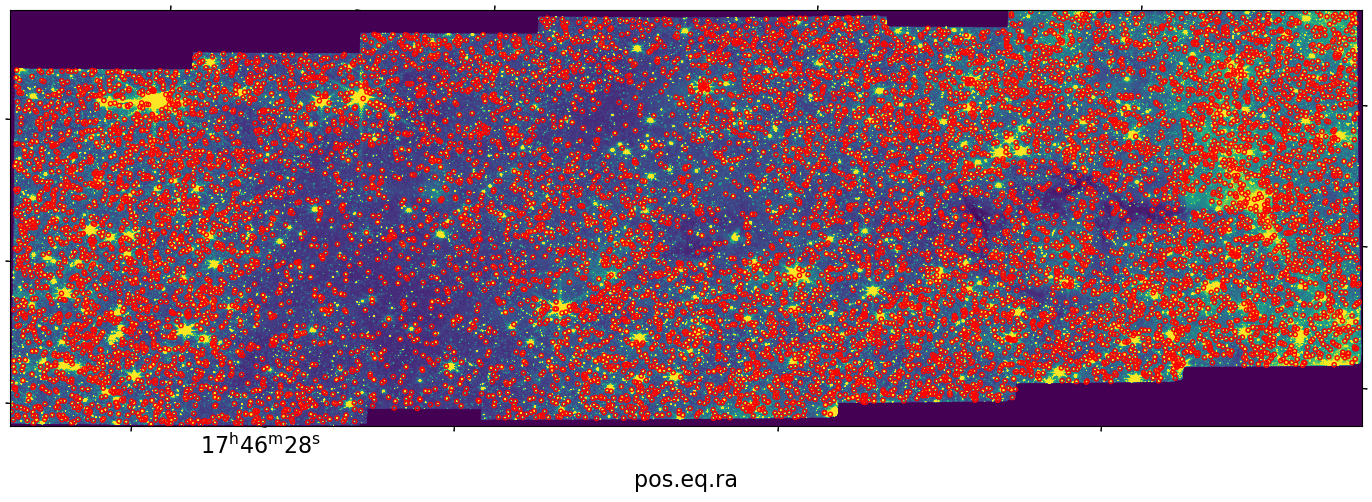

In [56]:
fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
im = ImageModel(fn)
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)

position = (hdu['SCI'].header['CRPIX1'], hdu['SCI'].header['CRPIX2'])
center = ww.pixel_to_world(position[0], position[1])
size = (2.55*u.arcmin, 8.4*u.arcmin)
cutout = Cutout2D(hdu['SCI'].data, position=position, size=size, wcs=ww)

reg = regions.RectangleSkyRegion(center=center, 
                                 width=size[0], height=size[1], angle=8*u.deg)
crds_in = crds_ref[reg.contains(crds_ref, wcs=cutout.wcs)]

plt.figure(figsize=(14,8))
ax = plt.subplot(111, projection=ww)
#ax = plt.subplot(111, projection=cutout.wcs)
#ax.imshow(cutout.data, vmin=0, vmax=50)
ax.imshow(hdu['SCI'].data, vmin=0, vmax=50)
ax.scatter(crds_ref.ra, crds_ref.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')
#ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')

plt.tight_layout()
plt.show()

## Making the Grid

In [57]:
bins_ra = np.arange(0, size[1].to(u.arcsec).value, 1)
bins_dec = np.arange(0, size[0].to(u.arcsec).value, 1)

In [58]:
bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
bins_pix_dec= bins_dec/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value

## Putting Catalog into Grid

In [59]:
crds_ref.shape

(10000,)

In [60]:
crds_ref_pix = np.array(ww.world_to_pixel(crds_ref))#.T
crds_ref_pix

array([[ 938.99357696, 2698.2864932 , 2240.97928093, ..., 5602.83465174,
        4362.26590891, 3934.49564215],
       [ 453.71138402, 1287.19213618,  635.02657132, ..., 2272.58681075,
        2252.07380148, 1437.49265496]])

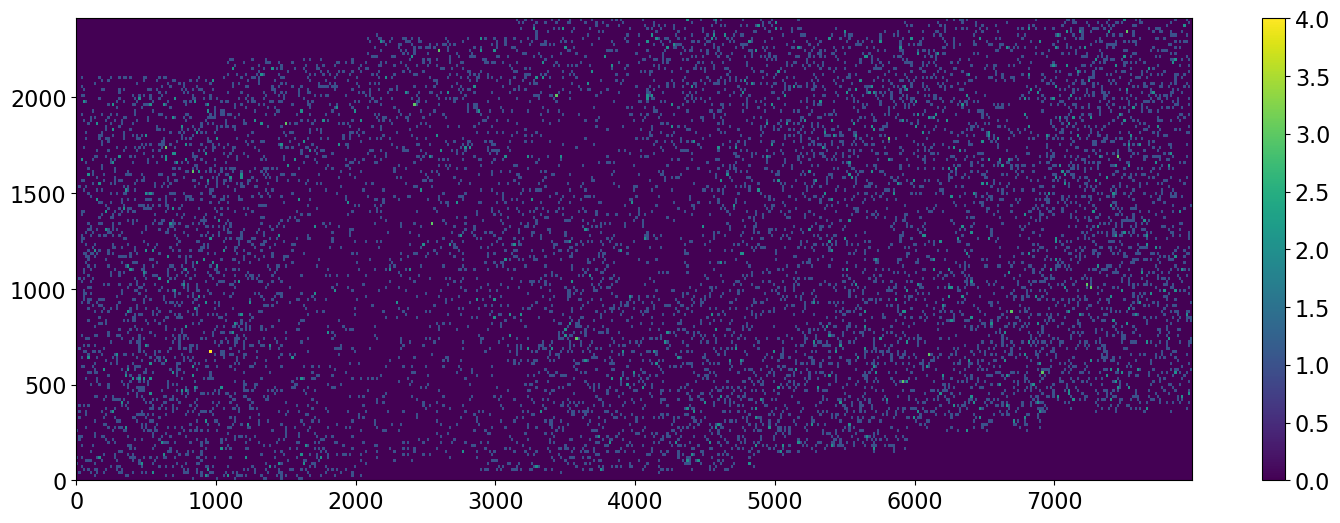

In [61]:
plt.figure(figsize=(18, 6))
plt.hist2d(crds_ref_pix[0], crds_ref_pix[1], bins=[bins_pix_ra,bins_pix_dec])
plt.colorbar()
print()

# Now with Basetable

Approx 70,000 stars with both f410m and f182m magnitudes

Approx 65,000 stars with both f410m and f405n magnitudes - does this remove "false" stars? Many saturated stars not included?

Approx 300,000 stars with both f405n and f466n - should better remove "false" stars? 

Why are there more stars in the narrow filters? Due to saturated stars or "false" stars?

"false" stars = diffration spikes

In [62]:
tbl_use = basetable[(basetable['qf_f405n']>0.6) & ~(np.isnan(basetable['mag_ab_f410m'])) & ~(np.isnan(basetable['mag_ab_f182m']))]
#[~(basetable['mag_ab_f410m'].mask) & ~(basetable['mag_ab_f182m'].mask)]
#[~(basetable['mag_ab_f410m'].mask) & ~(basetable['mag_ab_f405n'].mask)]
#[~(basetable['mag_ab_f466n'].mask) & ~(basetable['mag_ab_f405n'].mask) & (basetable['qf_f405n']>0.6)]
crds_use = tbl_use['skycoord_ref']

In [63]:
len(tbl_use)

58903

## Making the Grid

In [64]:
size = (2.55*u.arcmin, 8.4*u.arcmin) # approx size of field
bins_ra = np.arange(0, size[1].to(u.arcsec).value, 1)
bins_dec = np.arange(0, size[0].to(u.arcsec).value, 1)

In [65]:
bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
bins_pix_dec= bins_dec/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value

## Putting Catalog in Grid

In [66]:
crds_use_pix = np.array(ww.world_to_pixel(crds_use))#.T
crds_use_pix

array([[ 633.42822786,  963.85154989,  270.04717087, ..., 2011.74545084,
        7248.2488001 , 6610.74788982],
       [  11.13294987,    9.24848404,   27.63840331, ..., 2122.96051717,
        1019.17360093, 1884.79180522]])

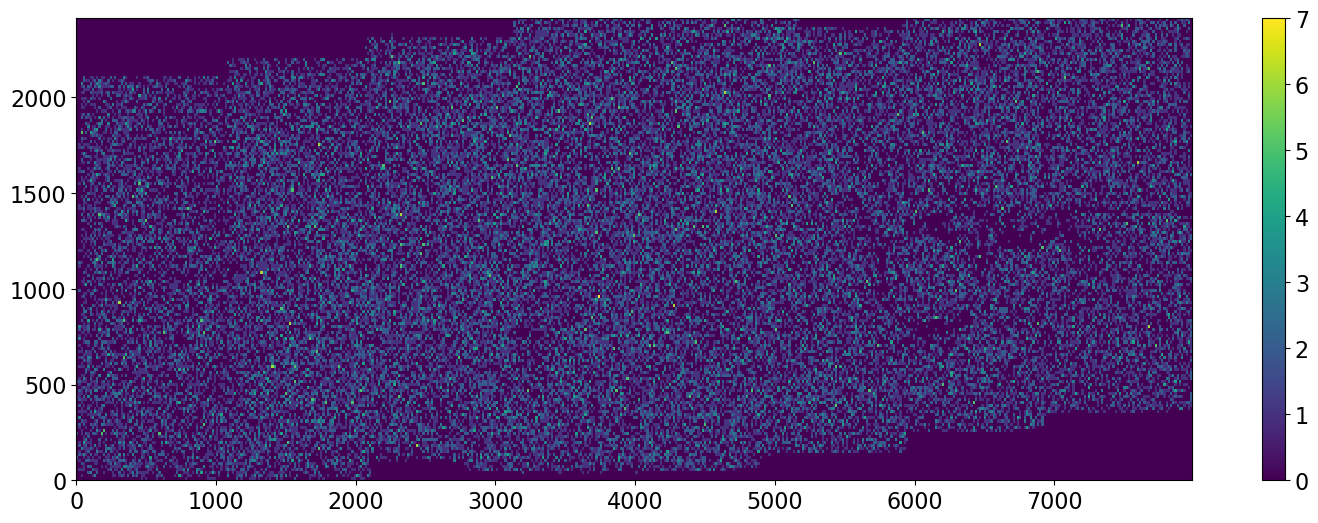

In [67]:
plt.figure(figsize=(18, 6))
plt.hist2d(crds_use_pix[0], crds_use_pix[1], bins=[bins_pix_ra, bins_pix_dec])
plt.colorbar()
print()

## Color

In [68]:
color = tbl_use['mag_ab_f182m'] - tbl_use['mag_ab_f410m']

In [69]:
bins_color = np.arange(-7, 15, 1)
bins_color

array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14])

In [70]:
color_couples = np.array([(b, b+1) for b in bins_color])
color_couples

array([[-7, -6],
       [-6, -5],
       [-5, -4],
       [-4, -3],
       [-3, -2],
       [-2, -1],
       [-1,  0],
       [ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14],
       [14, 15]])

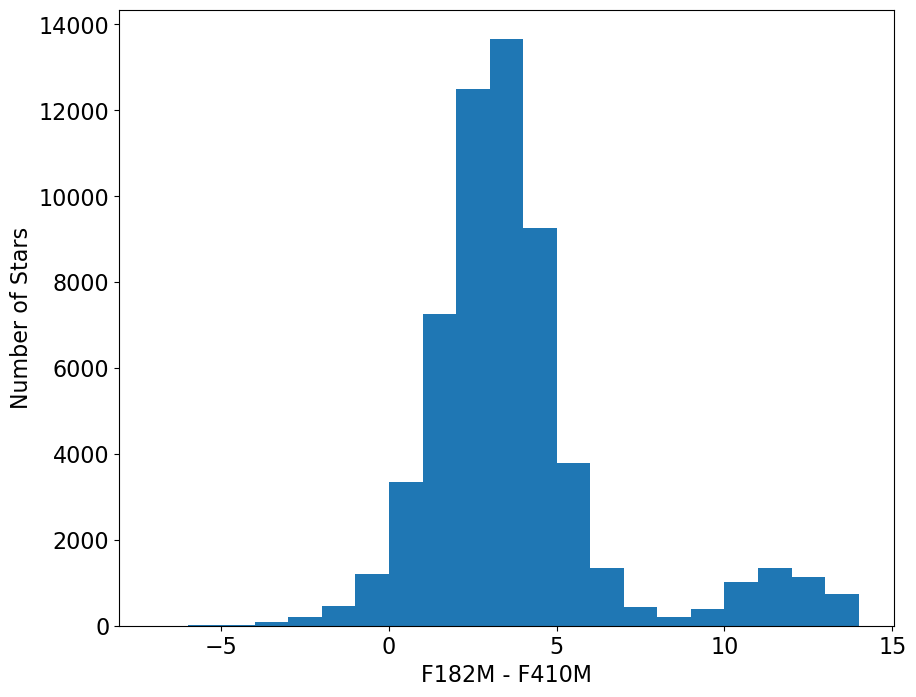

In [71]:
plt.hist(color, bins=bins_color)
plt.xlabel('F182M - F410M')
plt.ylabel('Number of Stars')
print()

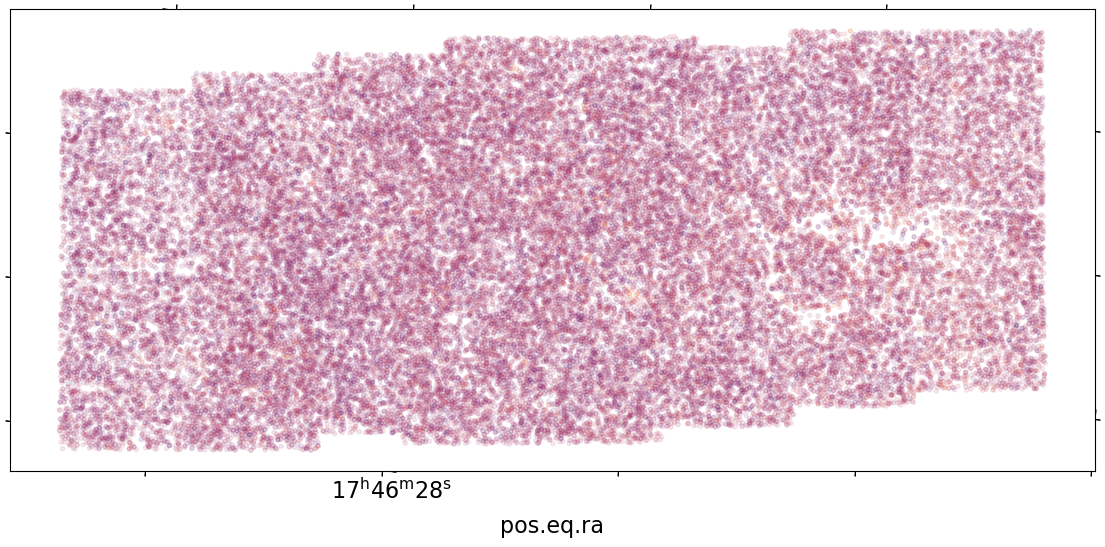

In [72]:
plt.figure(figsize=(14, 6))
ax = plt.subplot(111, projection=ww)
#ax.imshow(hdu['SCI'].data, vmin=0, vmax=50)
ax.scatter(tbl_use['skycoord_ref'].ra, tbl_use['skycoord_ref'].dec, transform=ax.get_transform('world'), marker='.', c=color, alpha=0.1, cmap='inferno')

# Color Slices

In [73]:
def star_density_color(tbl, ww, dx=1, blur=False):
    size = (2.55*u.arcmin, 8.4*u.arcmin) # approx size of field
    bins_ra = np.arange(0, size[1].to(u.arcsec).value, dx)
    bins_dec = np.arange(0, size[0].to(u.arcsec).value, dx)

    bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
    bins_pix_dec= bins_dec/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value

    crds_pix = np.array(ww.world_to_pixel(tbl['skycoord_ref']))

    plt.figure(figsize=(18, 6))
    h, xedges, yedges = np.histogram2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
    if not blur:
        h1, xedges1, yedges1, y = plt.hist2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
        plt.colorbar()
        return h
    elif blur:
        blurred = gaussian_filter(h, 1)
        plt.imshow(blurred.swapaxes(0,1))
        plt.colorbar()
        return blurred
    
    #.swapaxes(0,1) #, xedges, yedges
    
def make_wcs(h_noshort, hdu):
    wcs_dict = {
        'SIMPLE' : 'T',
        'BITPIX' : -64,
        'NAXIS' : 2,
        'NAXIS1' : h_noshort.shape[0],
        'NAXIS2' : h_noshort.shape[1],
        'WCSAXES' : 2,
        'CRPIX1' : h_noshort.shape[0]/2,
        'CRPIX2' : h_noshort.shape[1]/2,
        'CDELT1' : -(2*u.arcsec).to(u.deg).value,
        'CDELT2' : (2*u.arcsec).to(u.deg).value,
        'CROTA2' : 354.6-270,
        'CUNIT1' : 'deg',
        'CUNIT2' : 'deg',
        'CTYPE1' : 'RA---TAN',
        'CTYPE2' : 'DEC--TAN',
        'CRVAL1' : hdu['SCI'].header['CRVAL1'],
        'CRVAL2' : hdu['SCI'].header['CRVAL2'],
        #'LONPOL' : 180.0,
        #'LATPOL' : 0.0,
        #'MJDREF' : 0.0,
        'BUNIT' : '# Stars/px'
    }
    input_wcs = astropy.wcs.WCS(wcs_dict)
    return input_wcs

def make_cube(tbl, ww, hdu, dx=1, blur=False):
    tbl_noshort = tbl[(tbl['qf_f405n']>0.6) & ~(np.isnan(tbl['mag_ab_f410m'])) & (np.isnan(tbl['mag_ab_f182m'])) & 
                      (np.isnan(tbl['mag_ab_f187n'])) & (np.isnan(tbl['mag_ab_f212n']))]
    h_noshort = star_density_color(tbl_noshort, ww, dx=dx, blur=blur)
    
    tbl_use = tbl[(tbl['qf_f405n']>0.6) & ~(np.isnan(tbl['mag_ab_f410m'])) & ~(np.isnan(tbl['mag_ab_f182m']))]
    cube = np.array([star_density_color(tbl_use[(color > lowmag) & (color < highmag)], ww, dx=dx, blur=blur) for lowmag, highmag in color_couples])

    cube_full = np.concatenate([cube, h_noshort.reshape((1,h_noshort.shape[0],h_noshort.shape[1]))])
    input_wcs = make_wcs(h_noshort, hdu)
    hdu_cube = fits.PrimaryHDU(data=cube_full.swapaxes(1,2), header=input_wcs.to_header())

    return hdu_cube

In [97]:
np.histogram2d??

Signature: np.histogram2d(x, y, bins=10, range=None, density=None, weights=None)
Source:   
@array_function_dispatch(_histogram2d_dispatcher)
def histogram2d(x, y, bins=10, range=None, density=None, weights=None):
    """
    Compute the bi-dimensional histogram of two data samples.

    Parameters
    ----------
    x : array_like, shape (N,)
        An array containing the x coordinates of the points to be
        histogrammed.
    y : array_like, shape (N,)
        An array containing the y coordinates of the points to be
        histogrammed.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:

          * If int, the number of bins for the two dimensions (nx=ny=bins).
          * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
          * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
          * If [array, array], the bin edges in each dimension
            

In [100]:
h.shape

(503, 152)

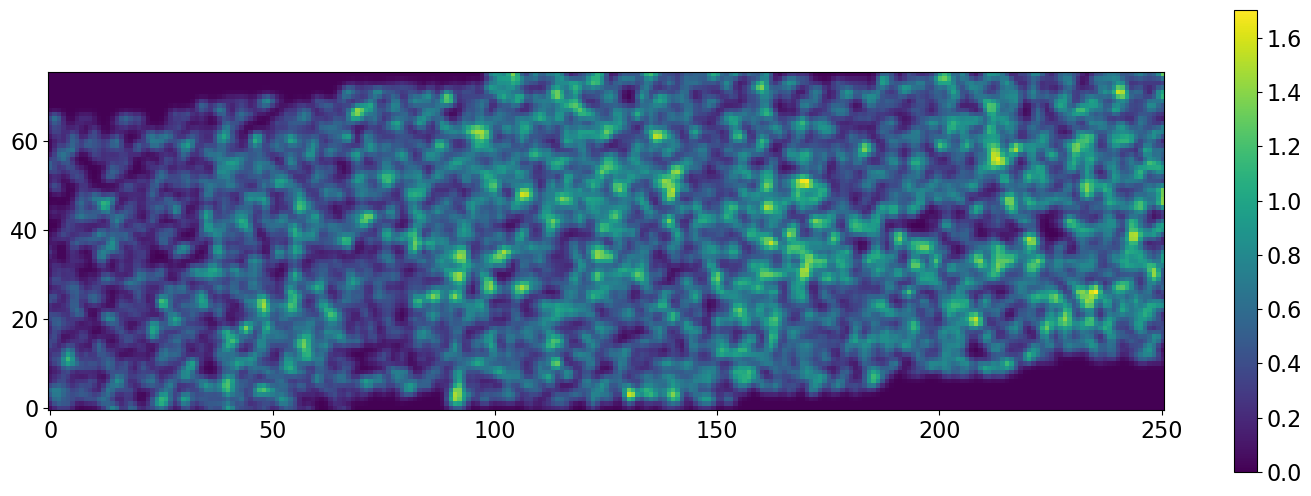

In [74]:
tbl_color1 = tbl_use[(color>4) & (color<5)]#tbl_use[(color>bins_color[0]) & (color<bins_color[1])]
h = star_density_color(tbl_color1, ww, dx=2, blur=True)

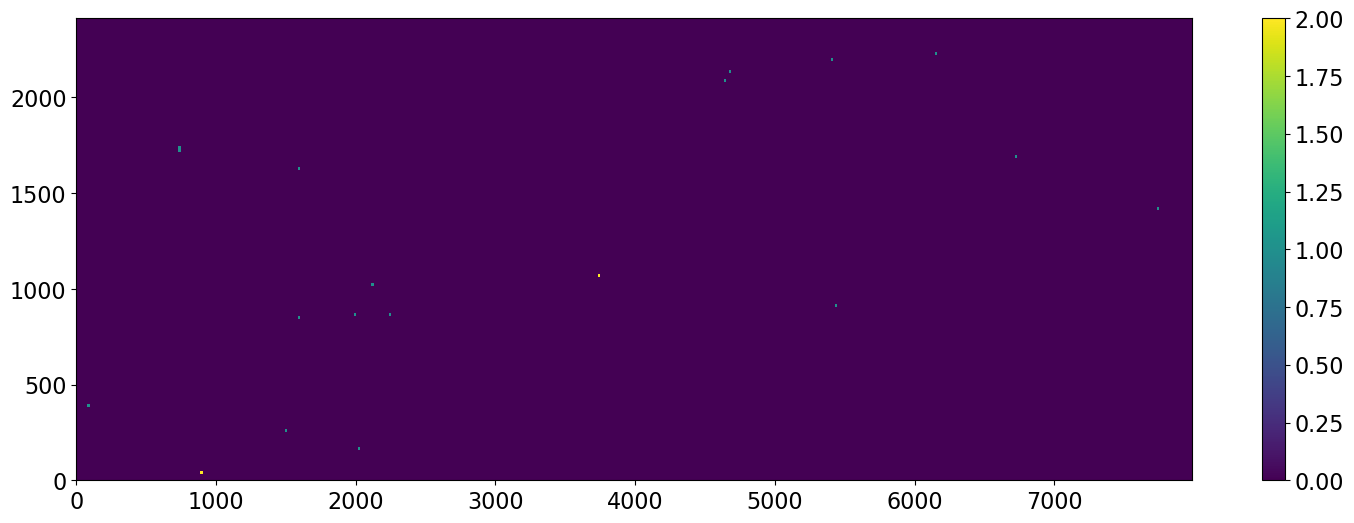

In [75]:
tbl_color1 = tbl_use[(color>bins_color[2]) & (color<bins_color[3])]
h = star_density_color(tbl_color1, ww)

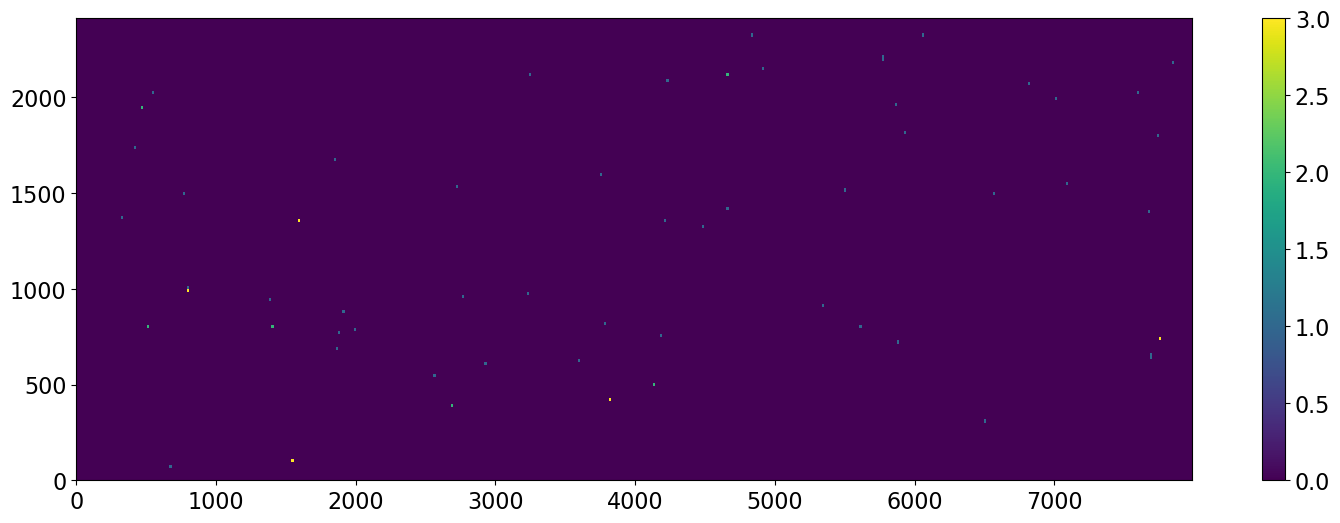

In [76]:
tbl_color1 = tbl_use[(color>bins_color[3]) & (color<bins_color[4])]
h = star_density_color(tbl_color1, ww)

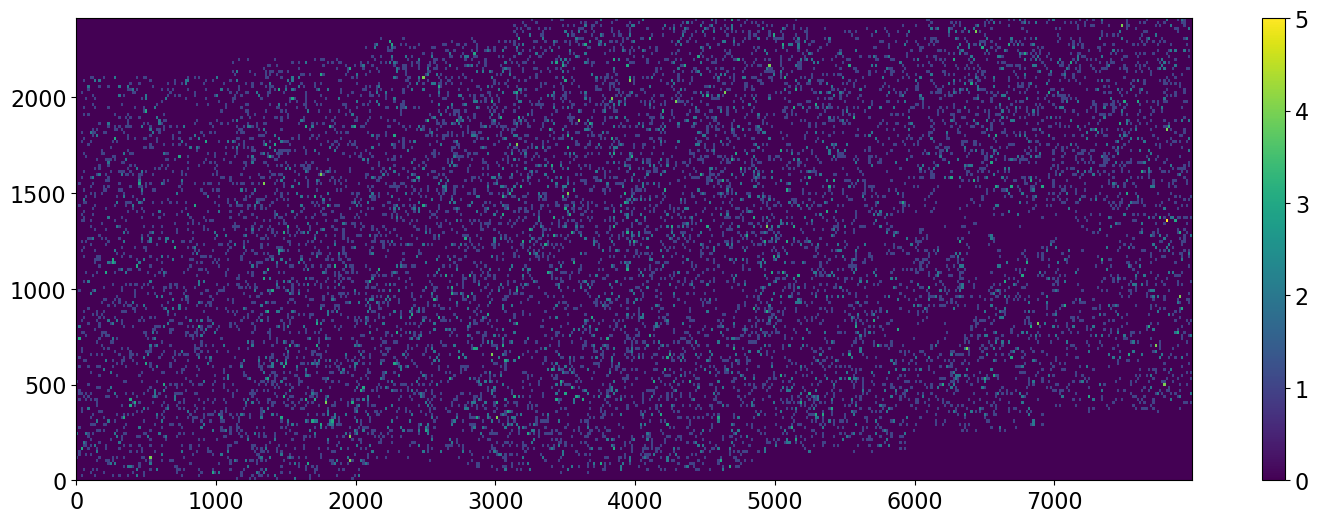

In [77]:
tbl_color1 = tbl_use[(color>3) & (color<4)]
h = star_density_color(tbl_color1, ww)

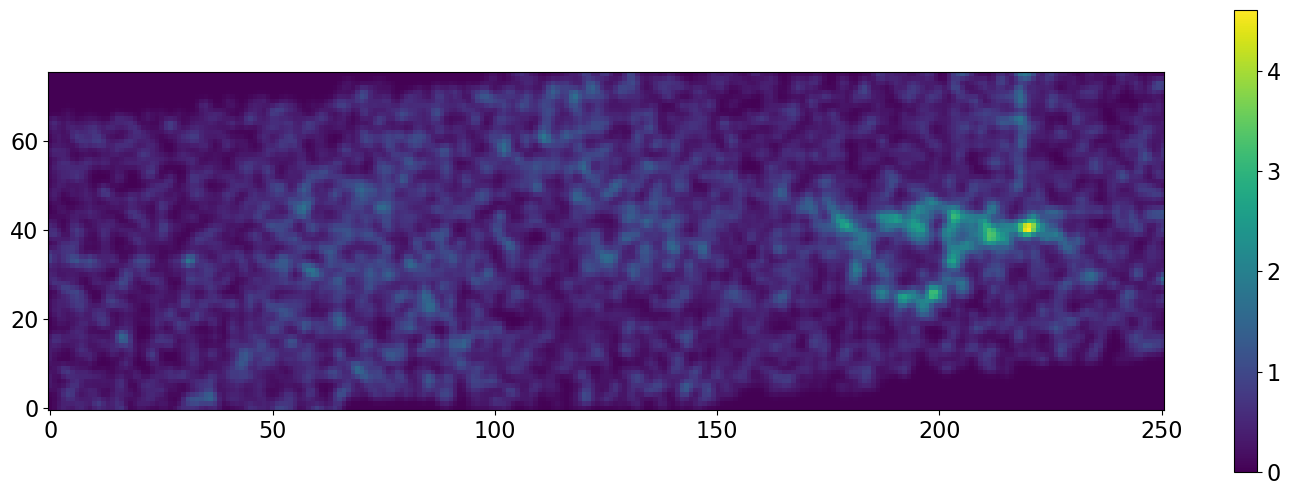

In [78]:
tbl_noshort = basetable[(basetable['qf_f405n']>0.6) & ~(basetable['mag_ab_f410m'].mask) & (basetable['mag_ab_f182m'].mask) & (basetable['mag_ab_f187n'].mask) & (basetable['mag_ab_f212n'].mask)]
#tbl_color1 = tbl_use[(color>3) & (color<4)]
h_noshort = star_density_color(tbl_noshort, ww, dx=2, blur=True)

In [79]:
print(color_couples[9])
print(color_couples[10])
print(color_couples[11])
print(color_couples[12])
print(color_couples[13])

[2 3]
[3 4]
[4 5]
[5 6]
[6 7]


2024-05-28 12:12:31,236 - stpipe - WARNING - /scratch/local/32804124/ipykernel_1081337/1946944401.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))



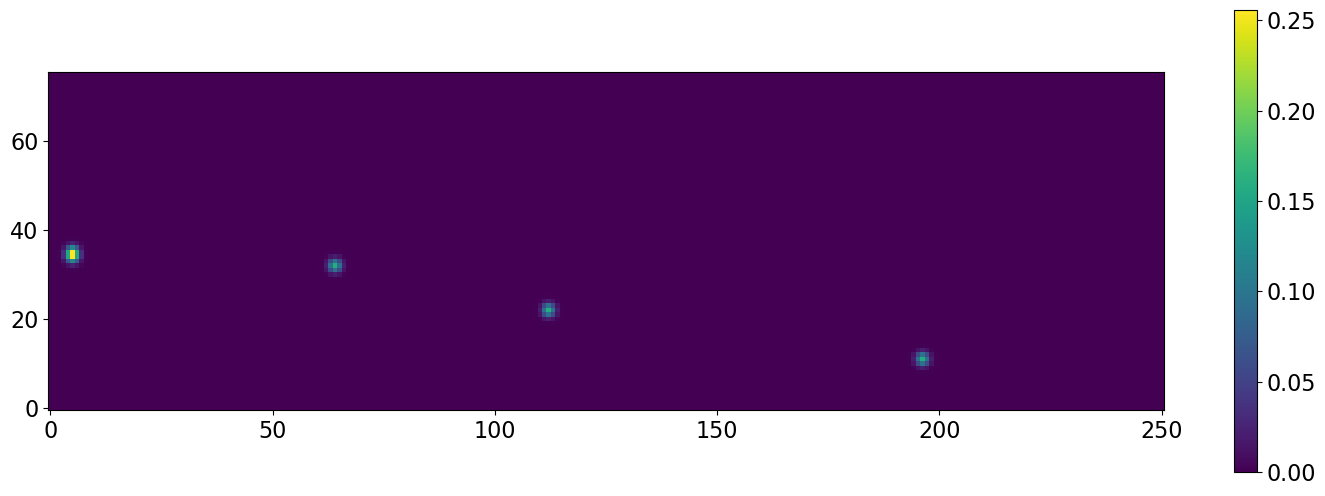

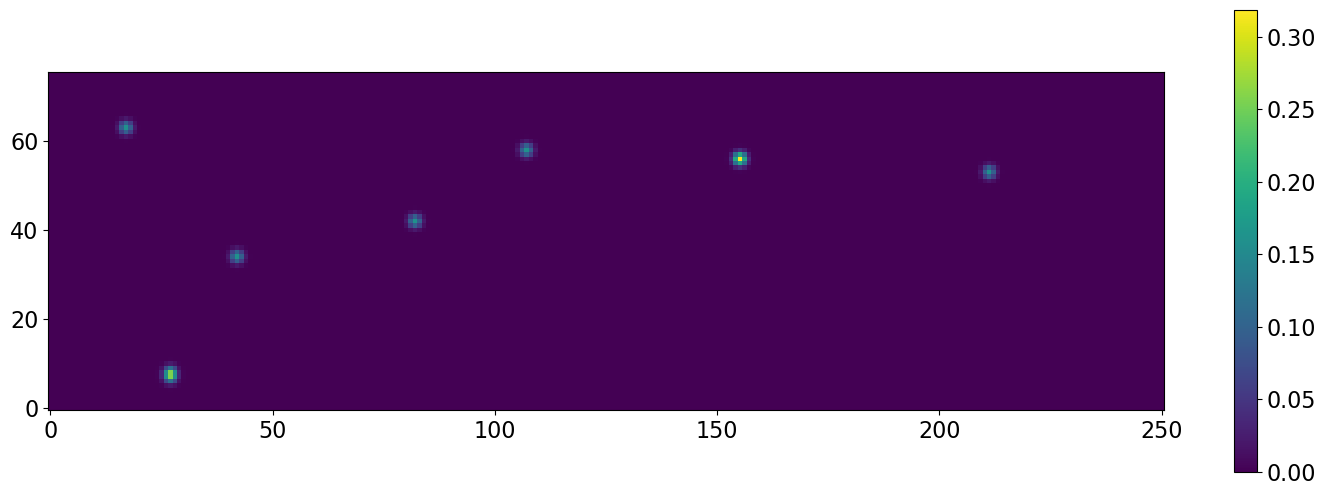

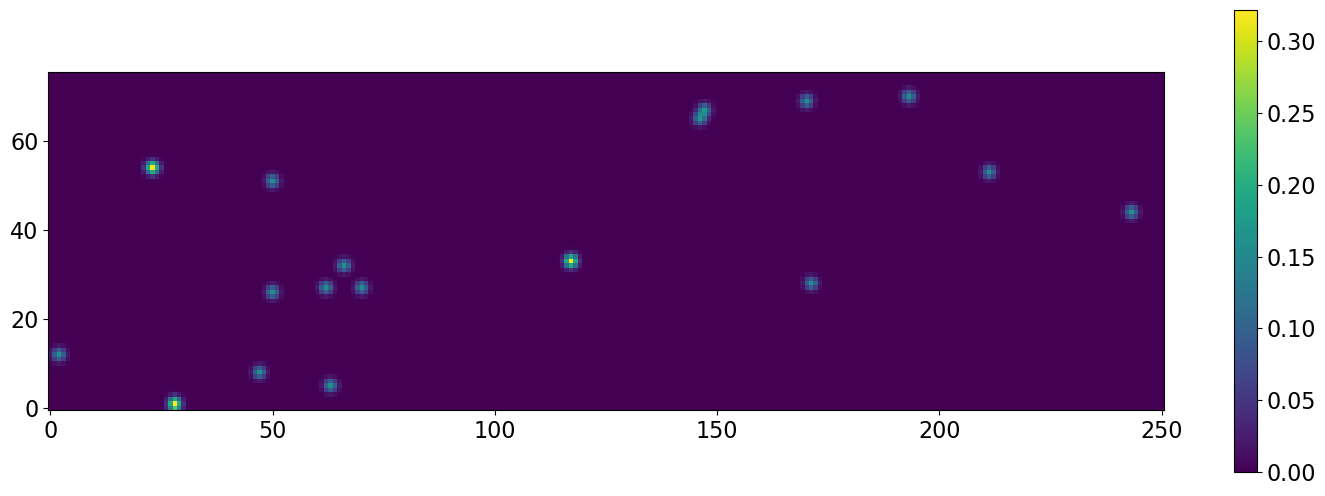

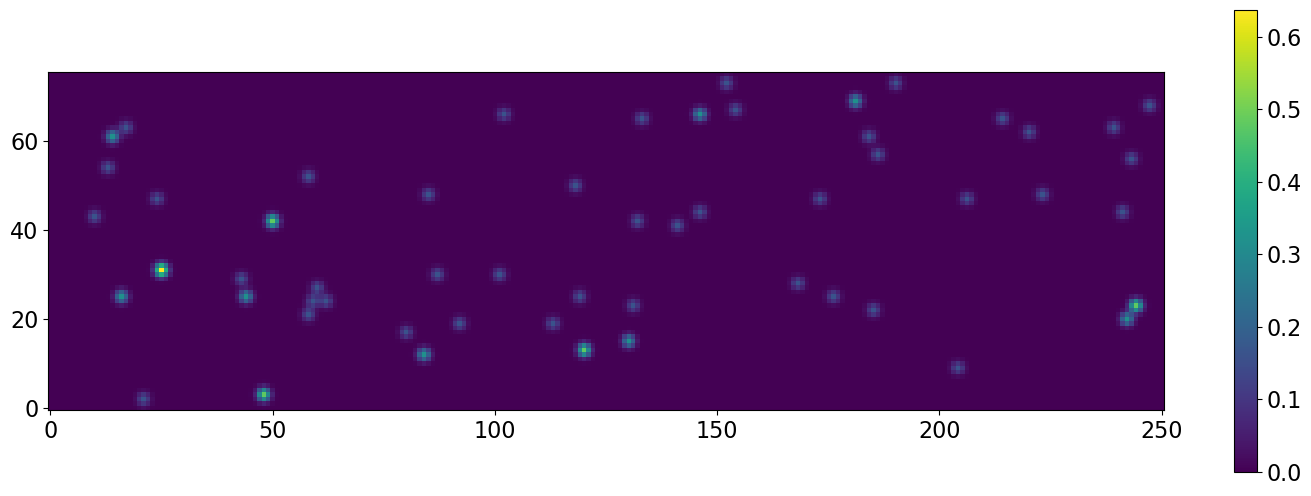

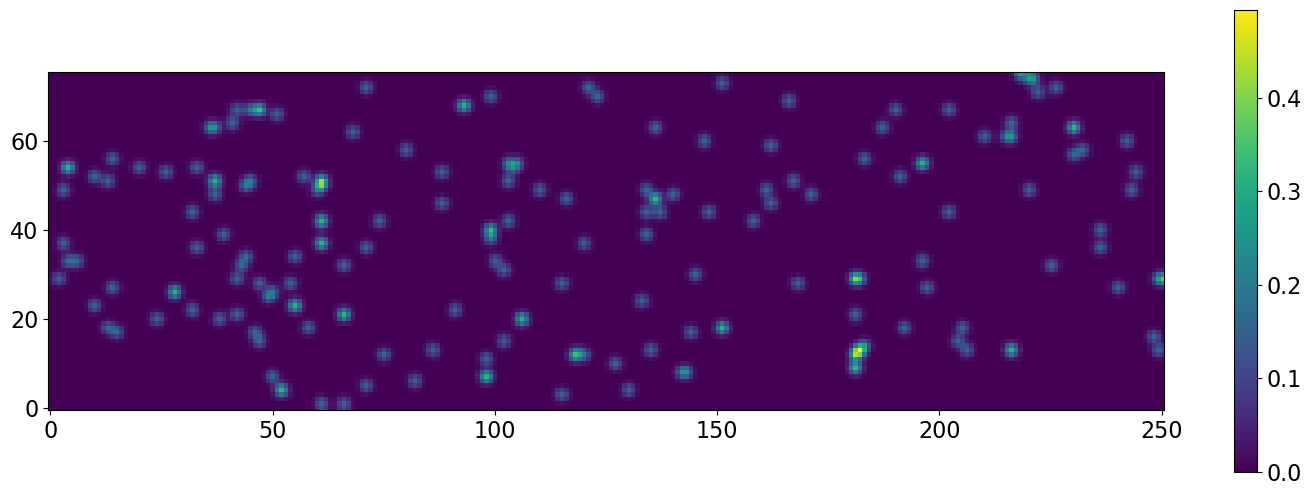

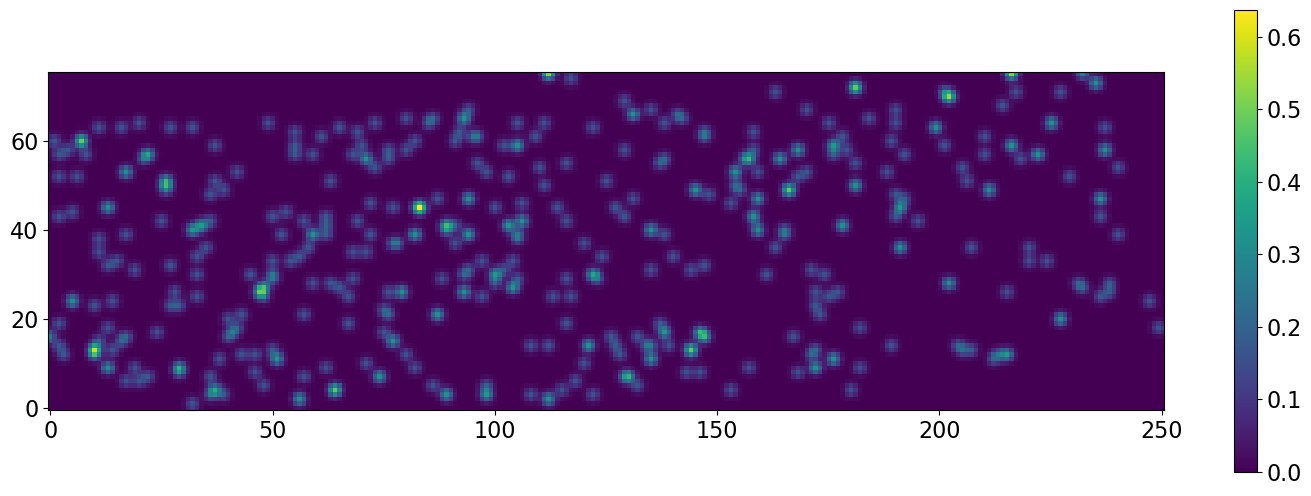

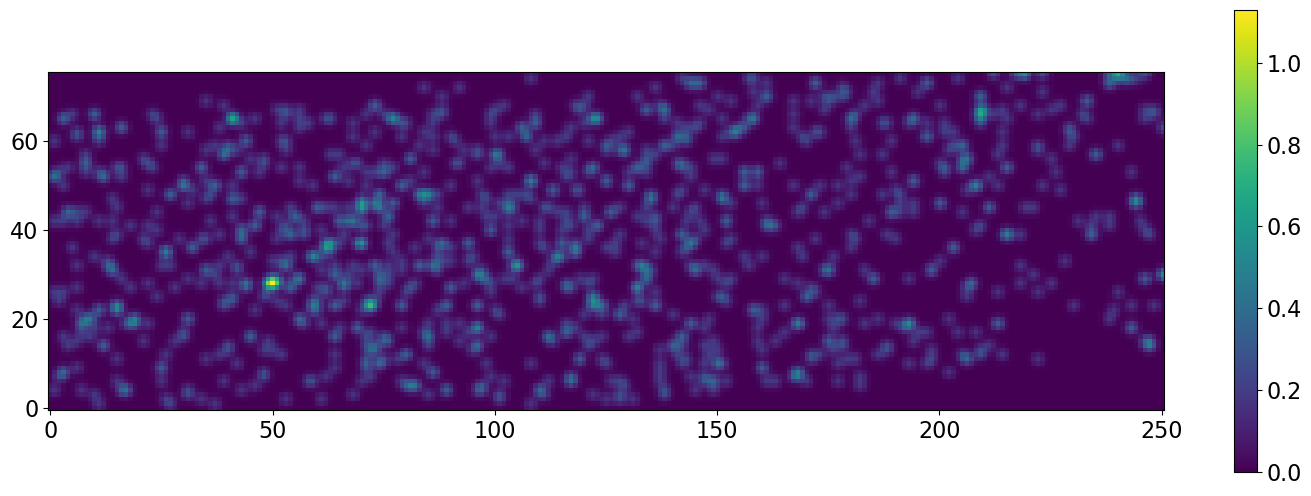

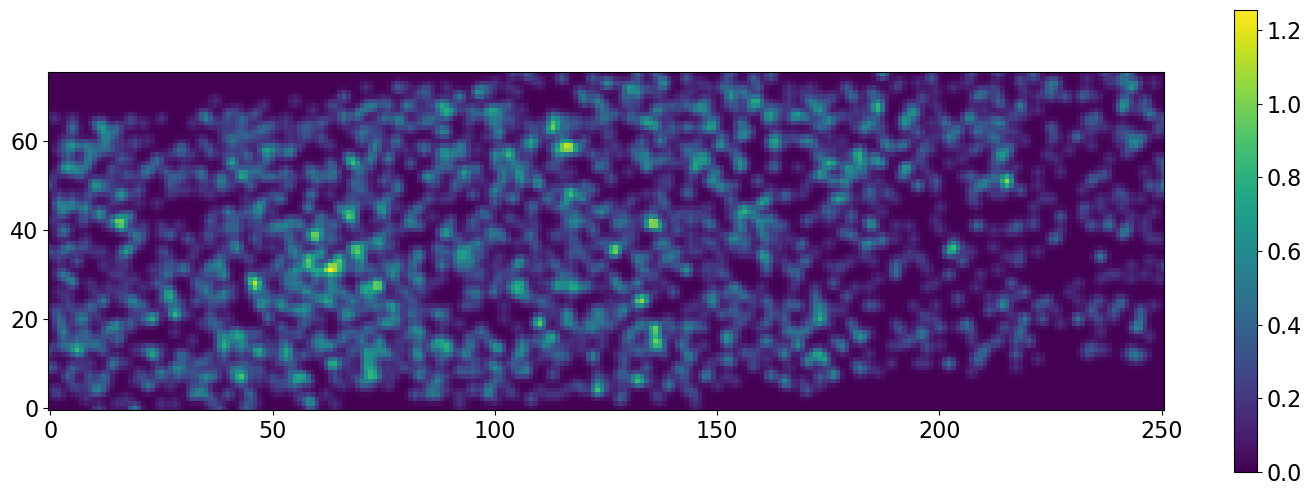

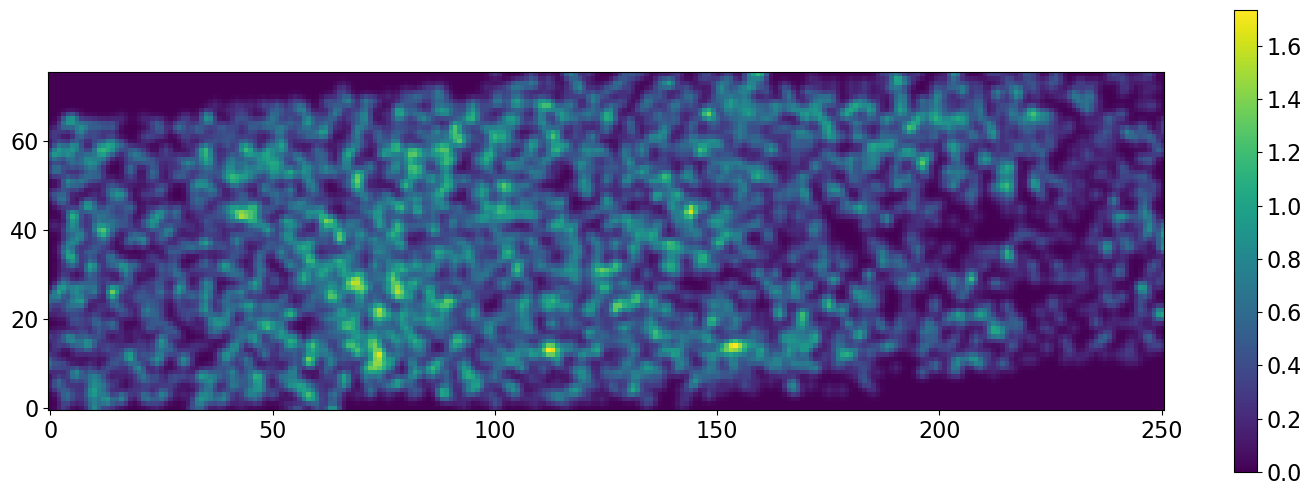

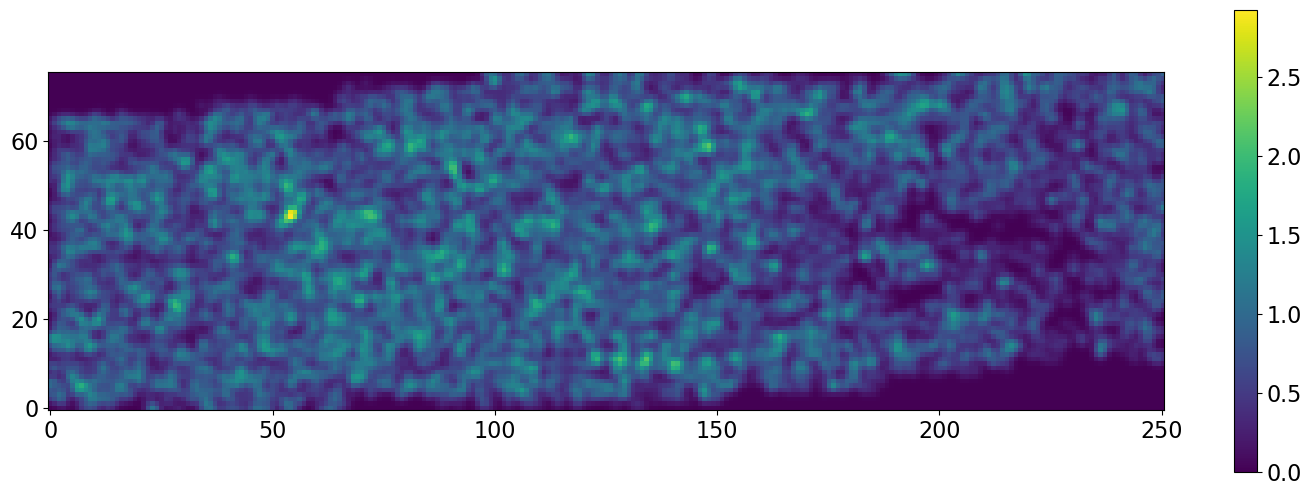

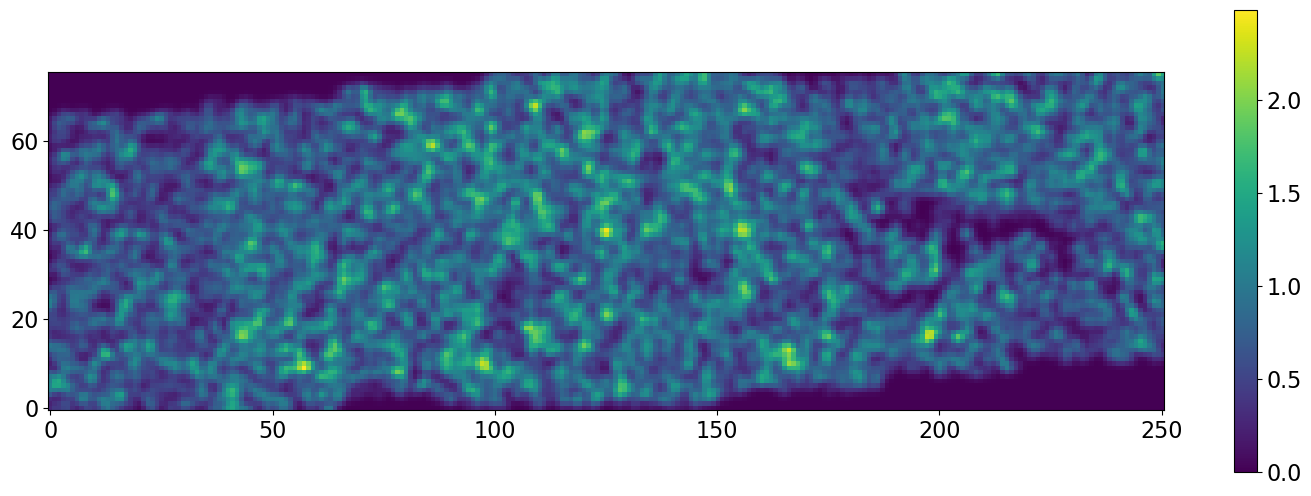

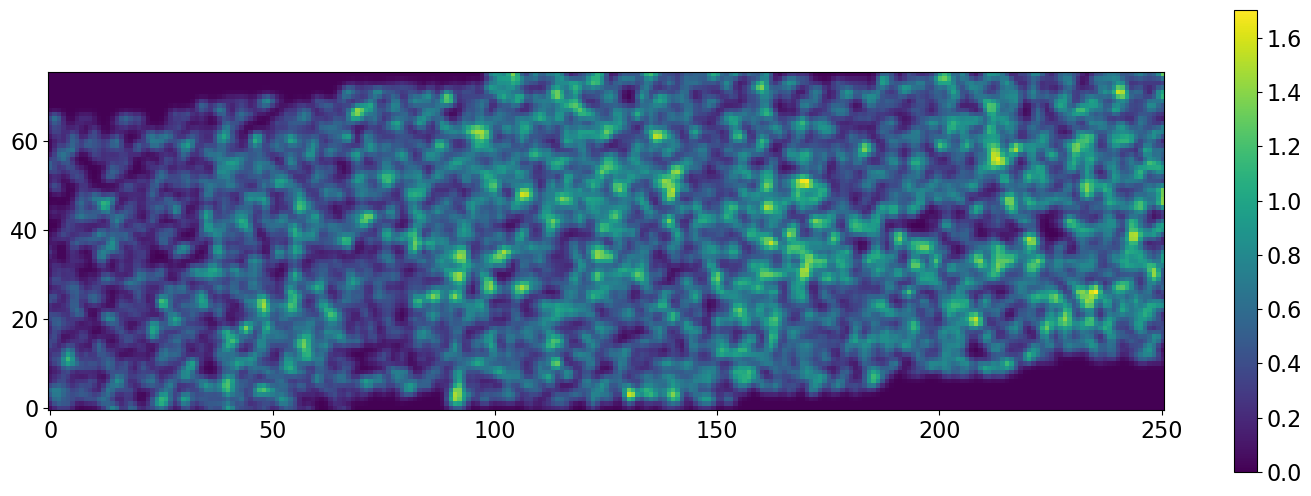

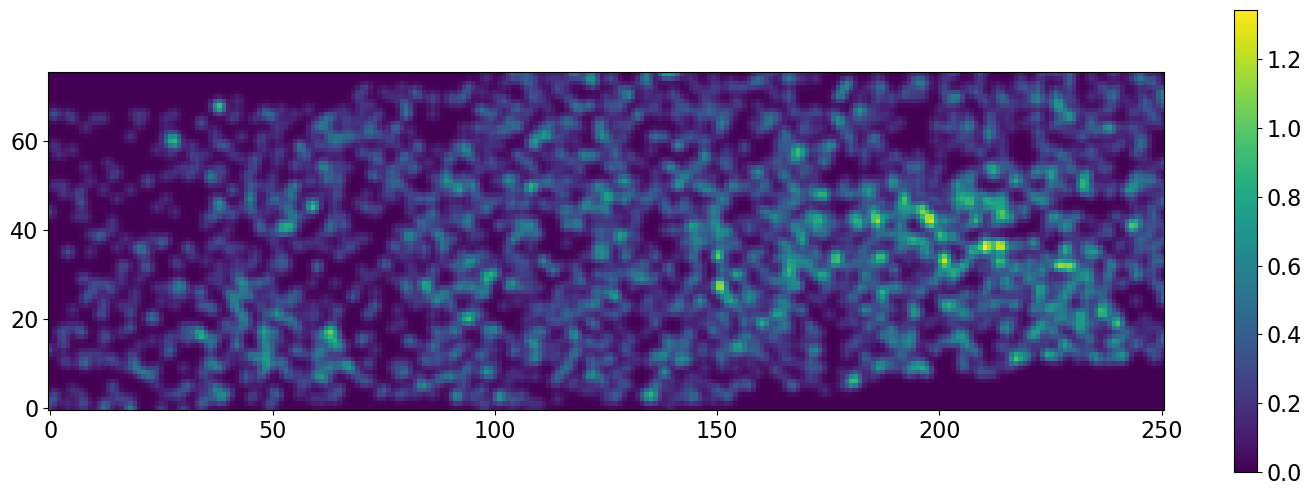

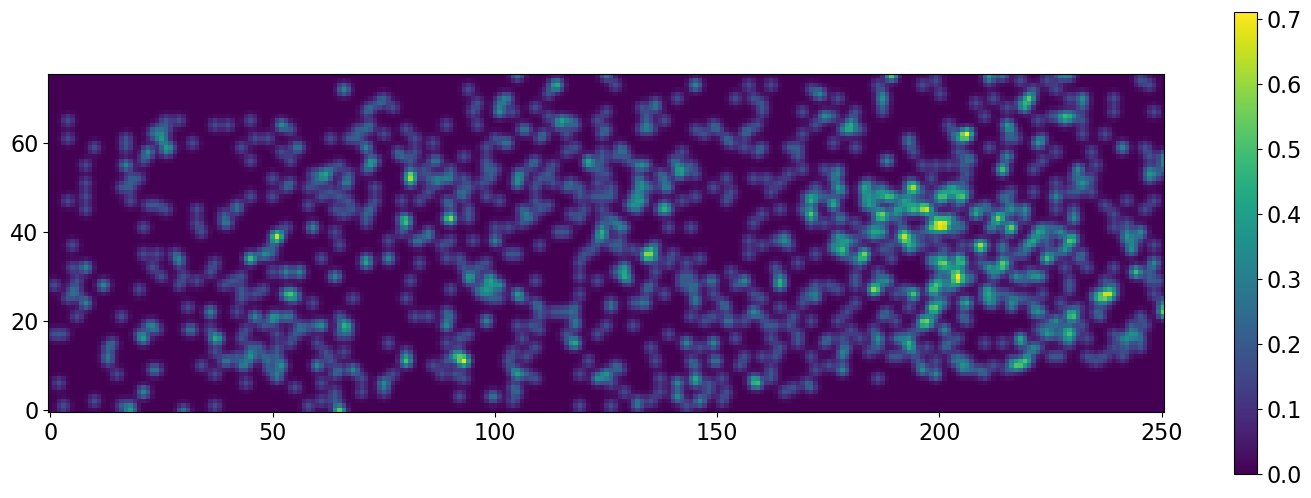

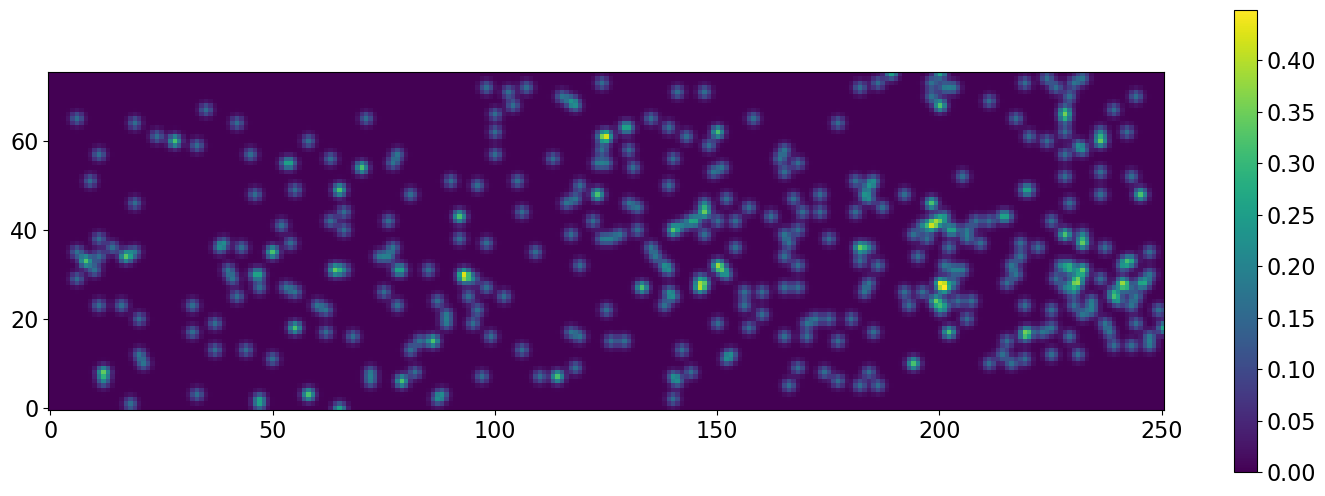

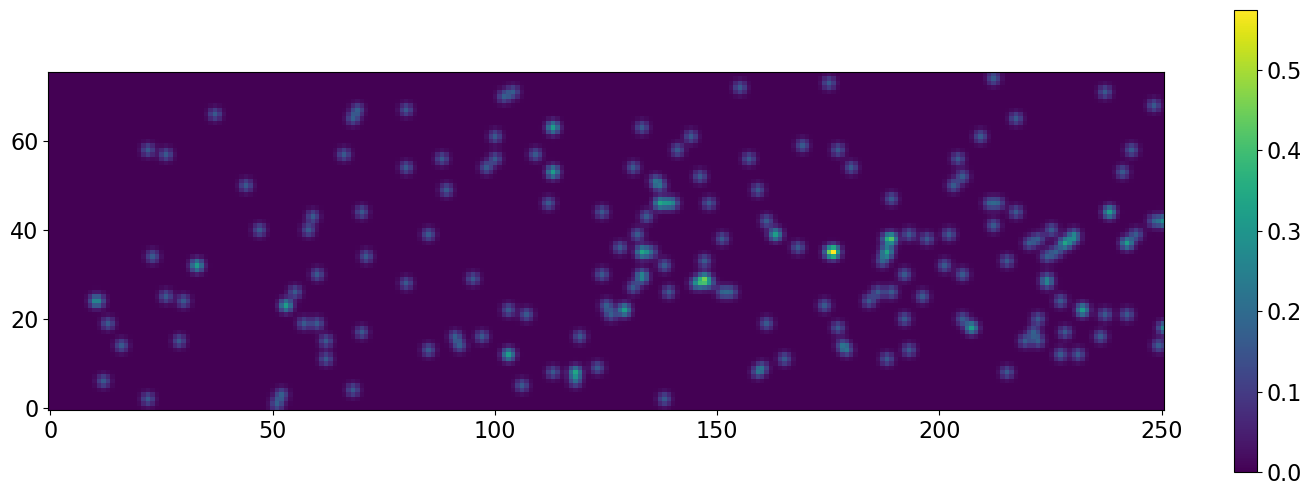

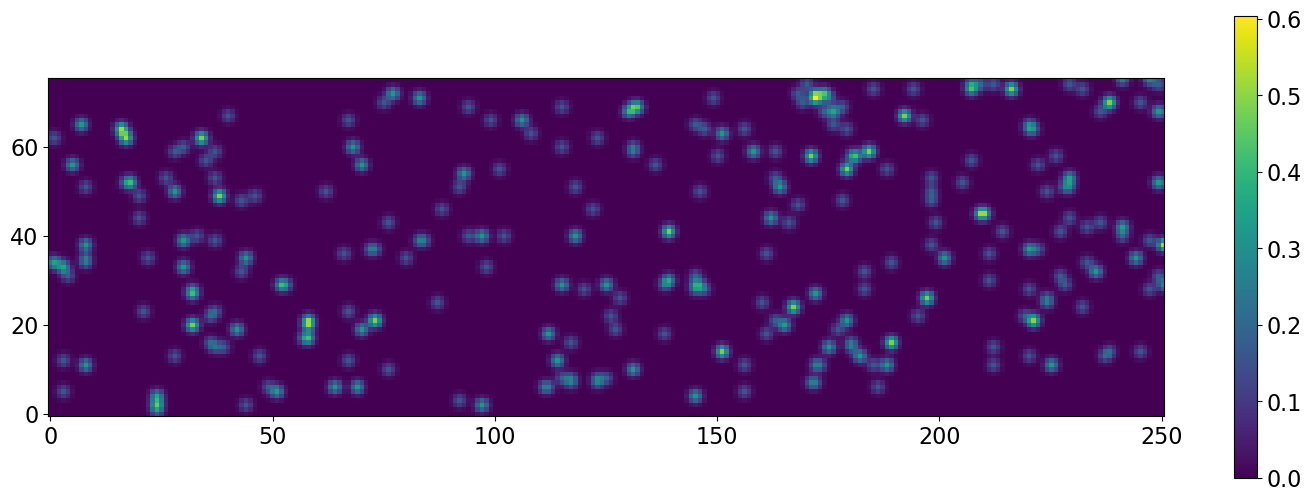

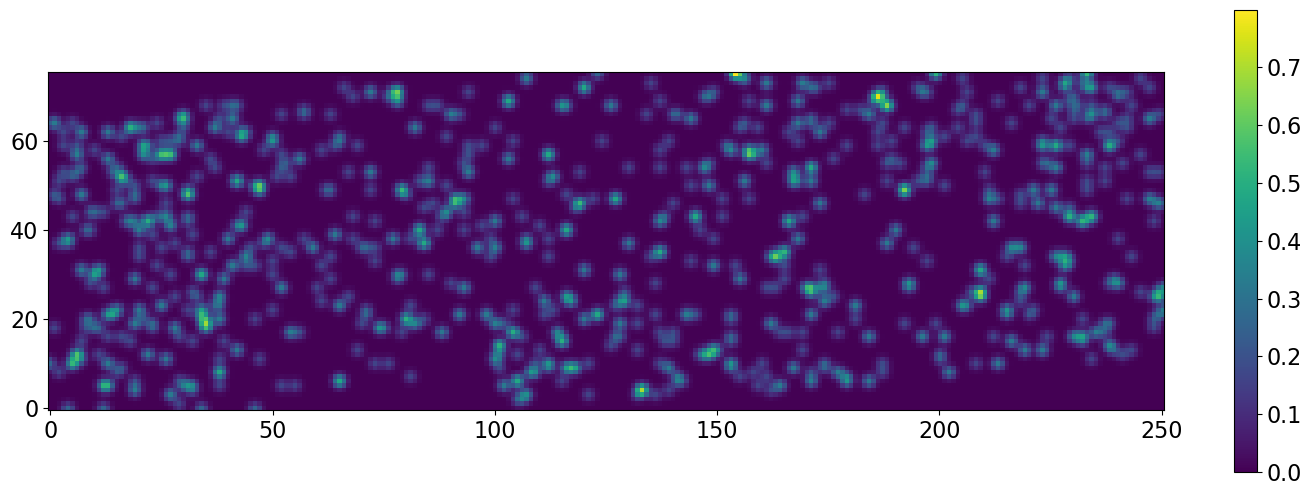

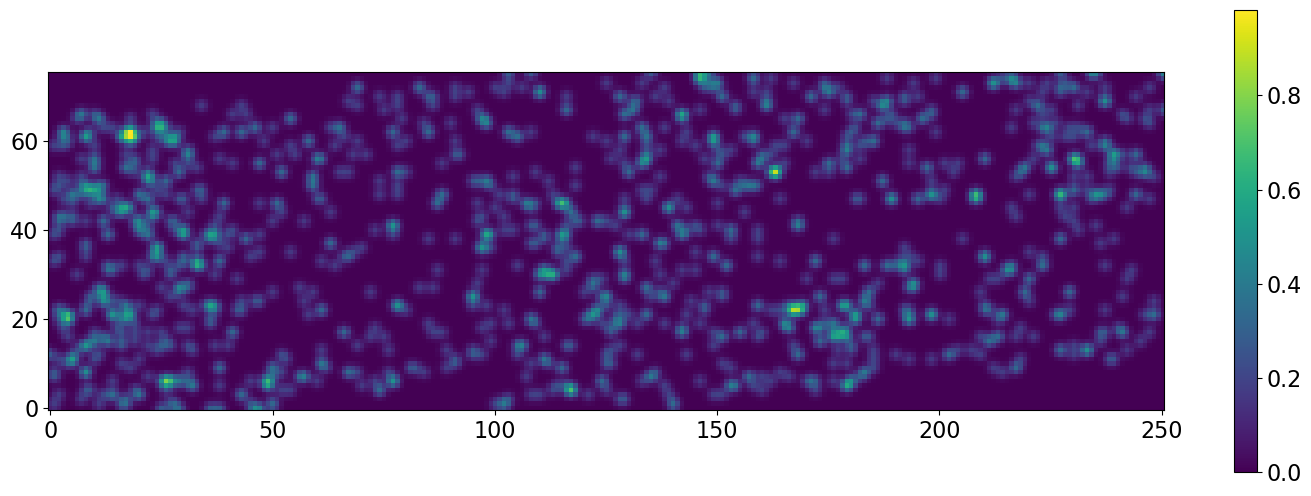

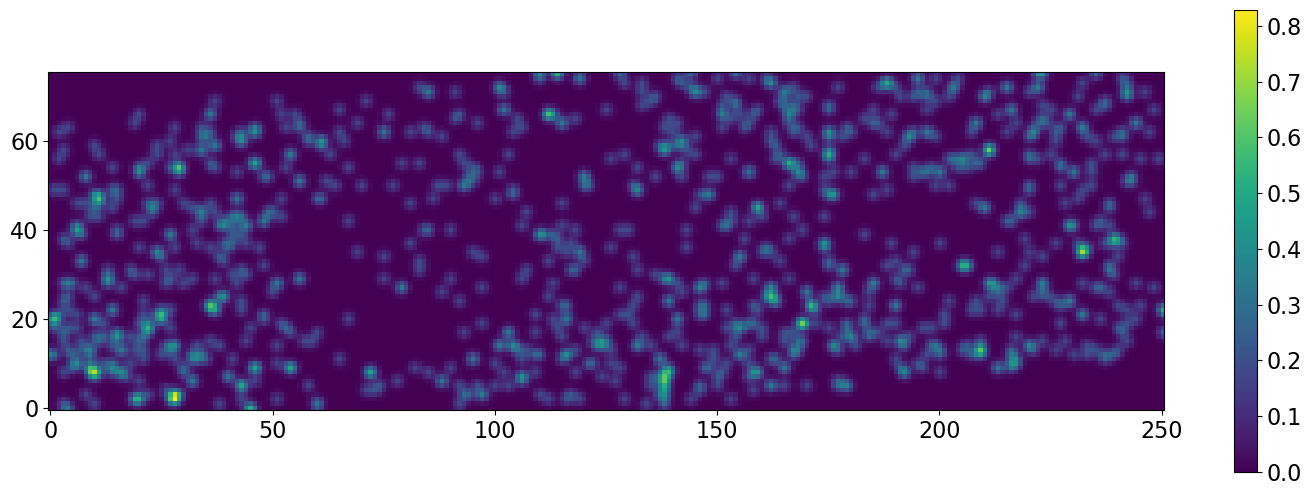

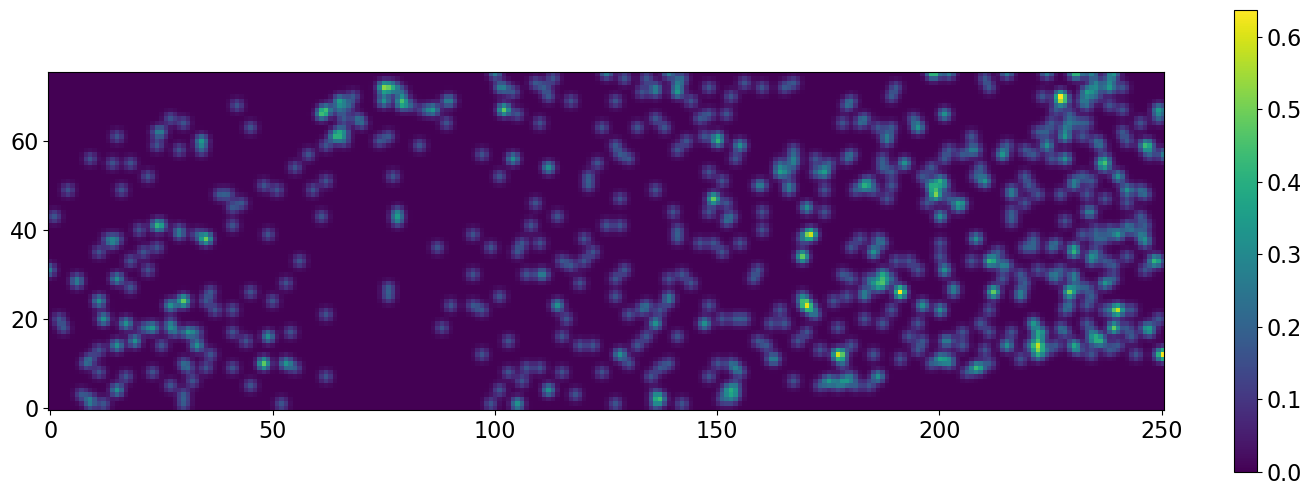

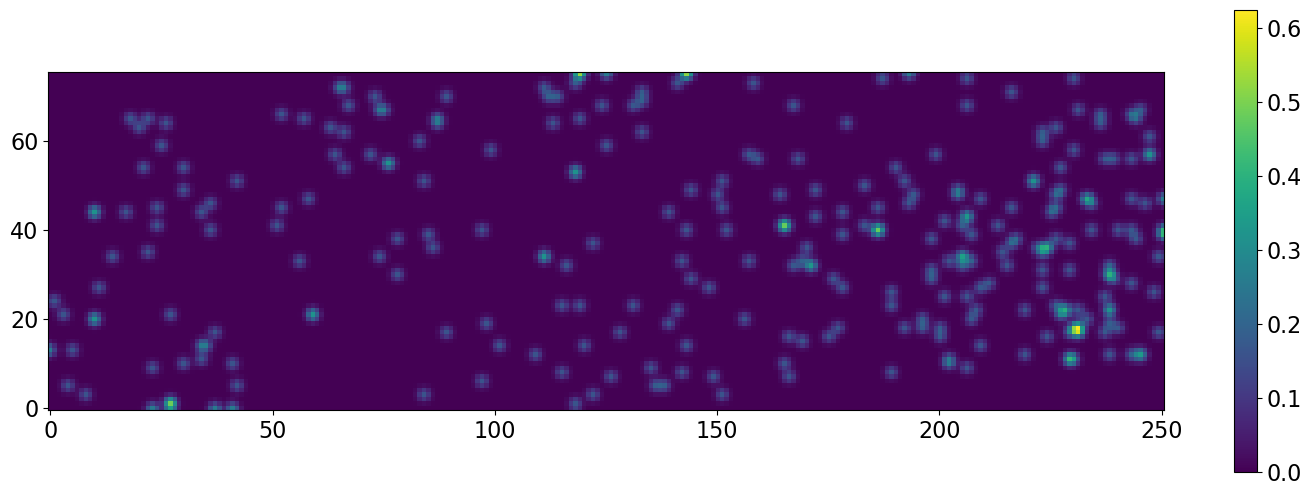

In [36]:
cube = np.array([star_density_color(tbl_use[(color > lowmag) & (color < highmag)], ww, dx=2, blur=True) for lowmag, highmag in color_couples])
#cube = np.array([star_density_color(tbl_use[(color > lowmag) & (color < highmag)], ww, dx=1) for lowmag, highmag in color_couples])
#cube.shape

In [39]:
h_noshort.reshape((1,h_noshort.shape[0],h_noshort.shape[1])).shape

(1, 251, 76)

In [40]:
np.split(cube, 22)[1].shape

(1, 251, 76)

In [41]:
cube_full = np.concatenate([cube, h_noshort.reshape((1,h_noshort.shape[0],h_noshort.shape[1]))])

In [43]:
# Define the astropy.wcs.WCS object using a Python dictionary as input

import astropy.wcs

wcs_dict = {
    'SIMPLE' : 'T',
    'BITPIX' : -64,
    'NAXIS' : 2,
    'NAXIS1' : h_noshort.shape[0],
    'NAXIS2' : h_noshort.shape[1],
    'WCSAXES' : 2,
    'CRPIX1' : h_noshort.shape[0]/2,
    'CRPIX2' : h_noshort.shape[1]/2,
    'CDELT1' : -(2*u.arcsec).to(u.deg).value,
    'CDELT2' : (2*u.arcsec).to(u.deg).value,
    'CROTA2' : 354.6-270,
    'CUNIT1' : 'deg',
    'CUNIT2' : 'deg',
    'CTYPE1' : 'RA---TAN',
    'CTYPE2' : 'DEC--TAN',
    'CRVAL1' : hdu['SCI'].header['CRVAL1'],
    'CRVAL2' : hdu['SCI'].header['CRVAL2'],
    #'LONPOL' : 180.0,
    #'LATPOL' : 0.0,
    #'MJDREF' : 0.0,
    'BUNIT' : '# Stars/px'
}
input_wcs = astropy.wcs.WCS(wcs_dict)

In [44]:
pixcrds = input_wcs.world_to_pixel(crds_use)

In [46]:
hdu_cube = fits.PrimaryHDU(data=cube_full.swapaxes(1,2), header=input_wcs.to_header())
#hdu_cube.writeto('/orange/adamginsburg/jwst/cloudc/images/star_density_color_cube_4ac2_smoothed.fits', overwrite=True)

2024-05-29 12:58:09,847 - stpipe - WARNING - /scratch/local/32804124/ipykernel_1081337/158456792.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))



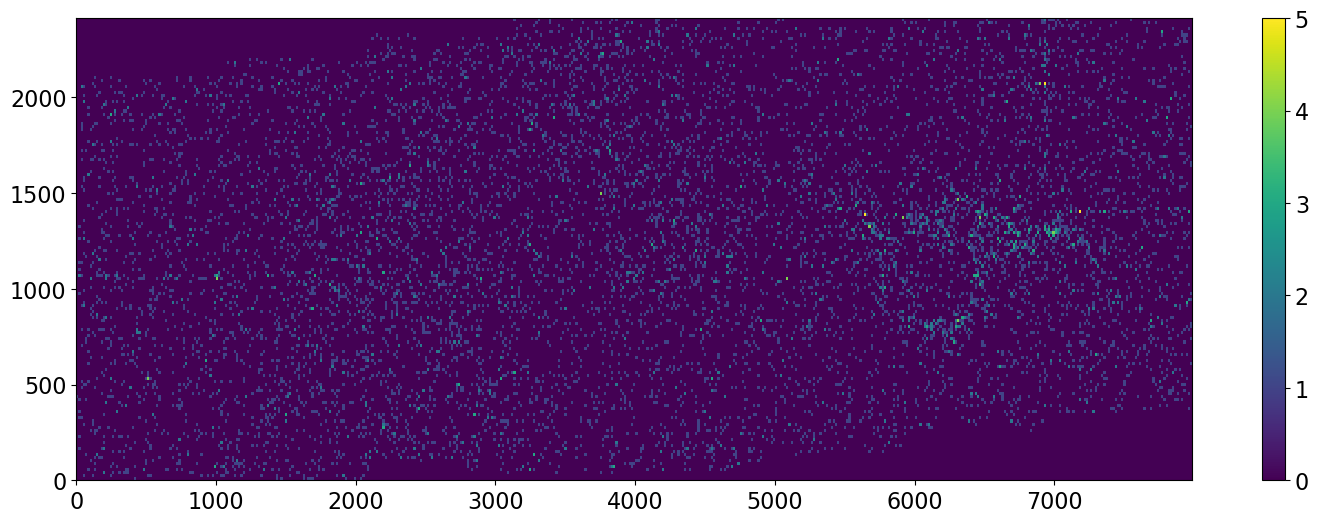

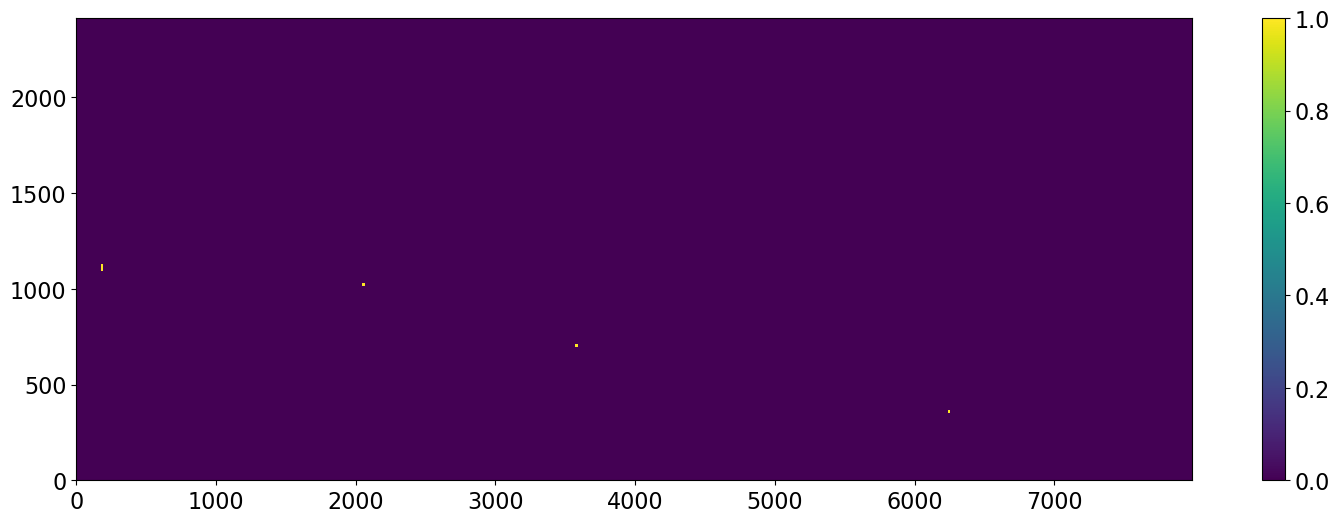

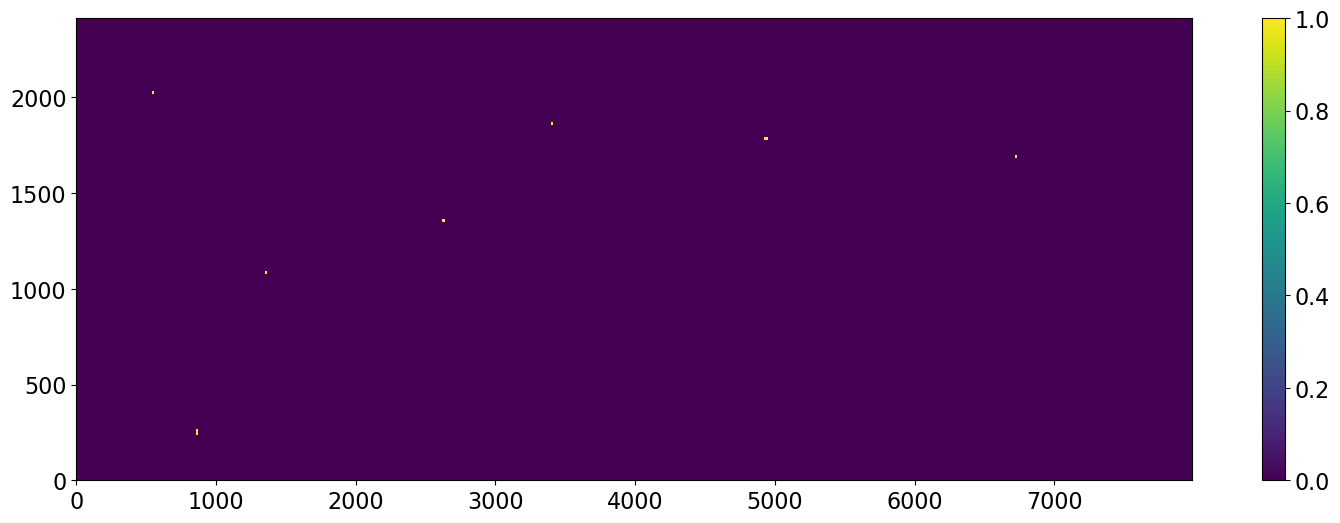

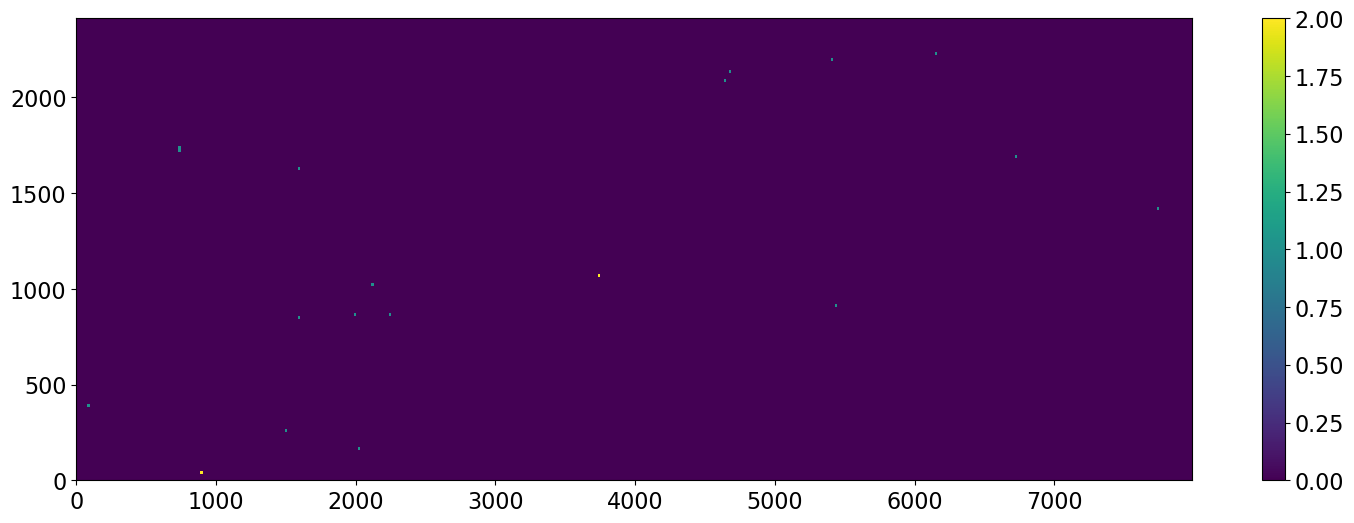

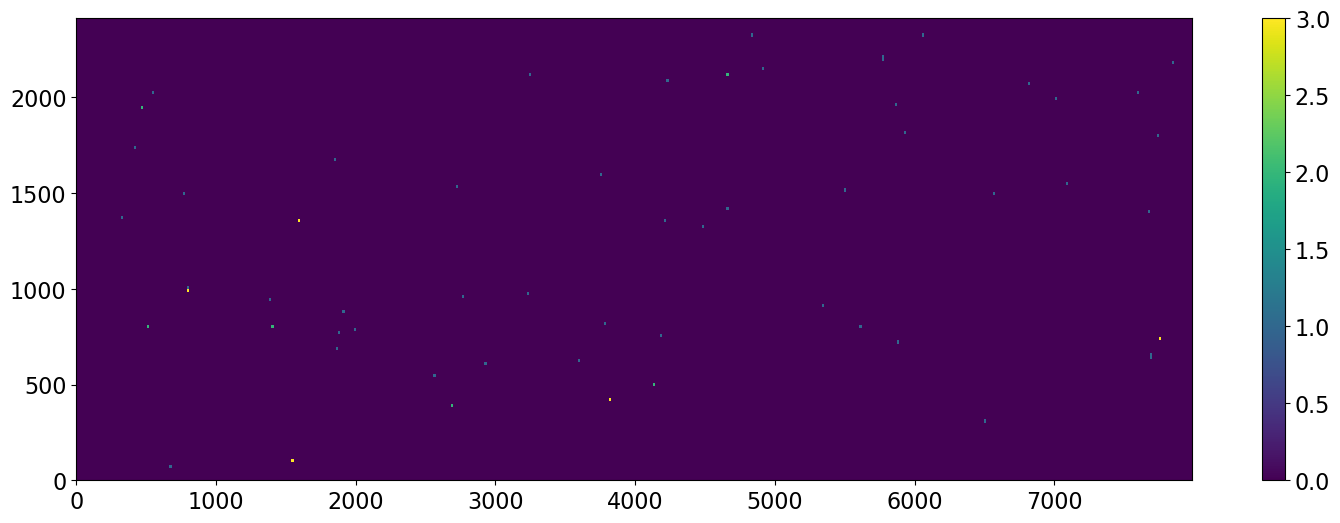

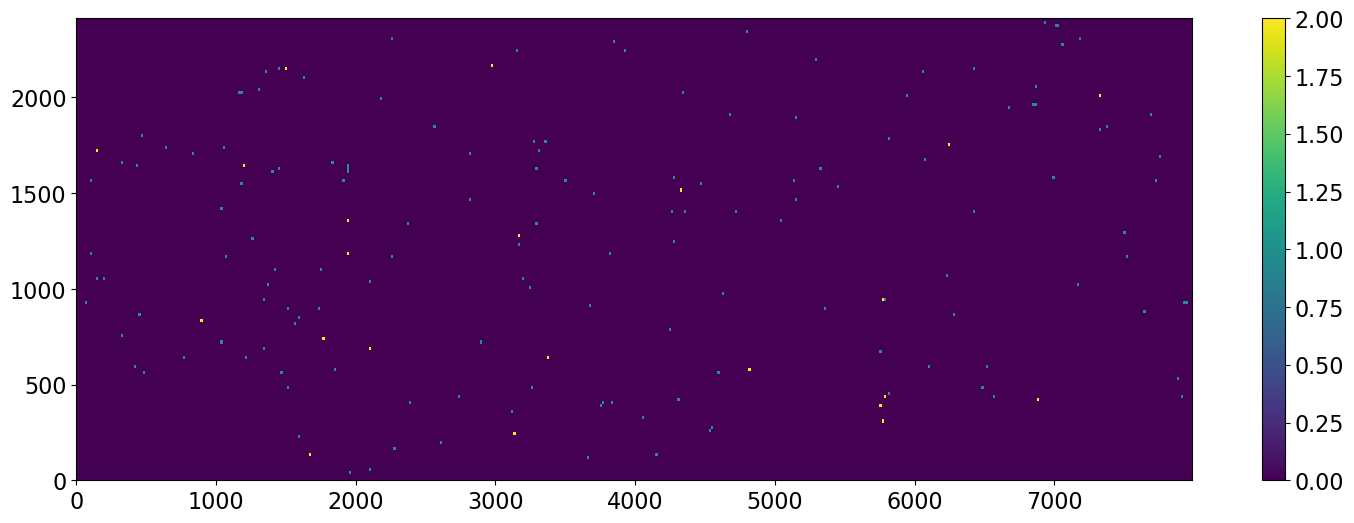

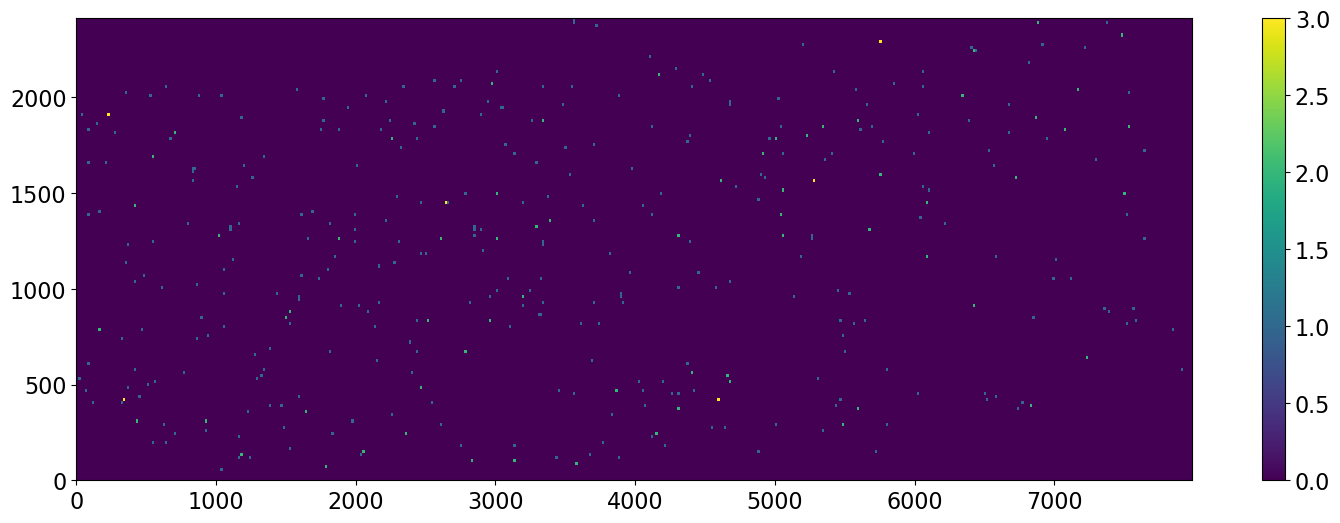

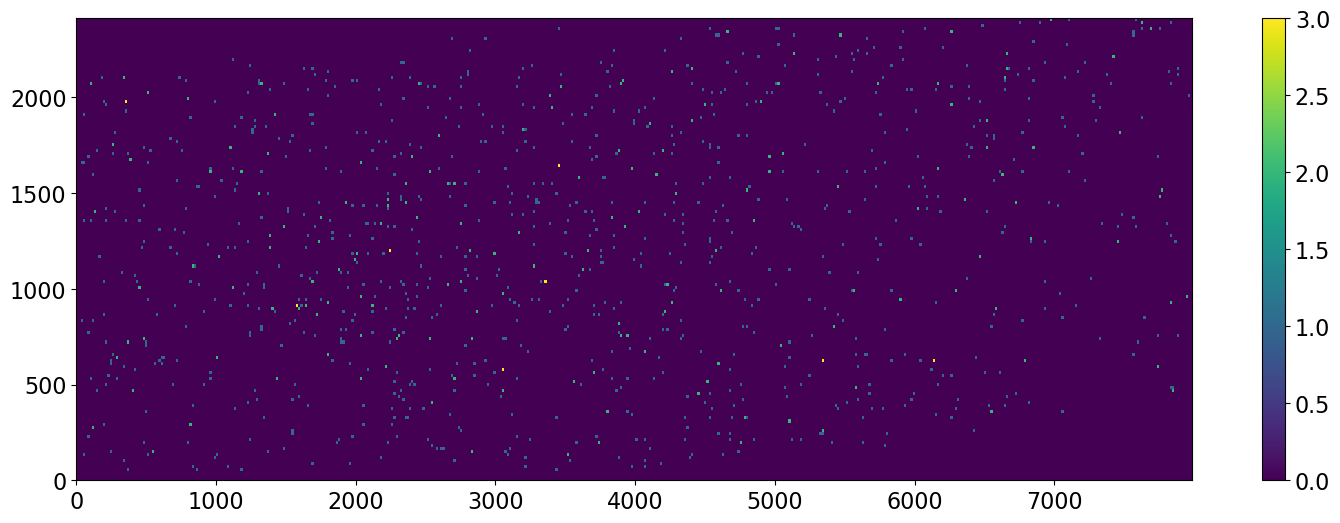

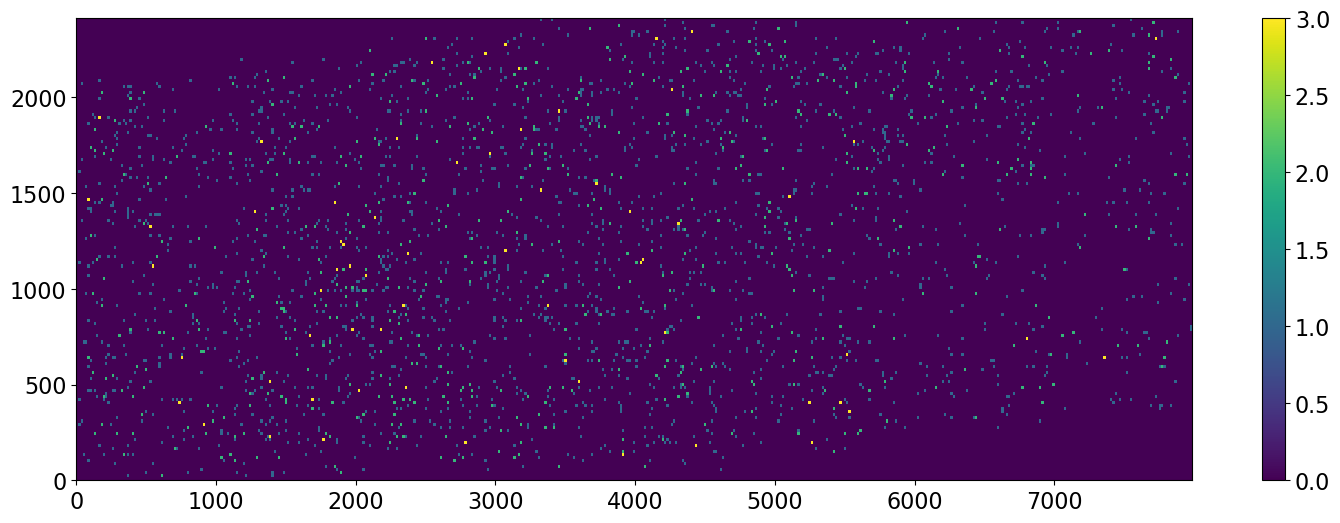

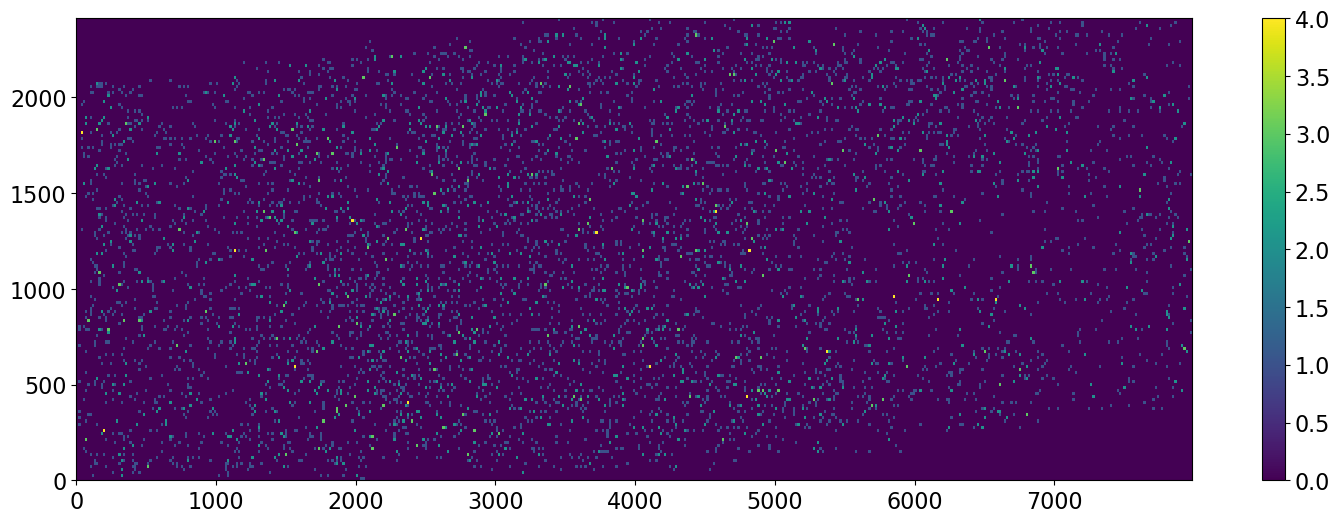

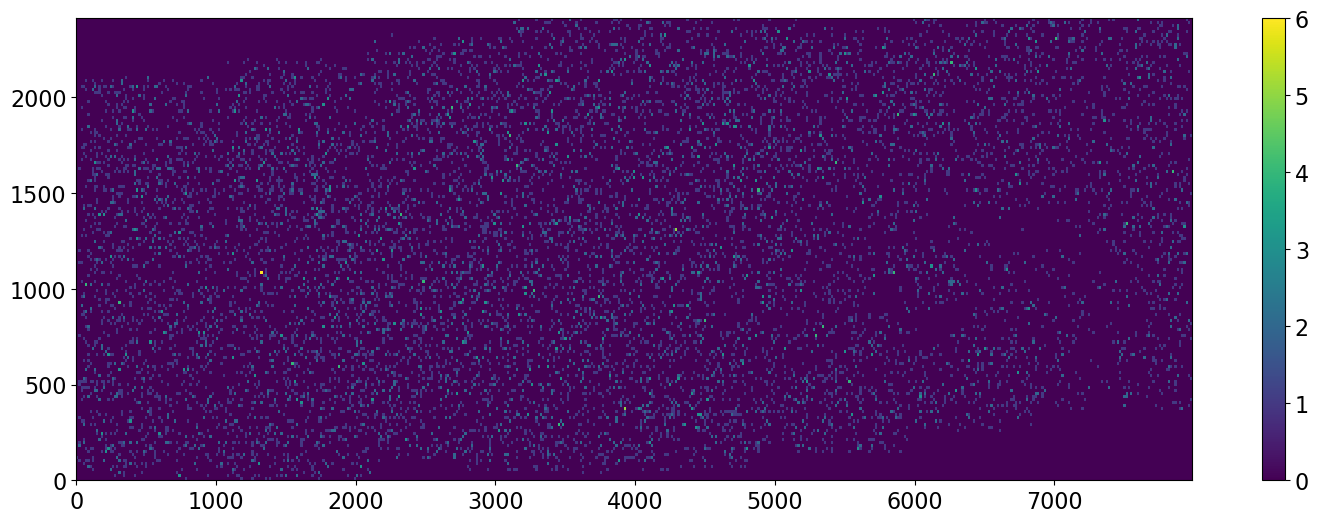

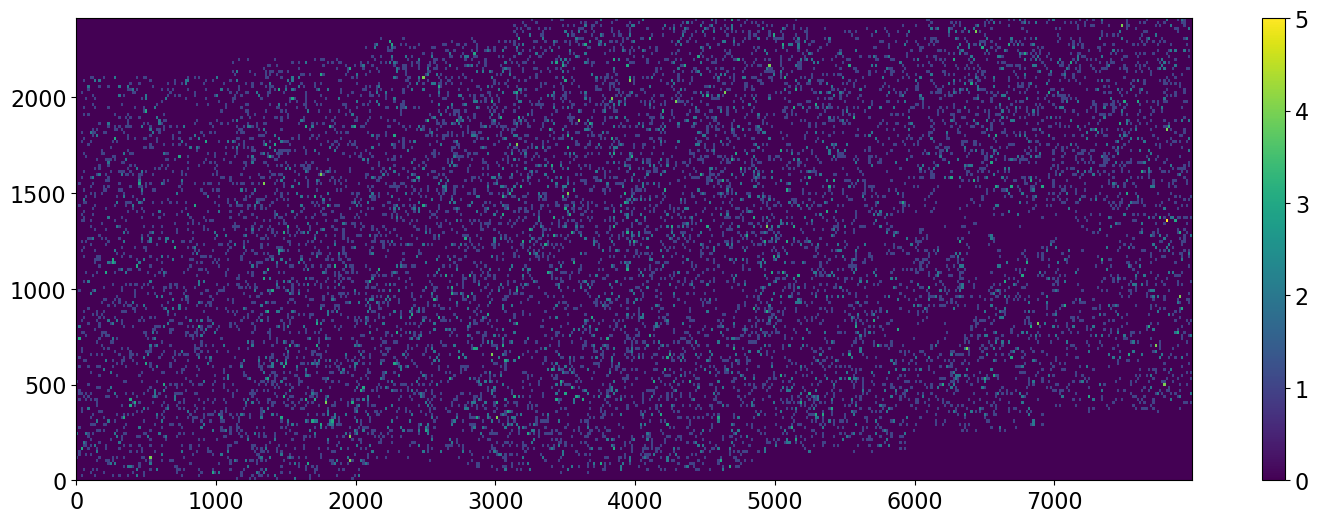

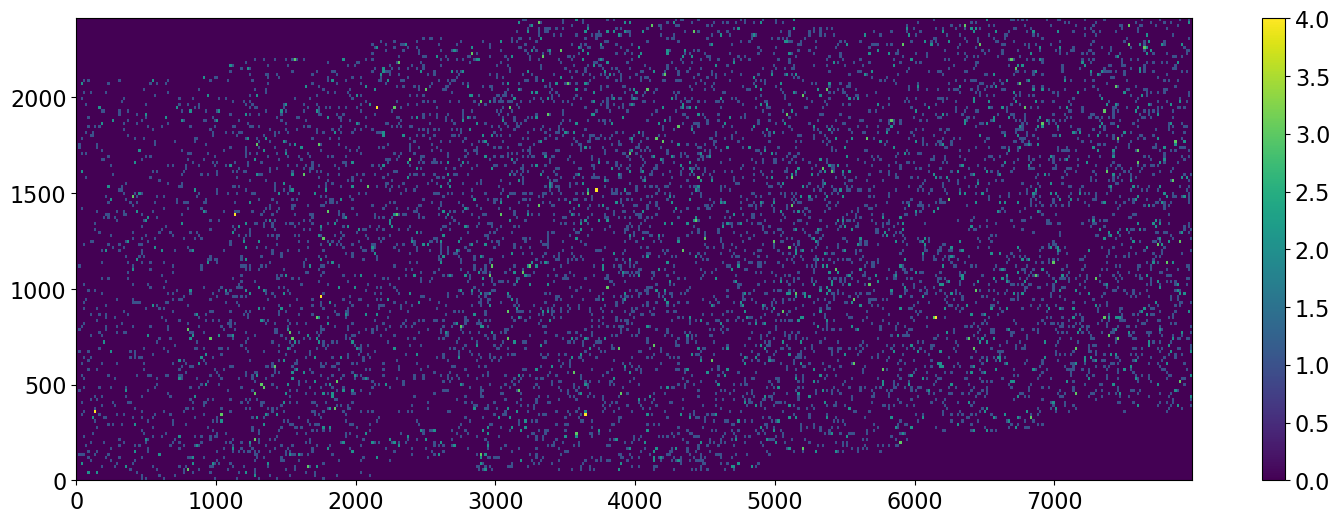

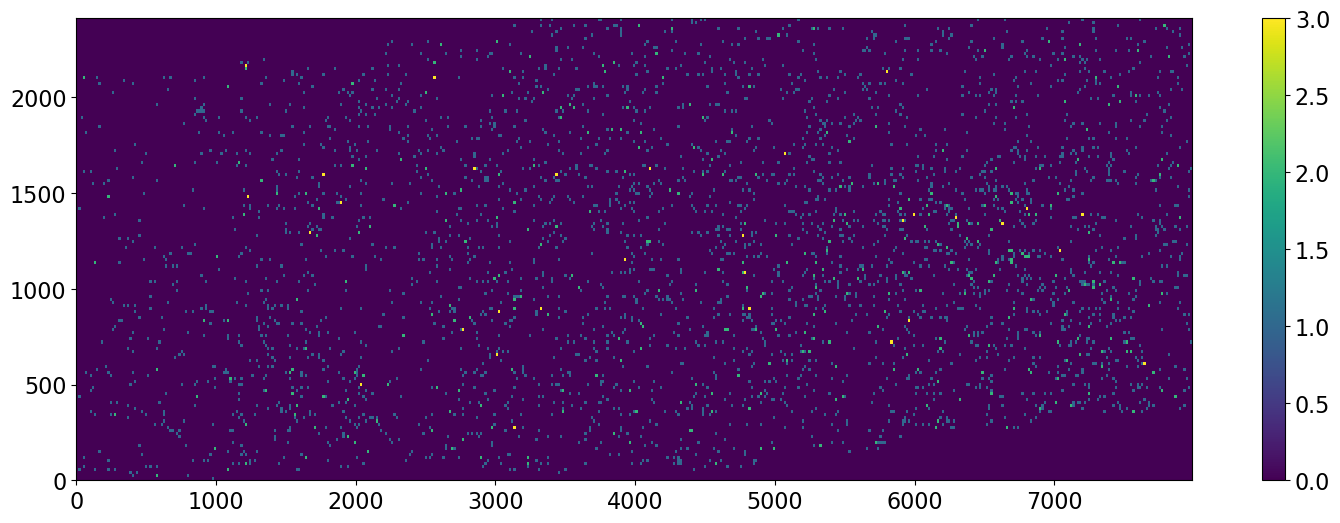

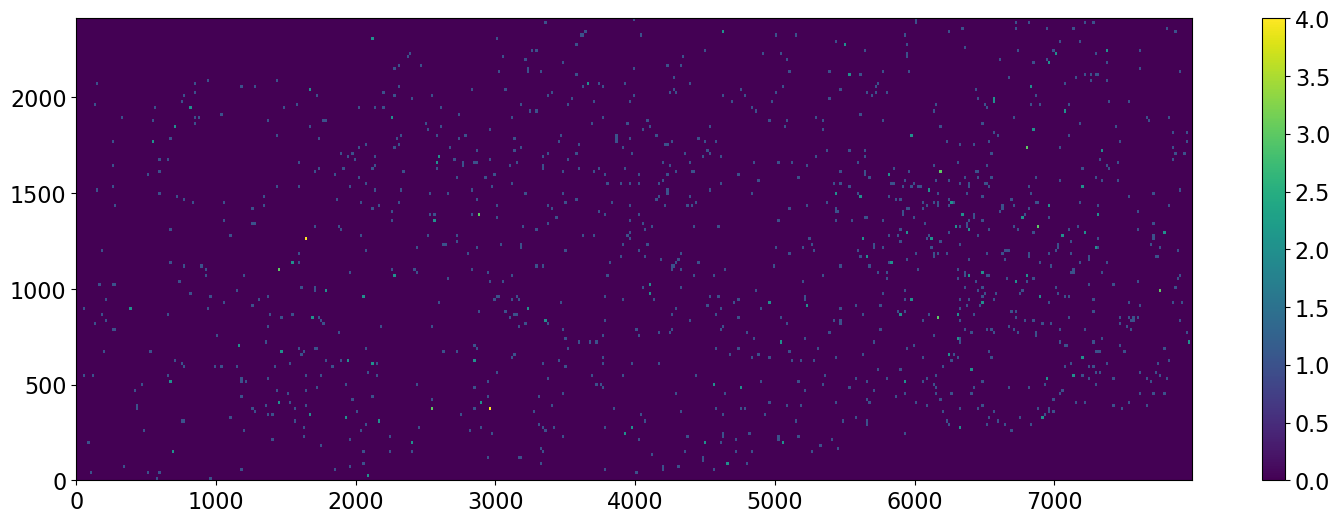

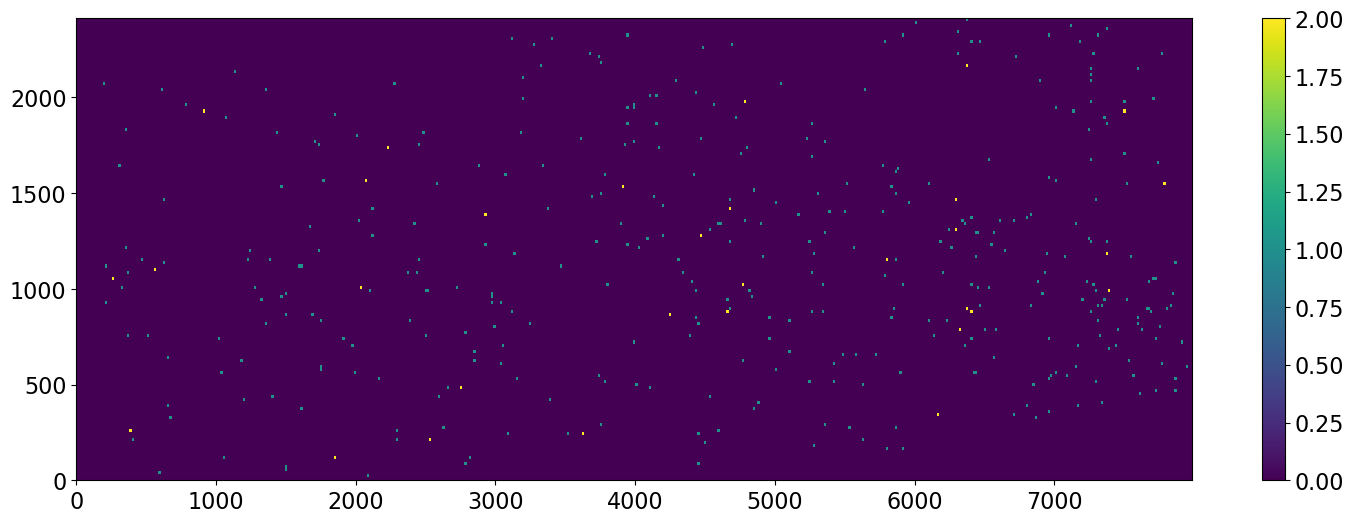

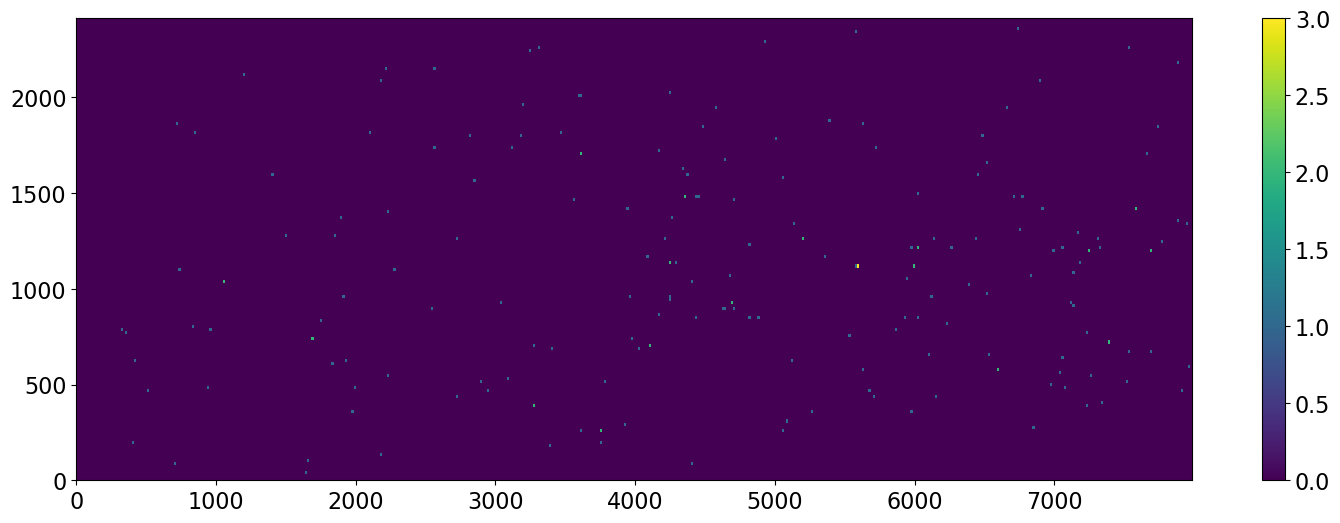

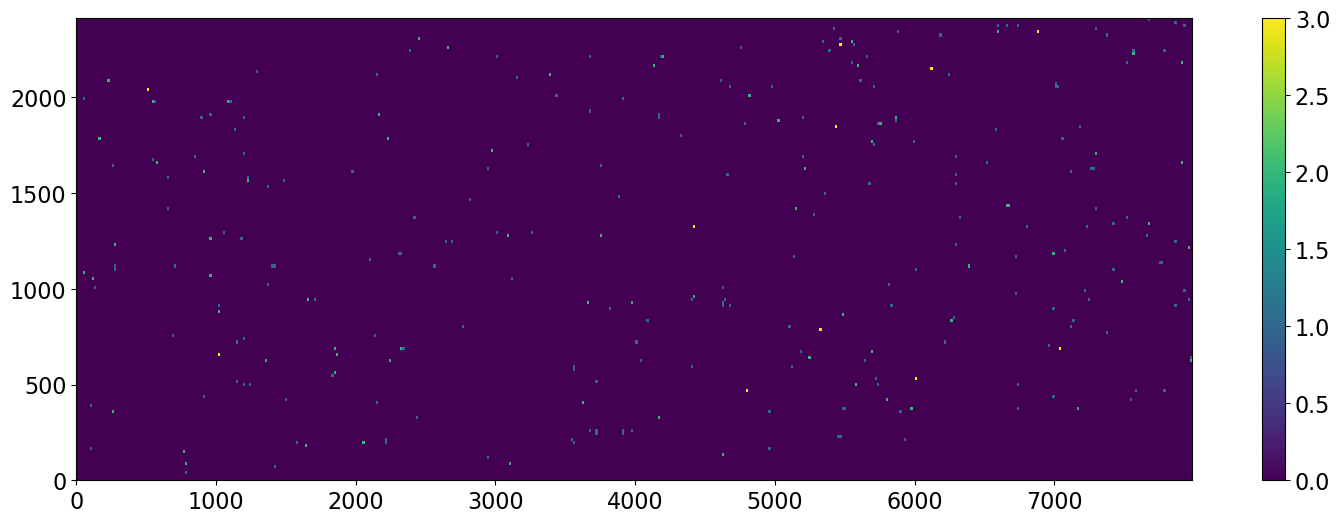

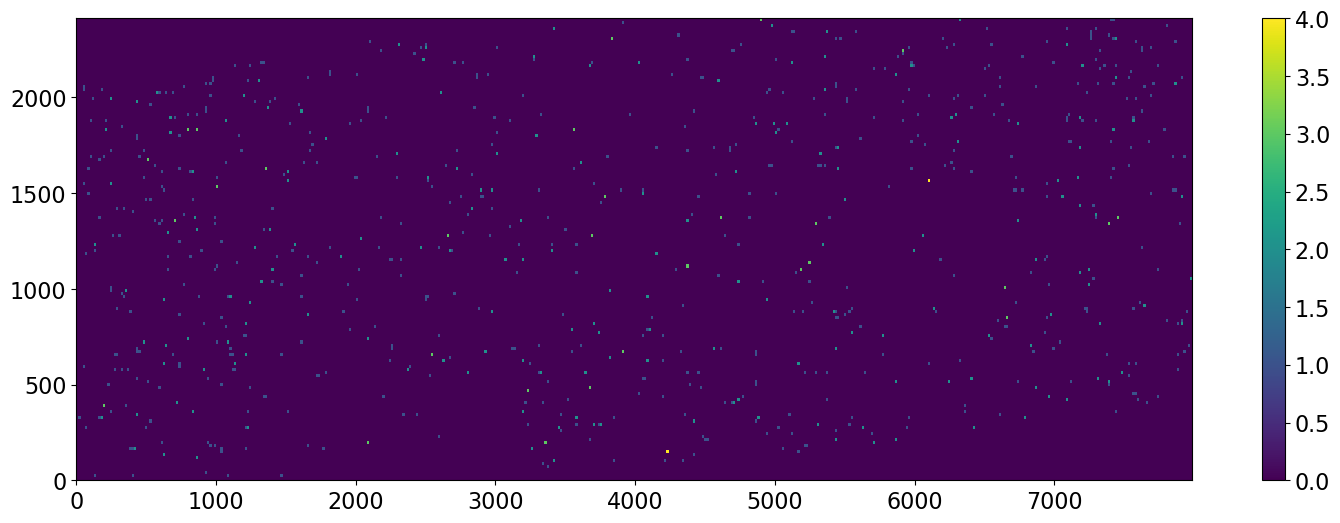

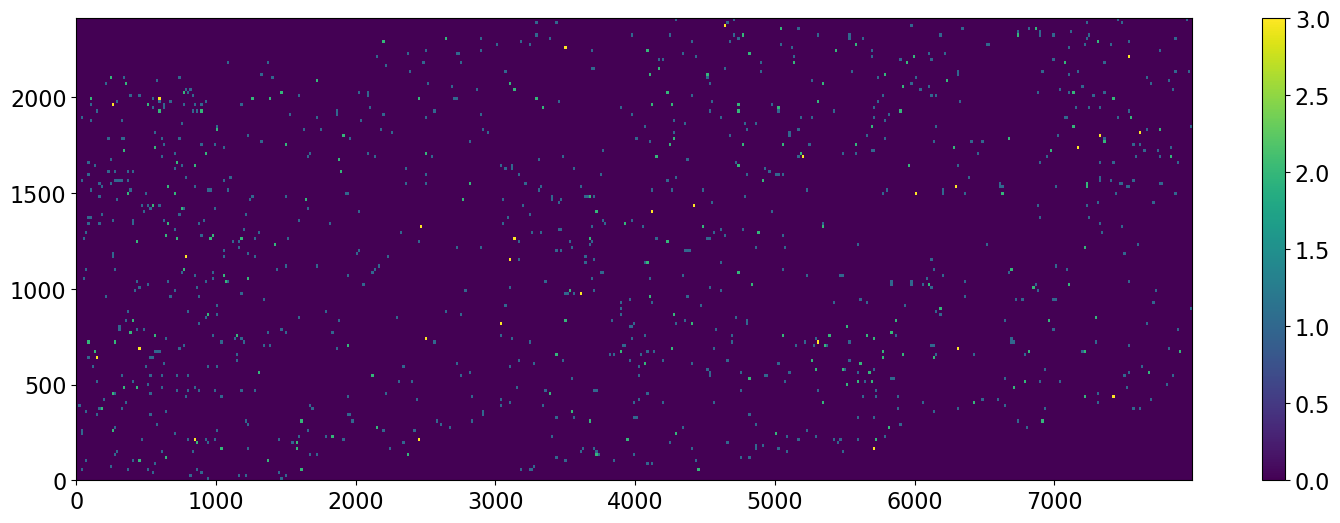

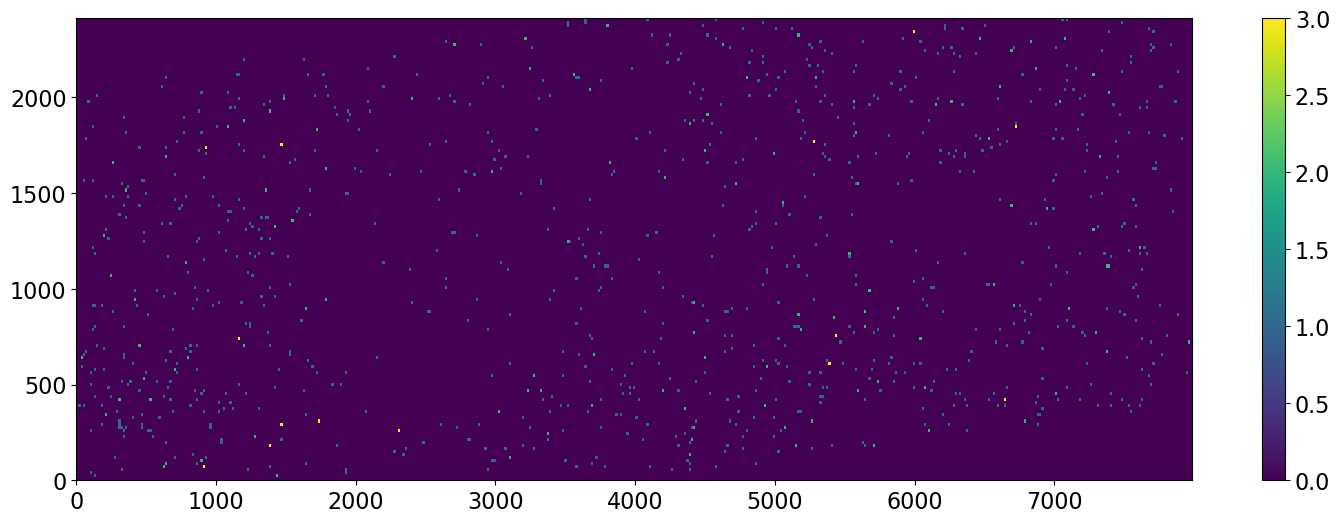

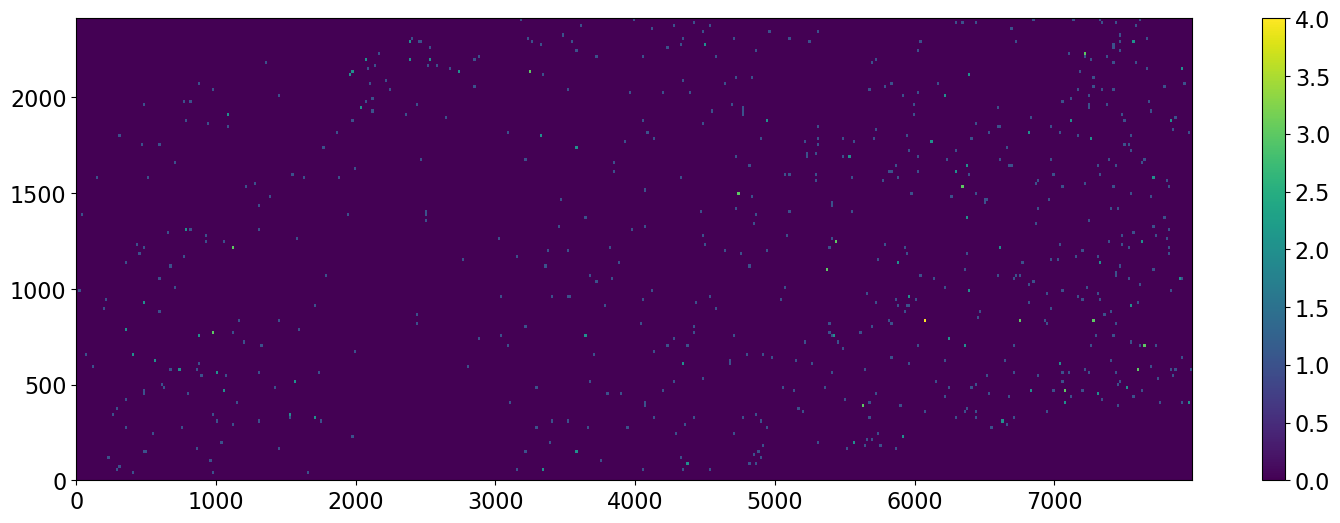

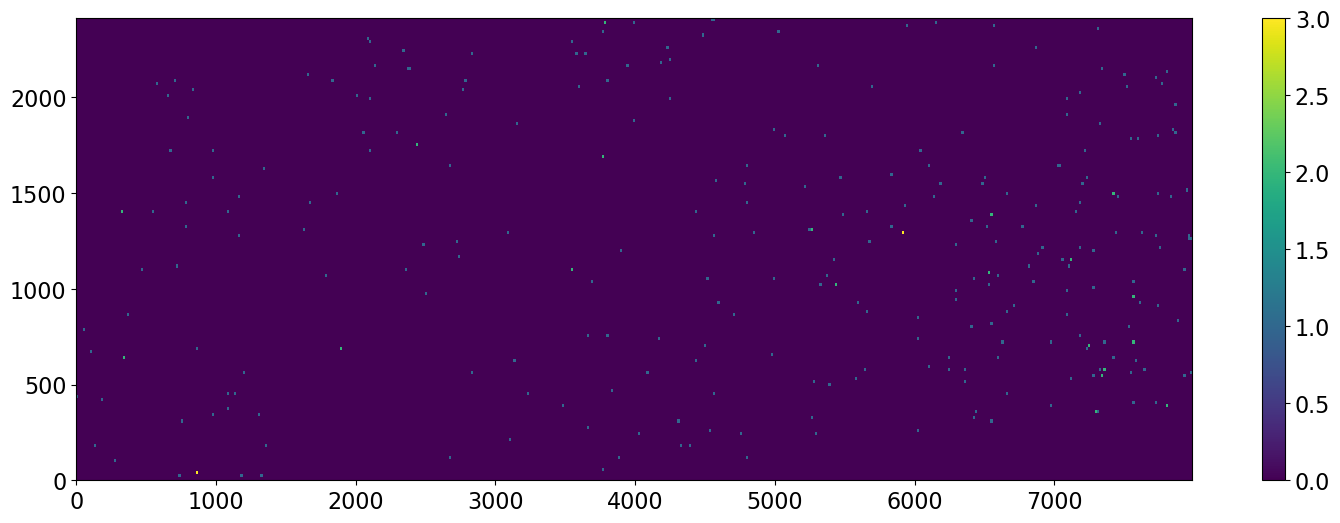

In [80]:
ac1_cube = make_cube(basetable, ww, hdu, dx=1, blur=False)

ac1_cube.writeto('/orange/adamginsburg/jwst/cloudc/images/star_density_color_cube_1ac2.fits', overwrite=True)

2024-05-29 12:58:18,872 - stpipe - WARNING - /scratch/local/32804124/ipykernel_1081337/158456792.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))



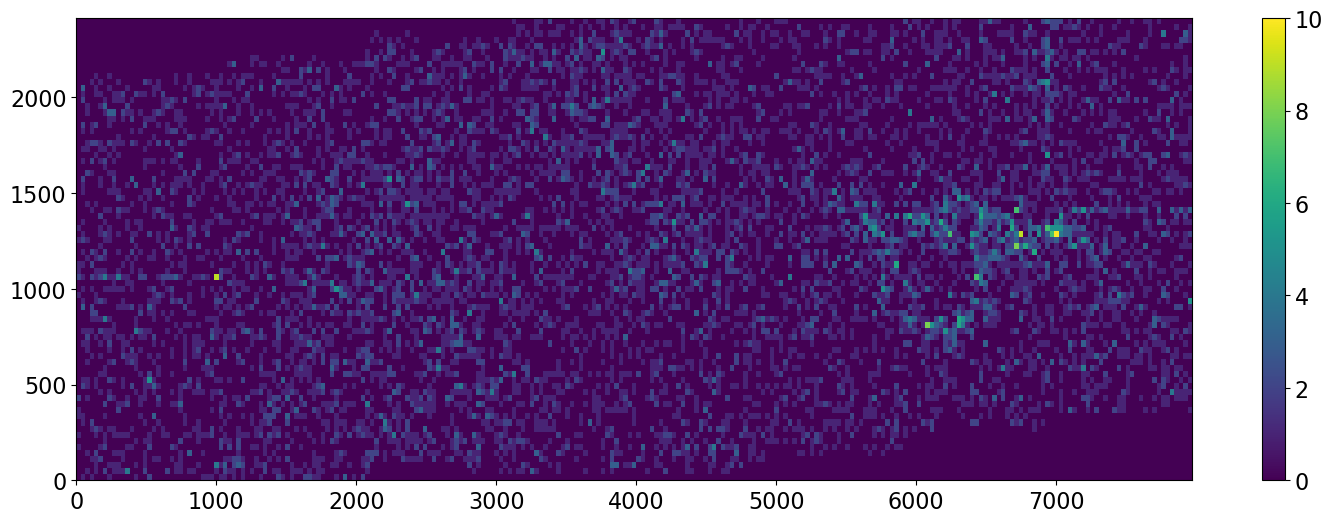

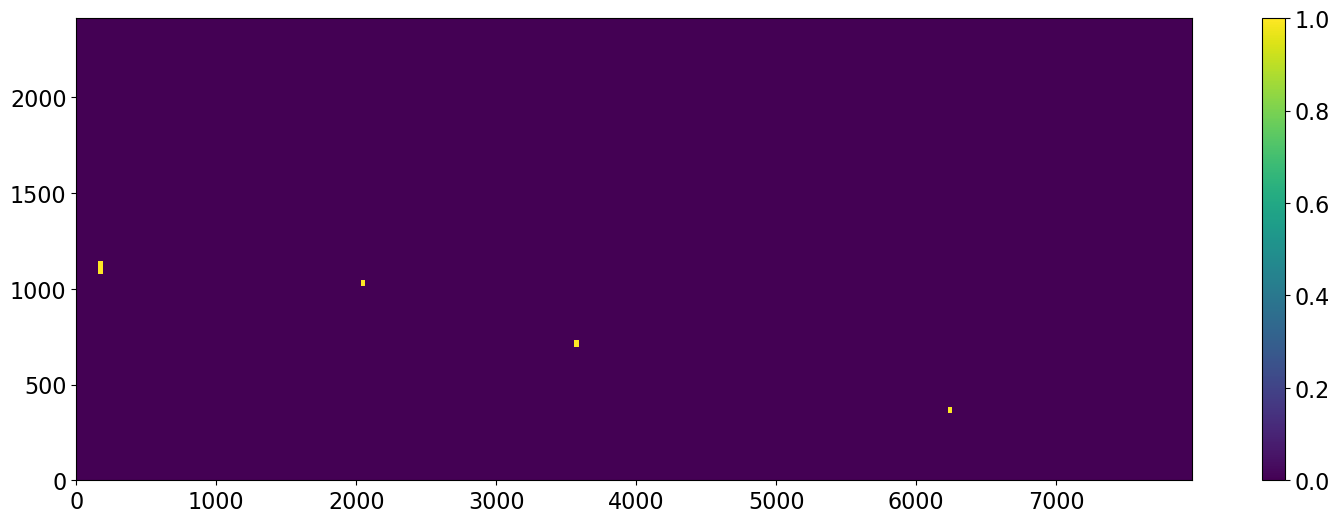

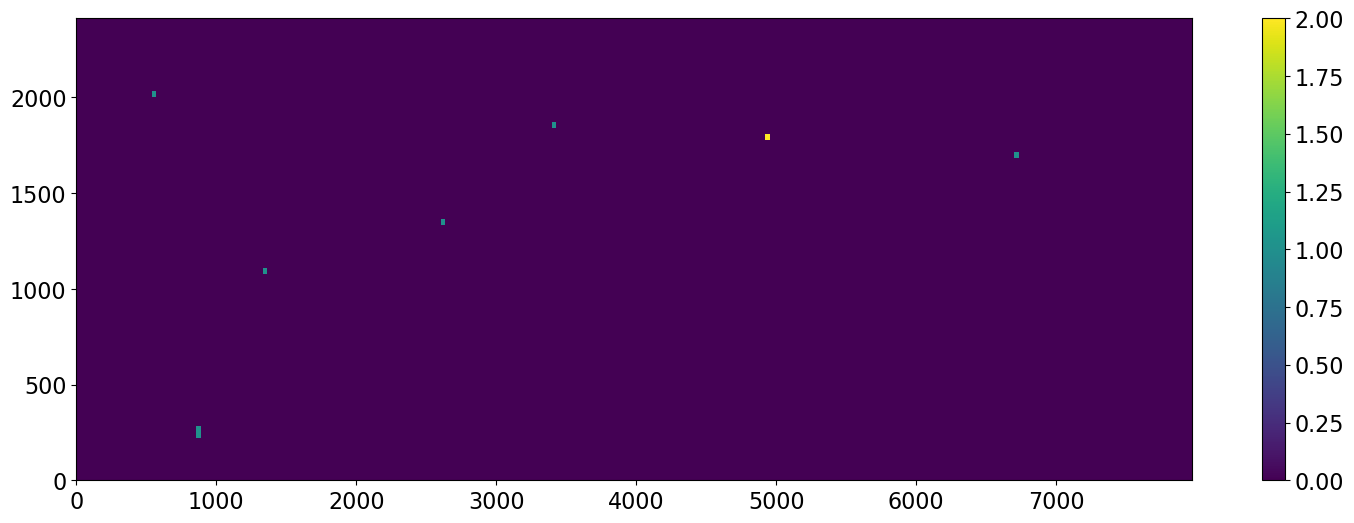

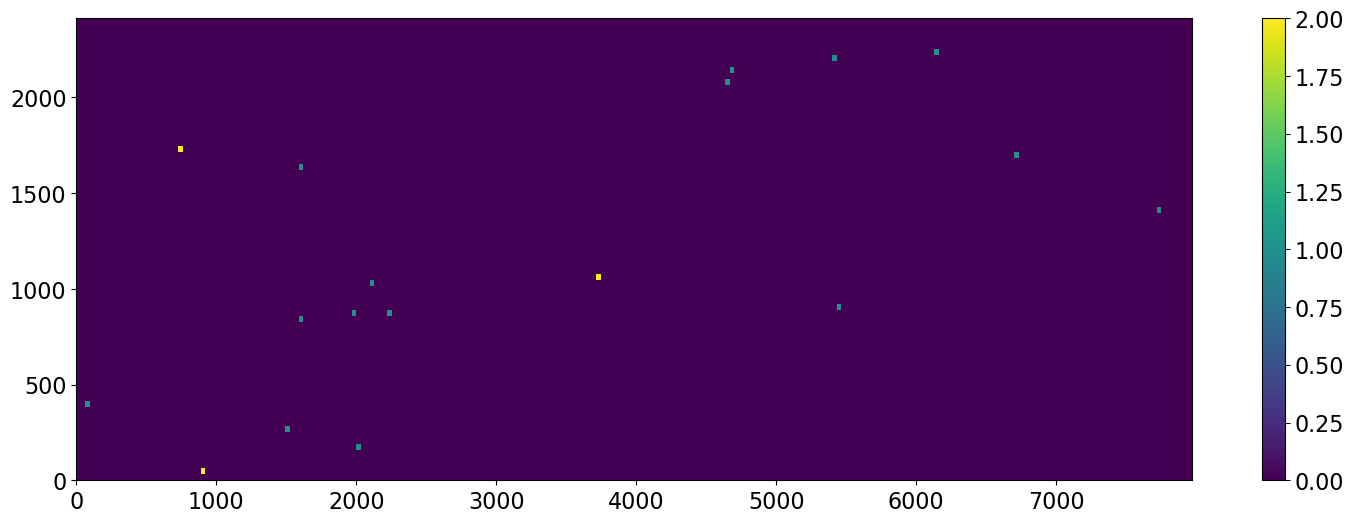

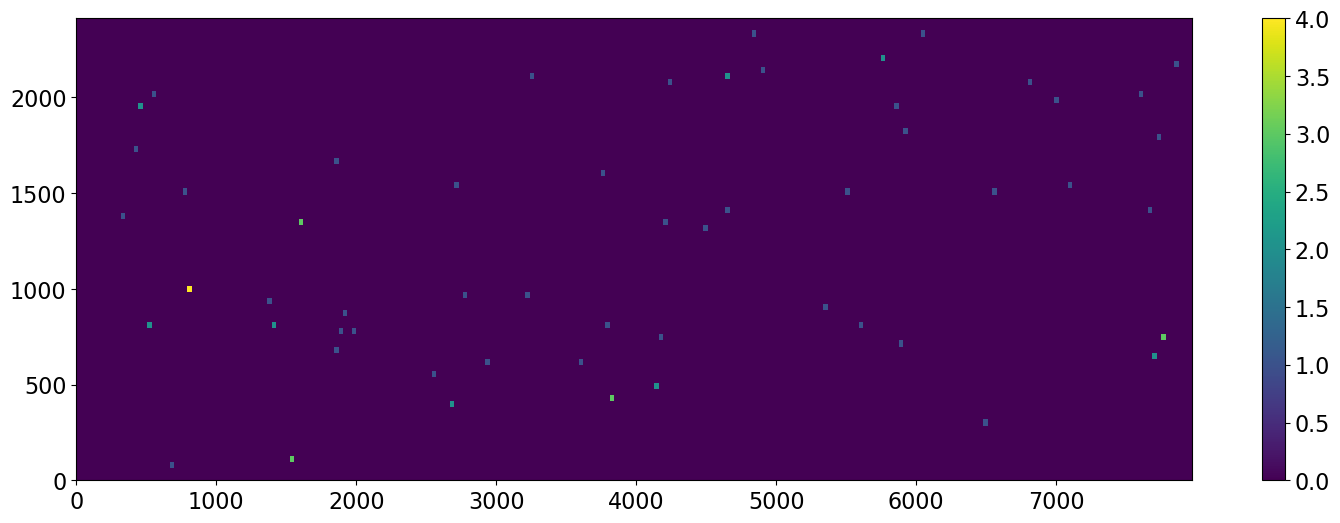

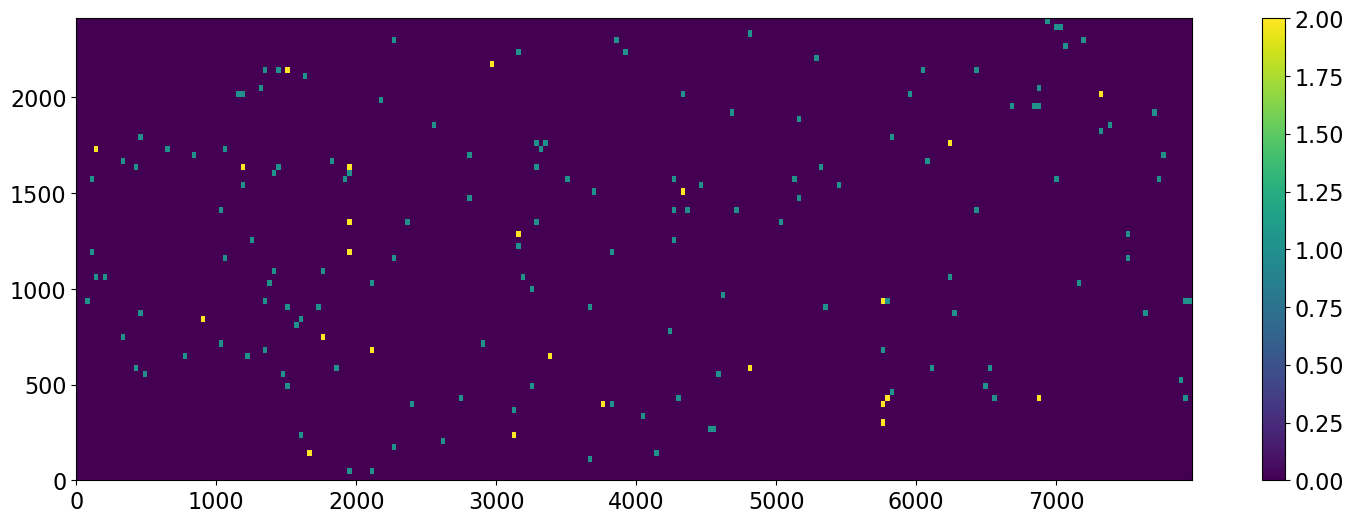

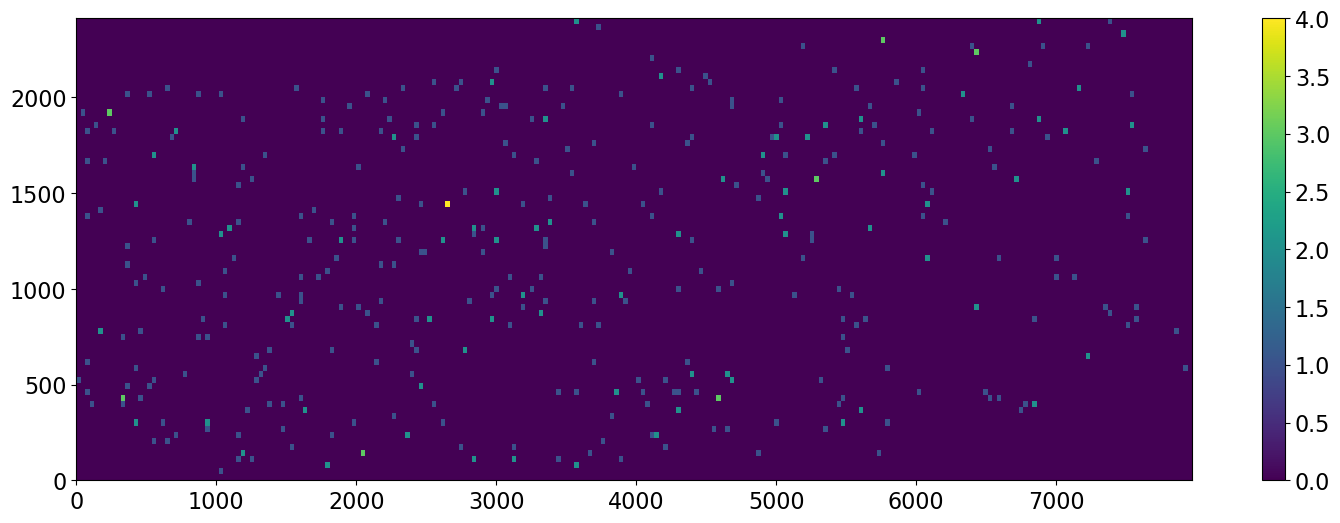

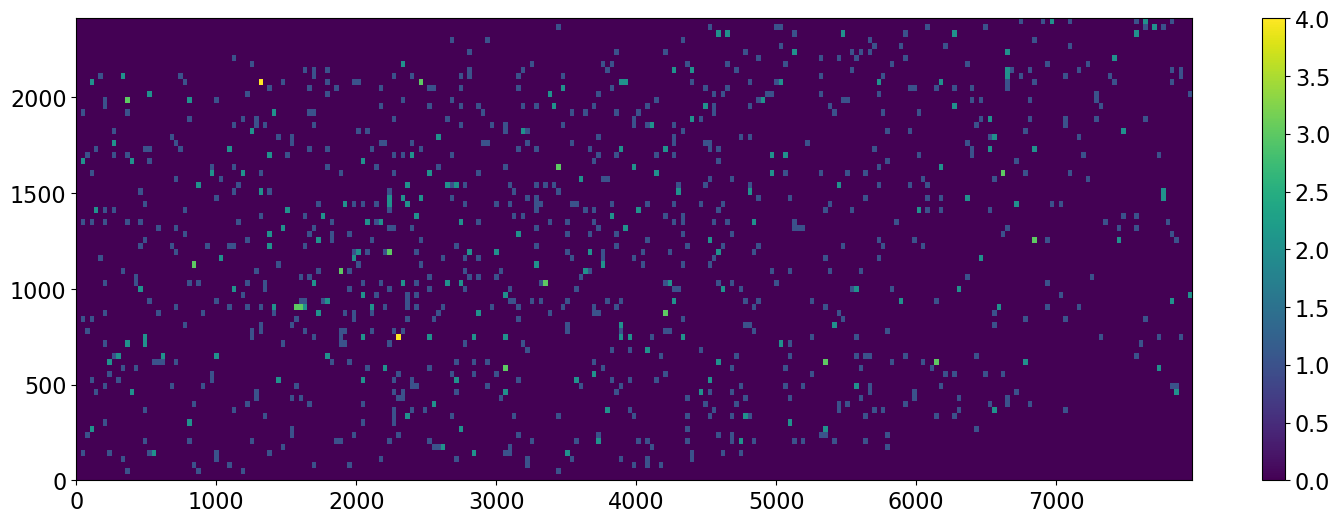

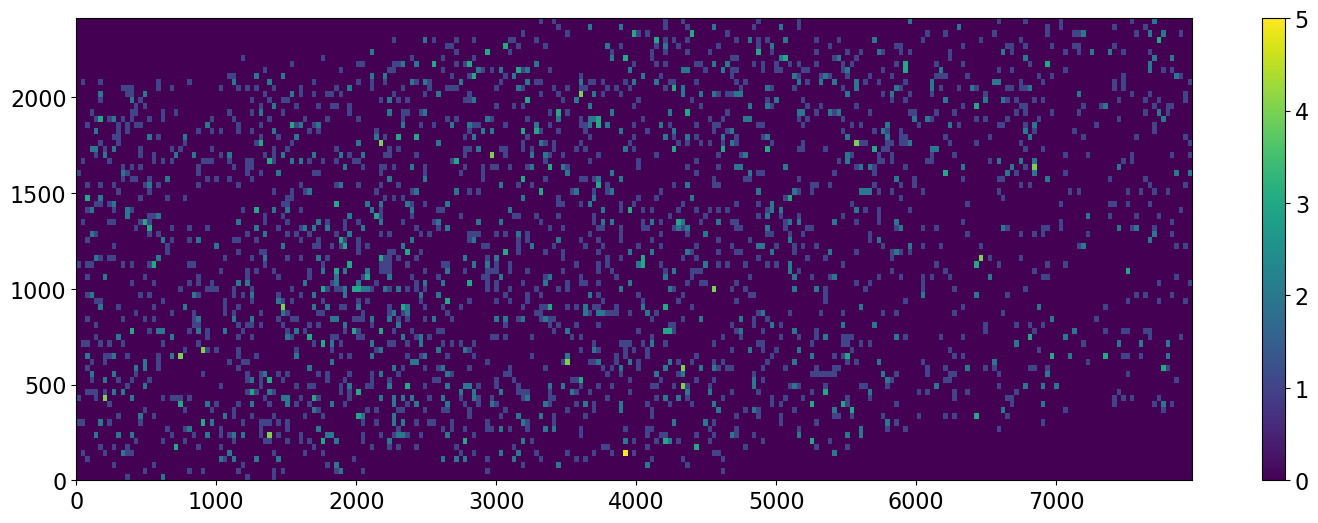

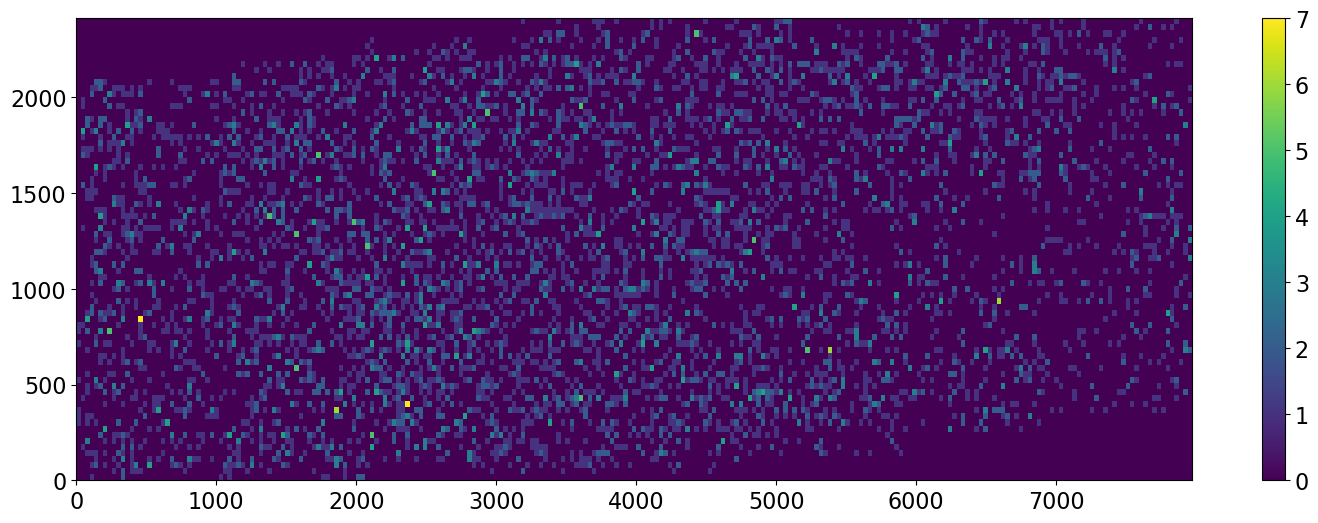

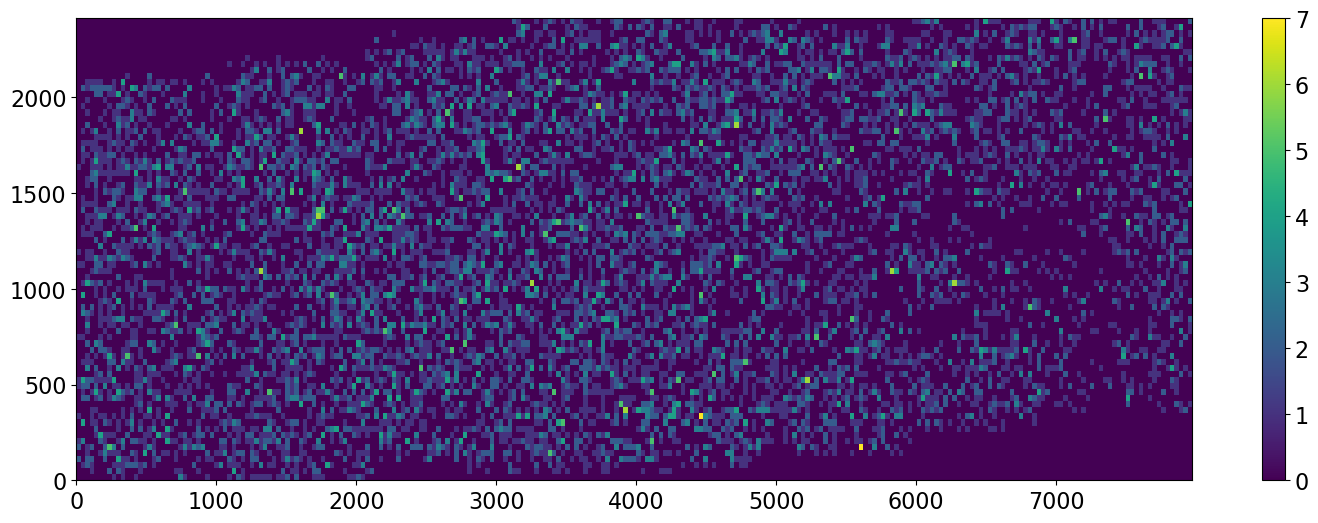

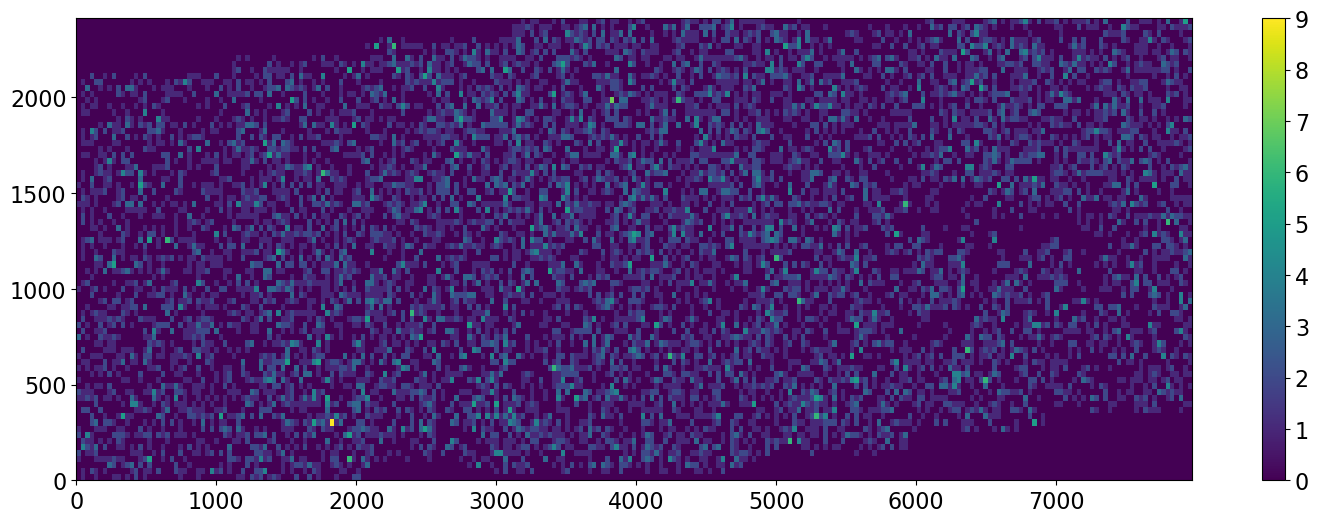

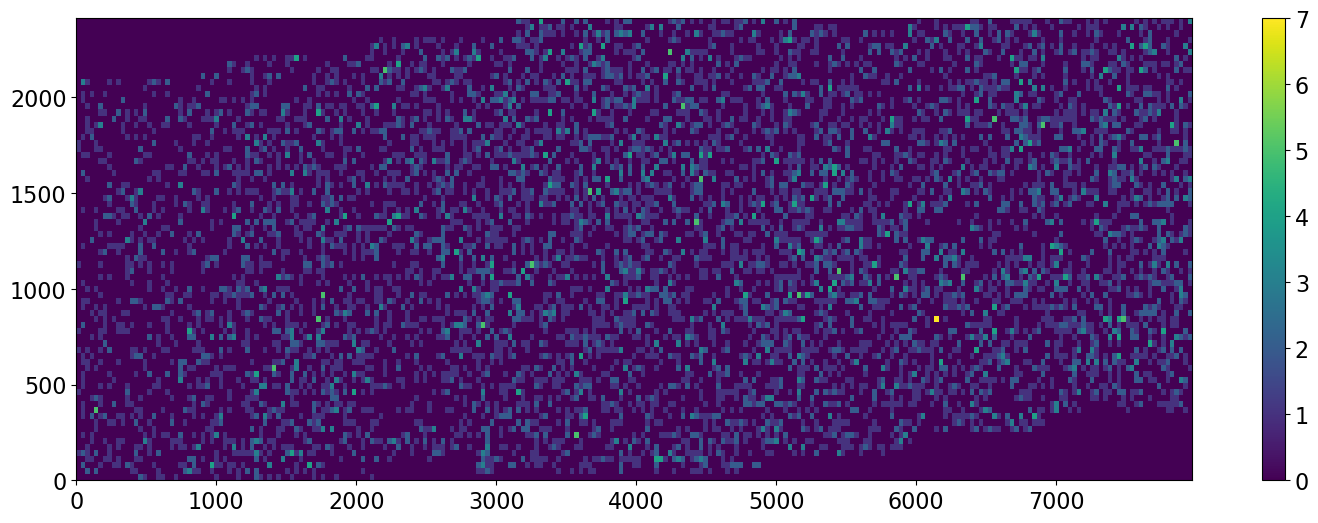

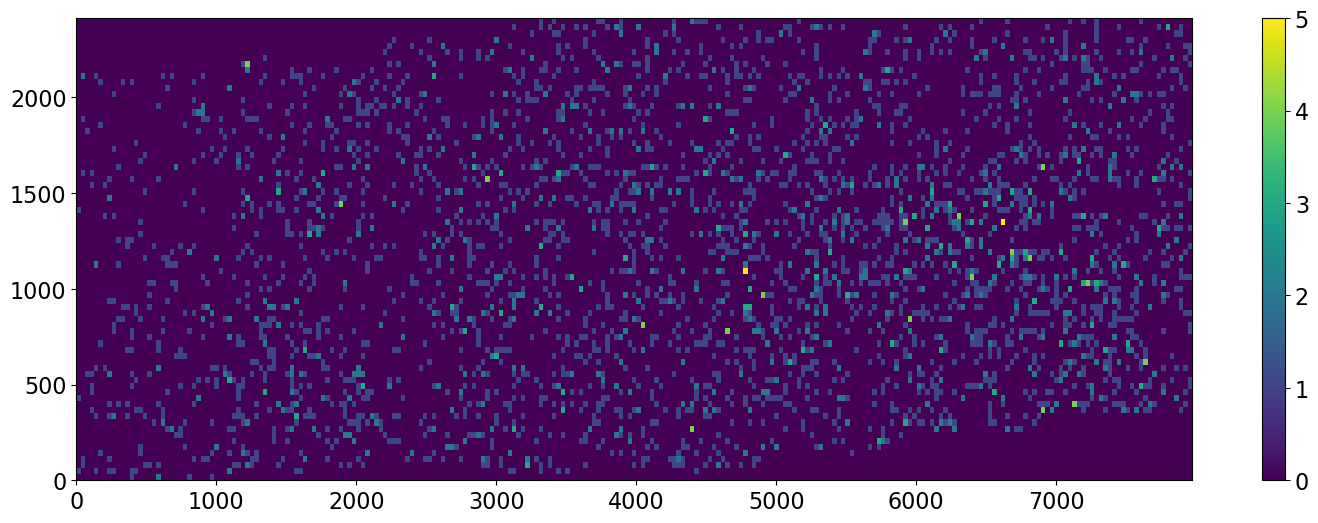

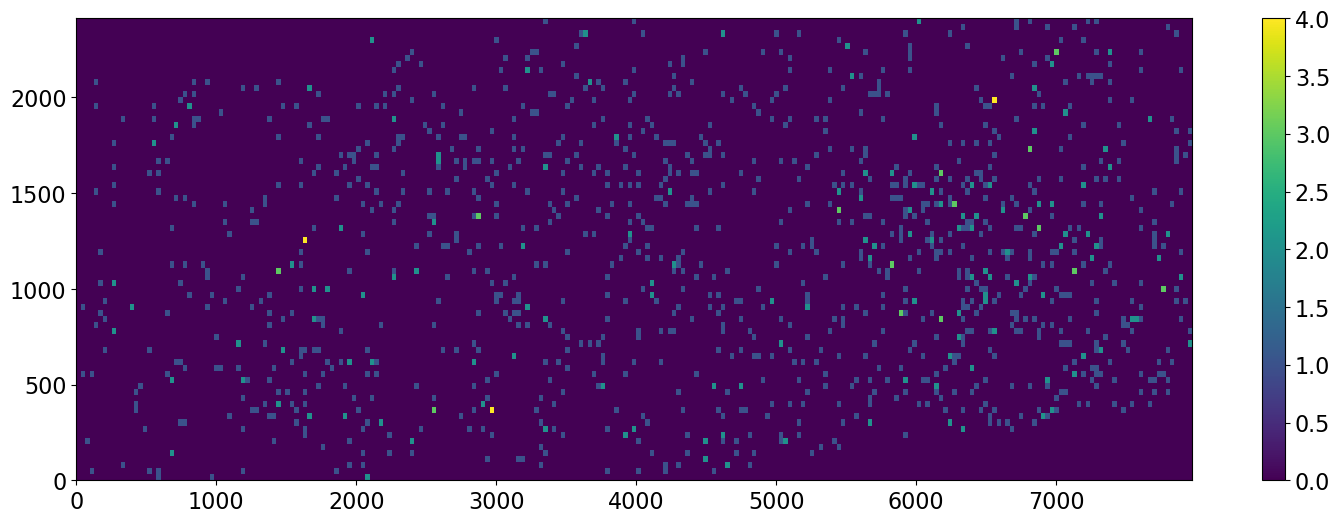

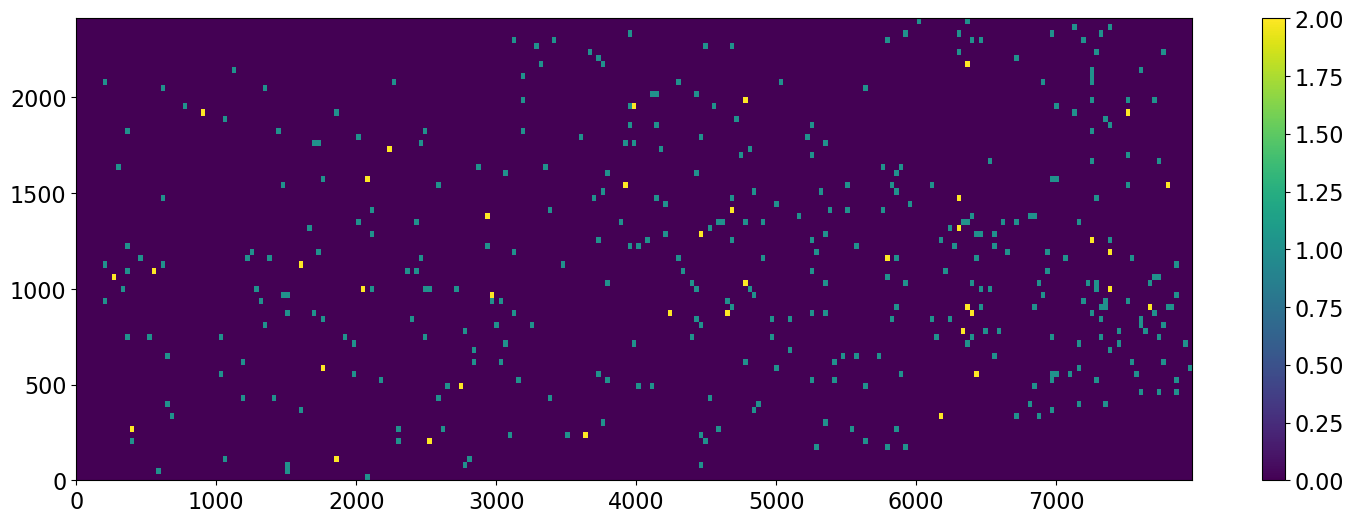

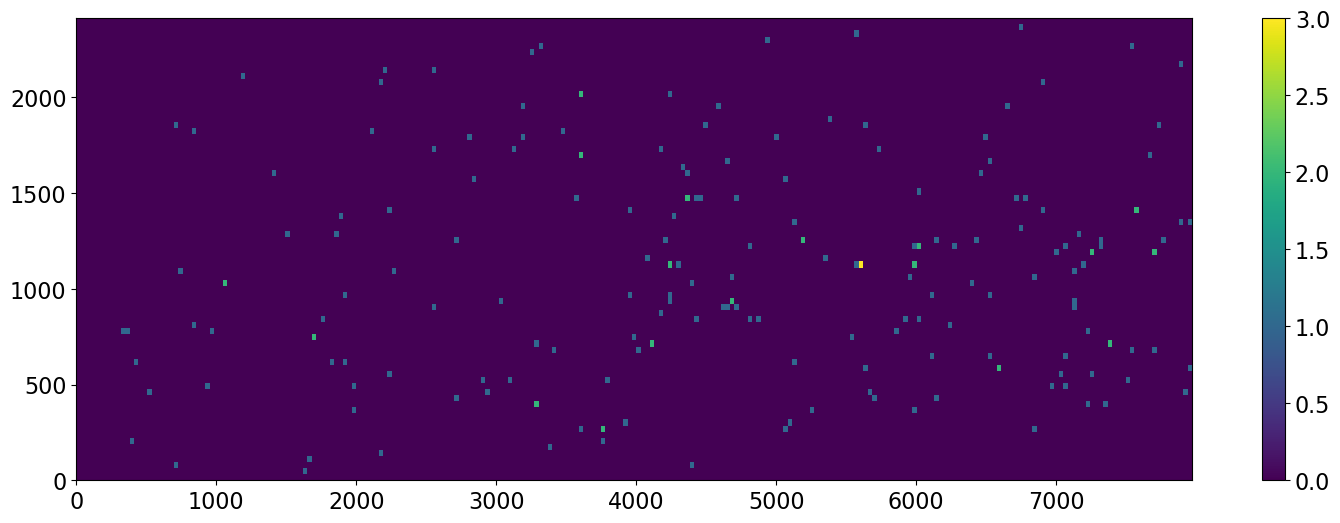

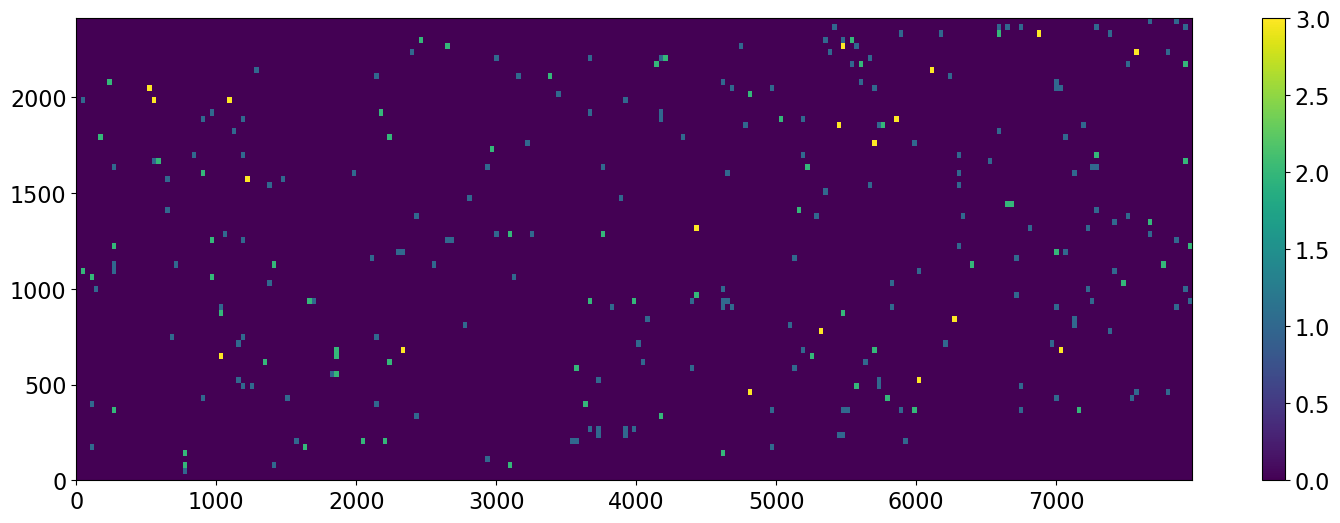

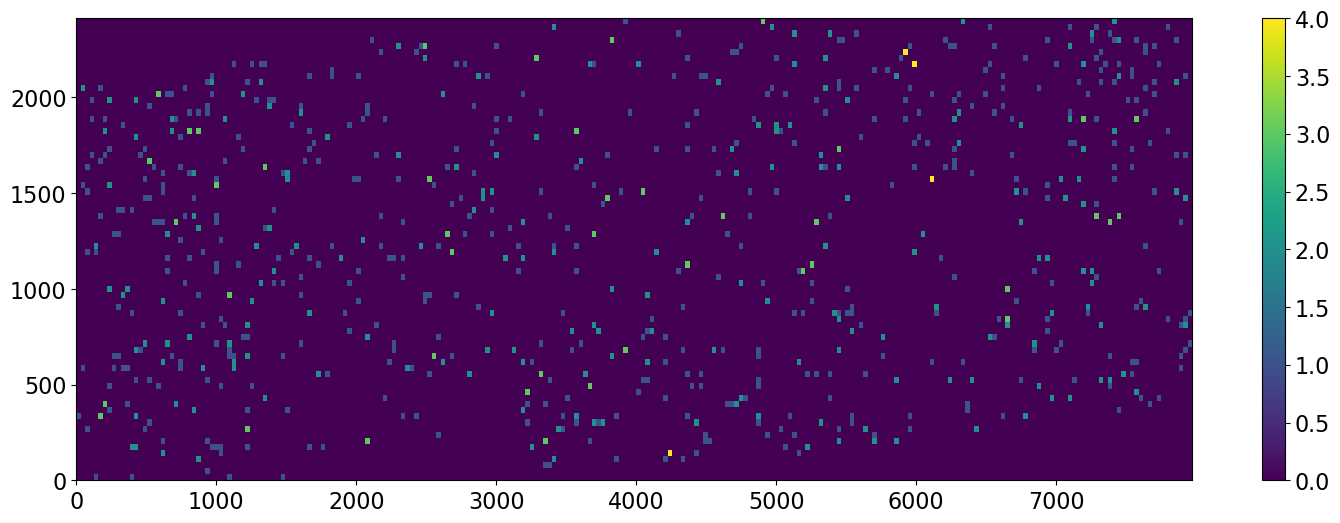

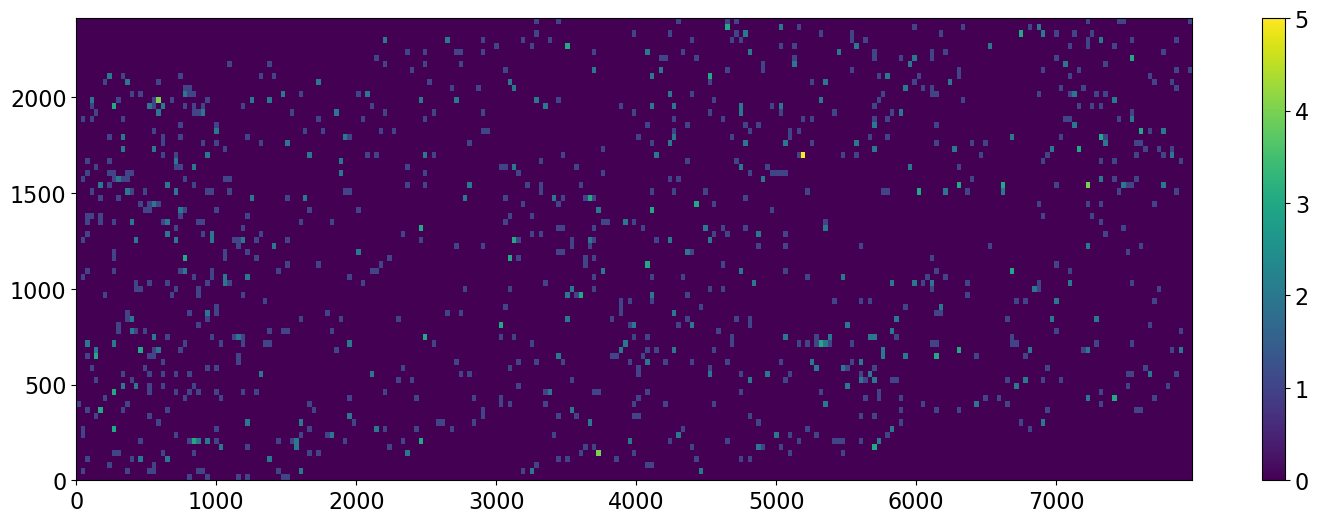

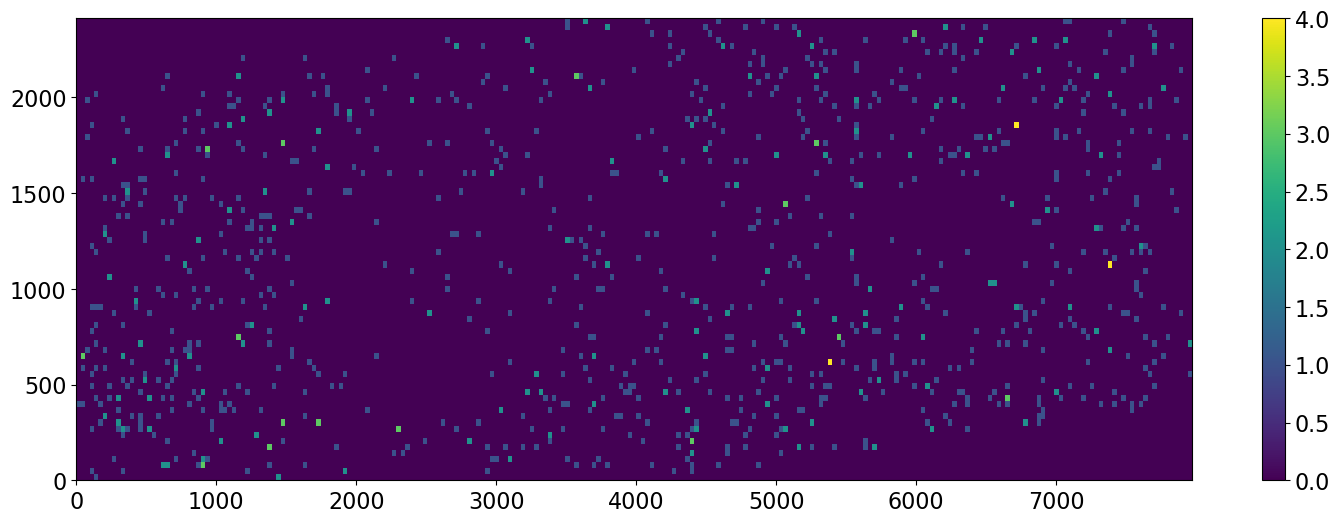

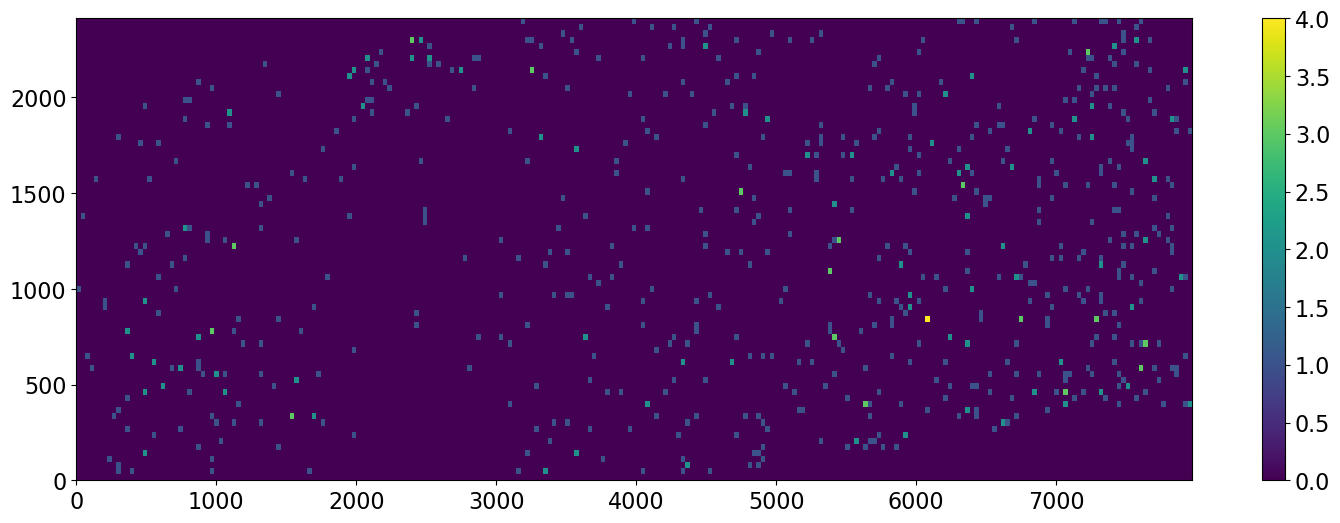

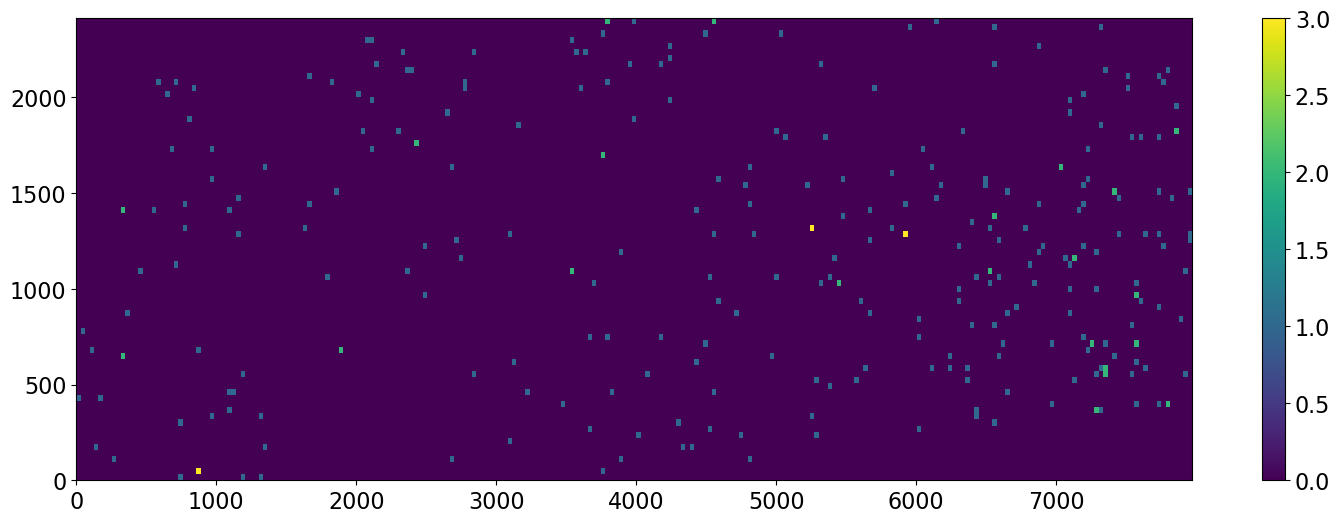

In [81]:
ac2_cube = make_cube(basetable, ww, hdu, dx=2, blur=False)

ac2_cube.writeto('/orange/adamginsburg/jwst/cloudc/images/star_density_color_cube_4ac2.fits', overwrite=True)

2024-05-29 12:58:27,671 - stpipe - WARNING - /scratch/local/32804124/ipykernel_1081337/158456792.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))



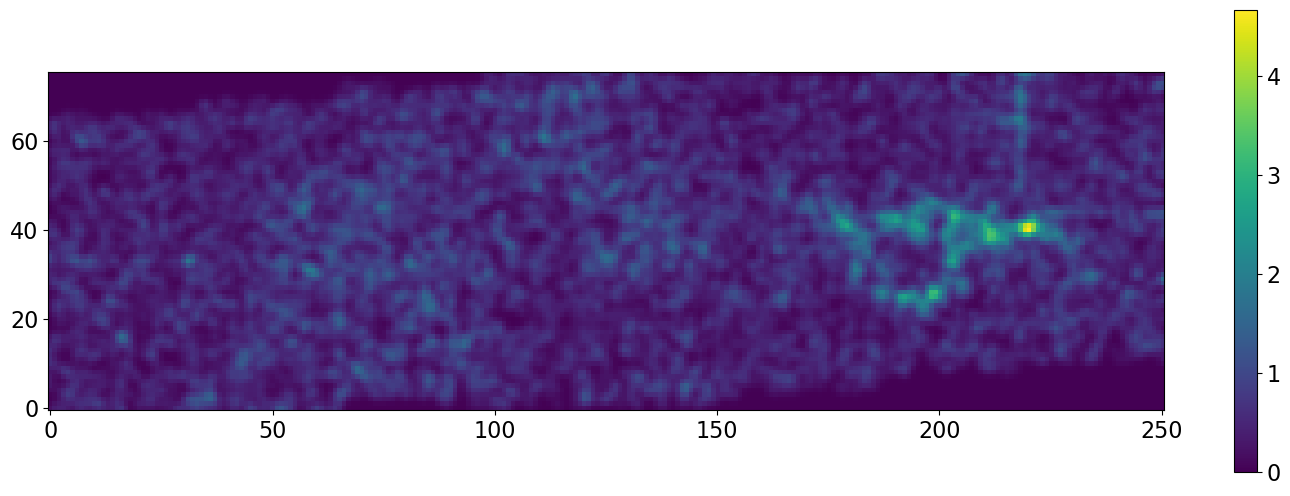

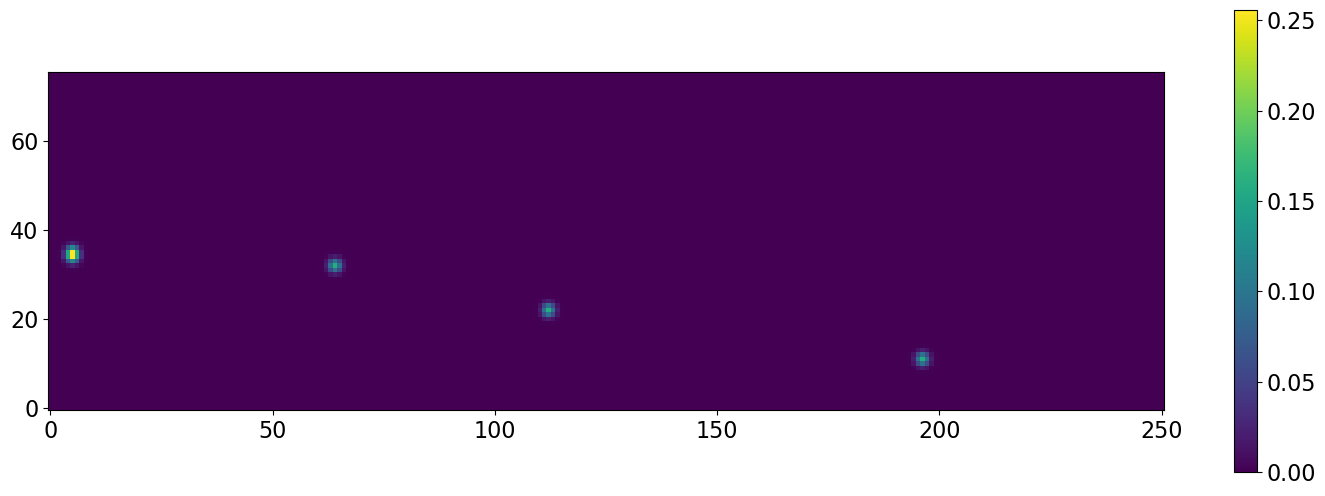

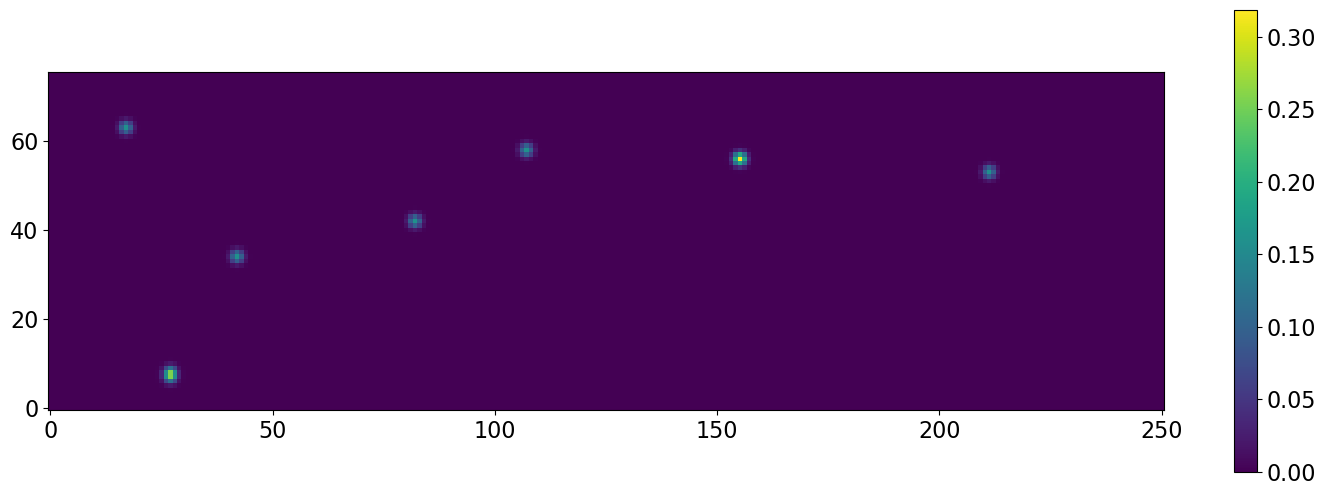

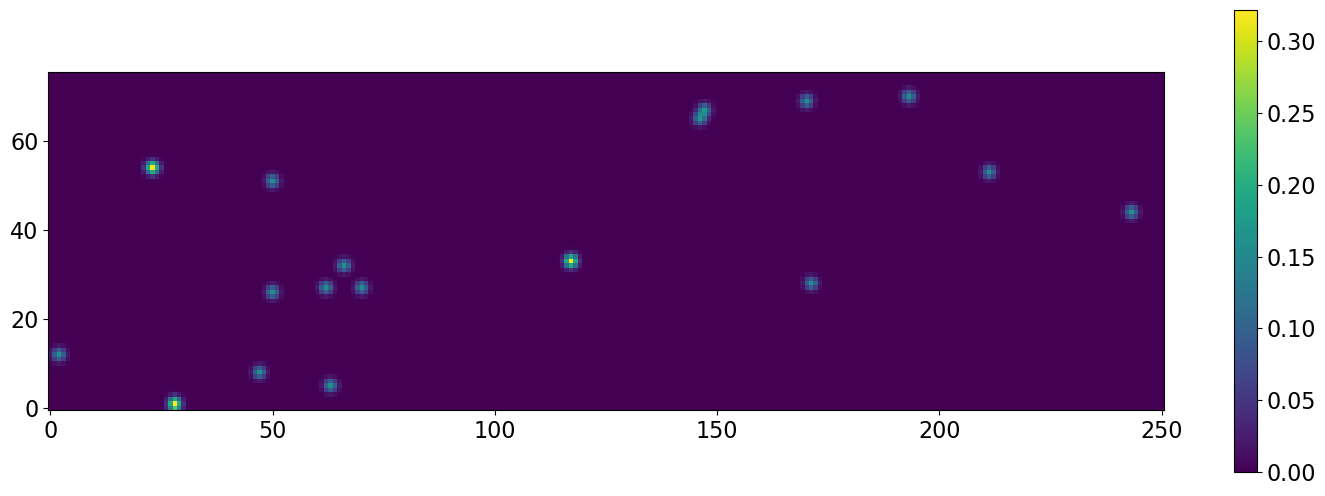

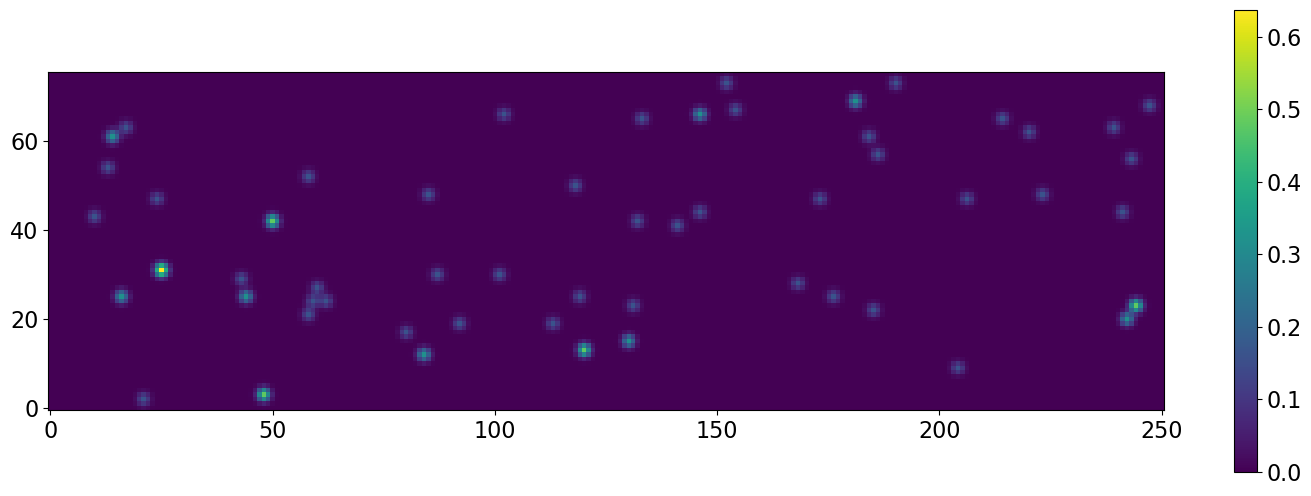

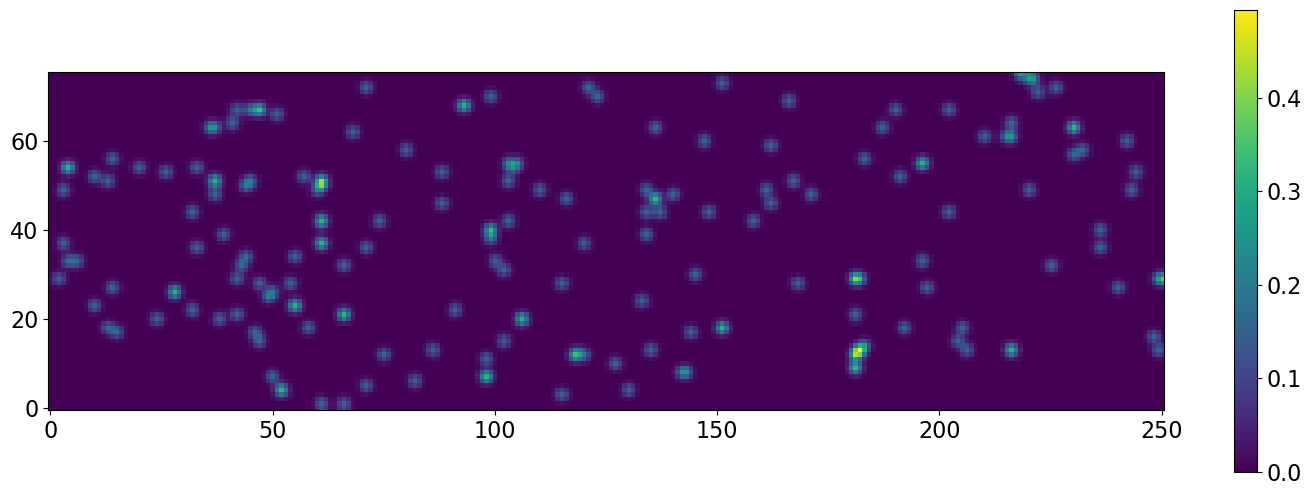

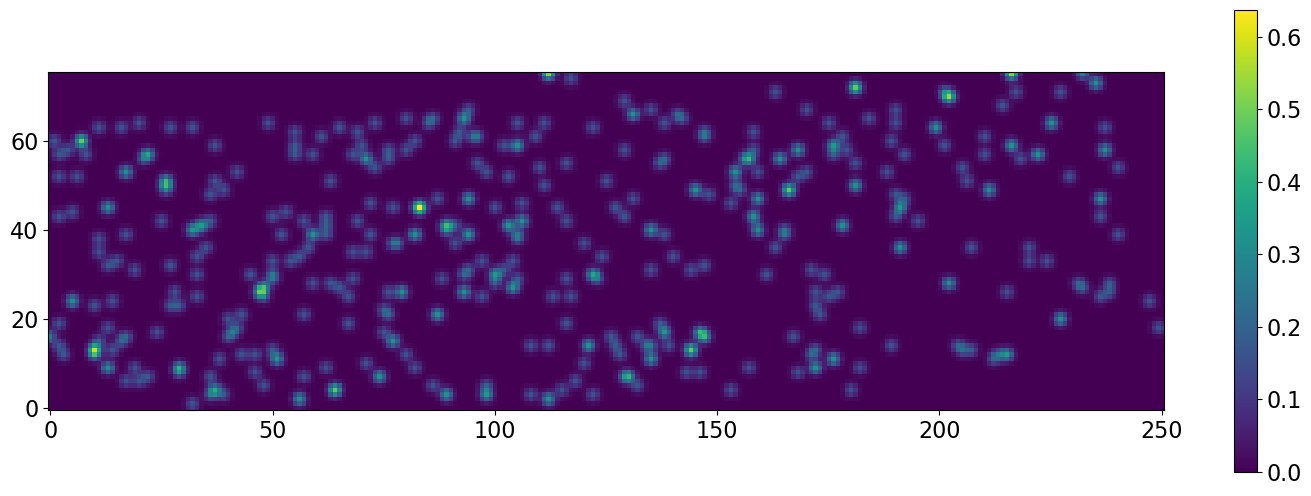

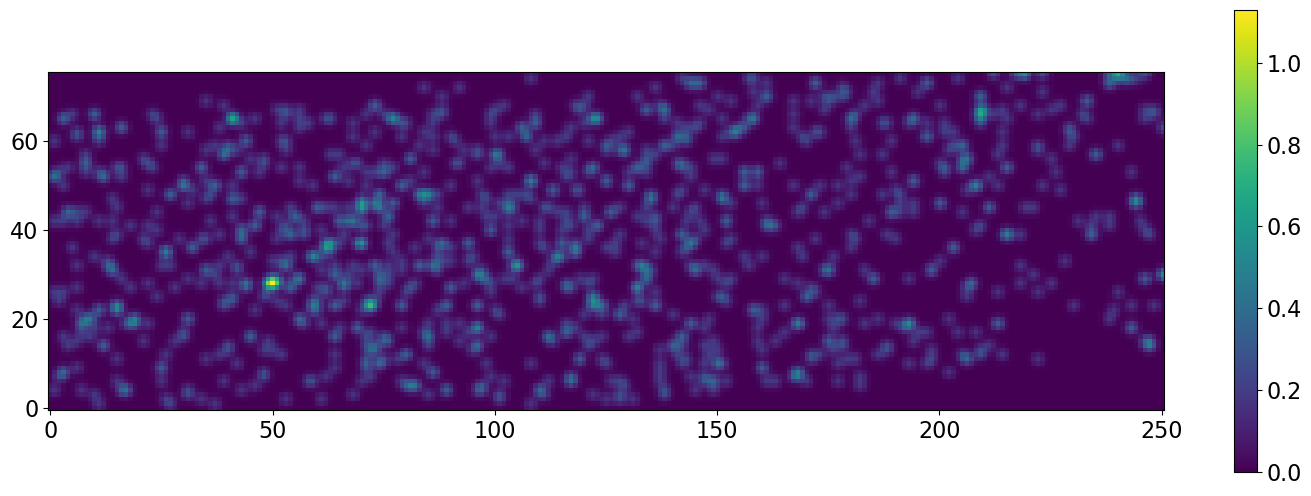

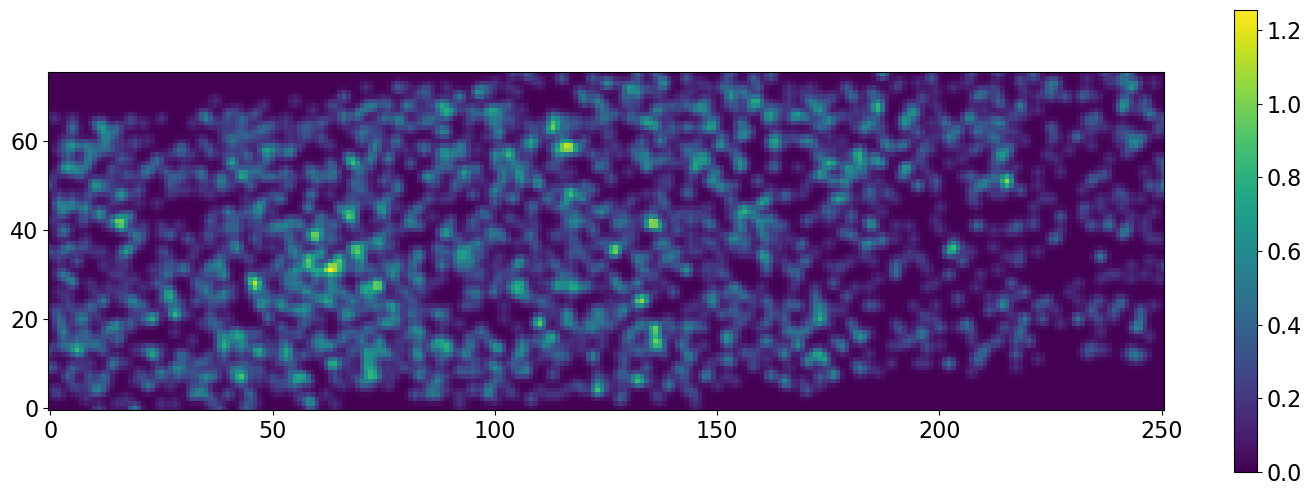

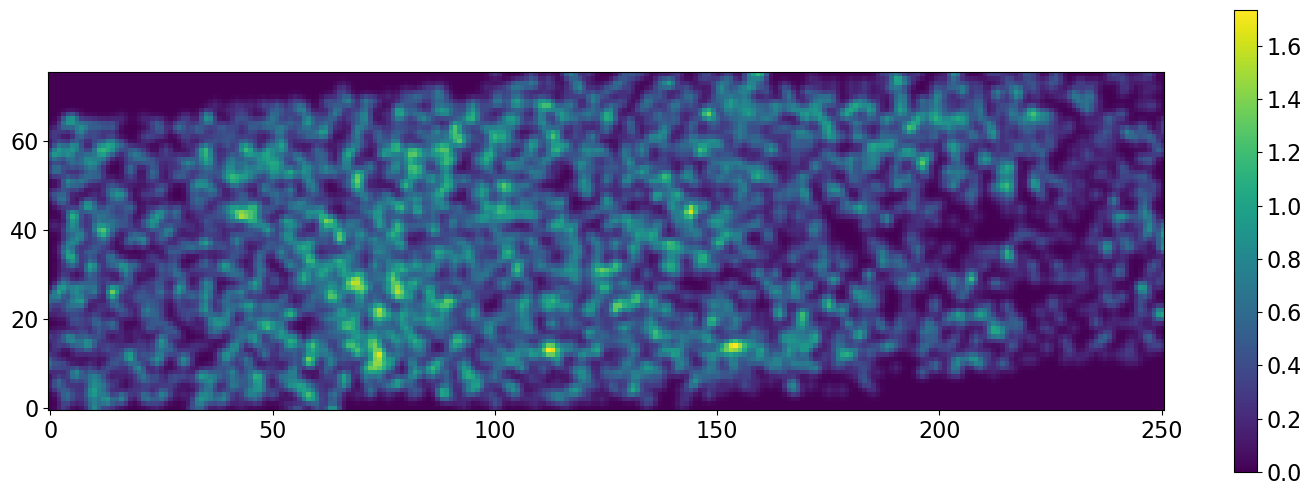

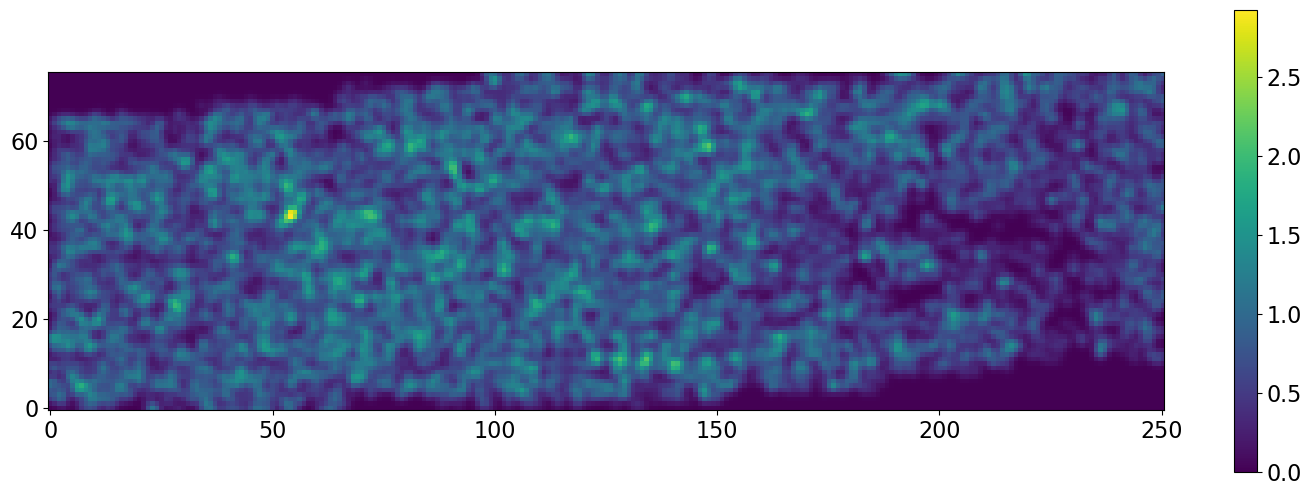

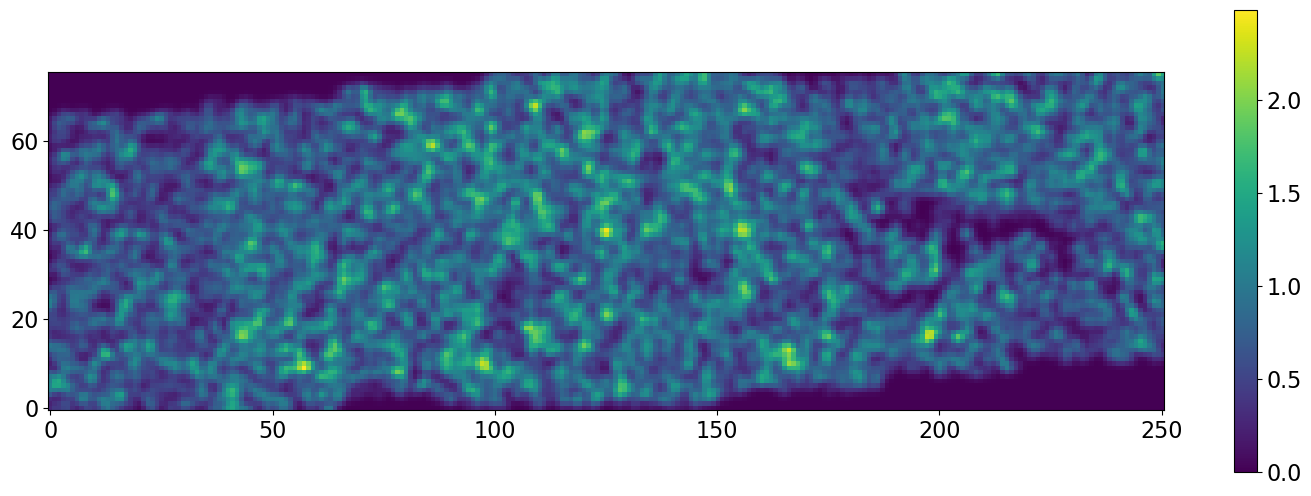

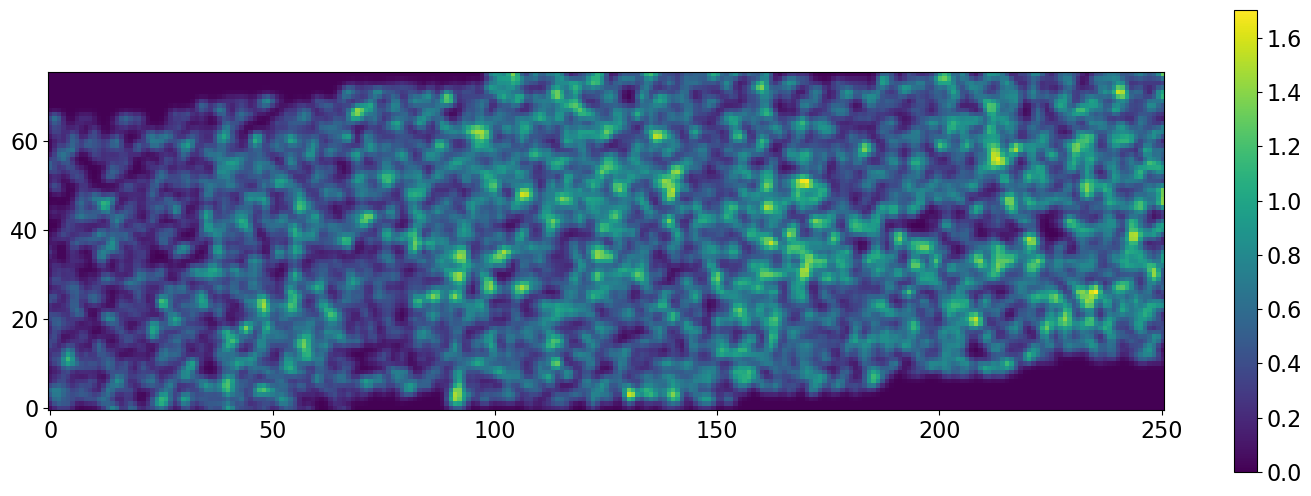

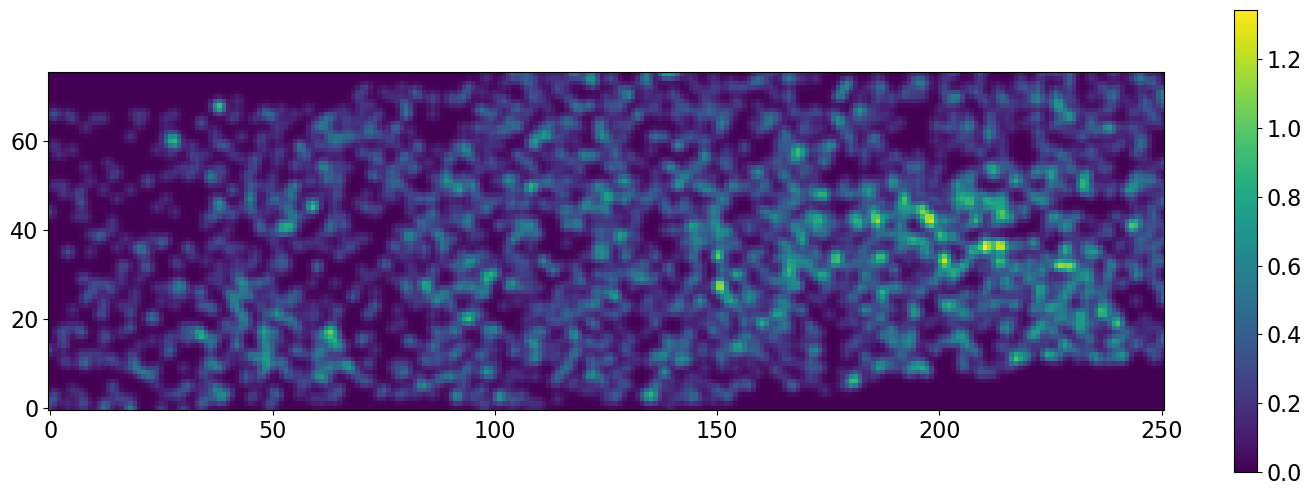

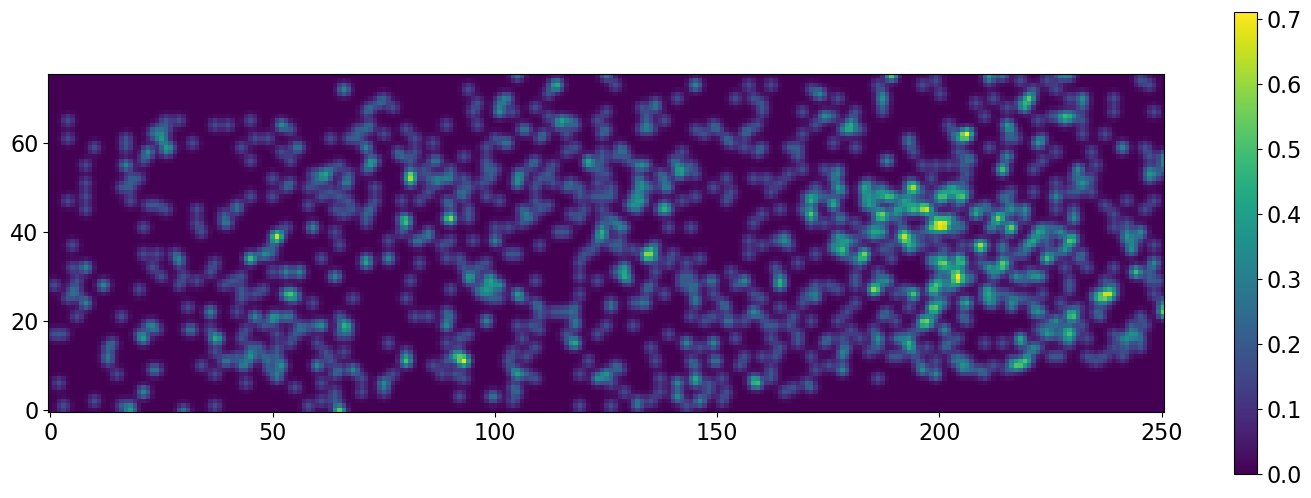

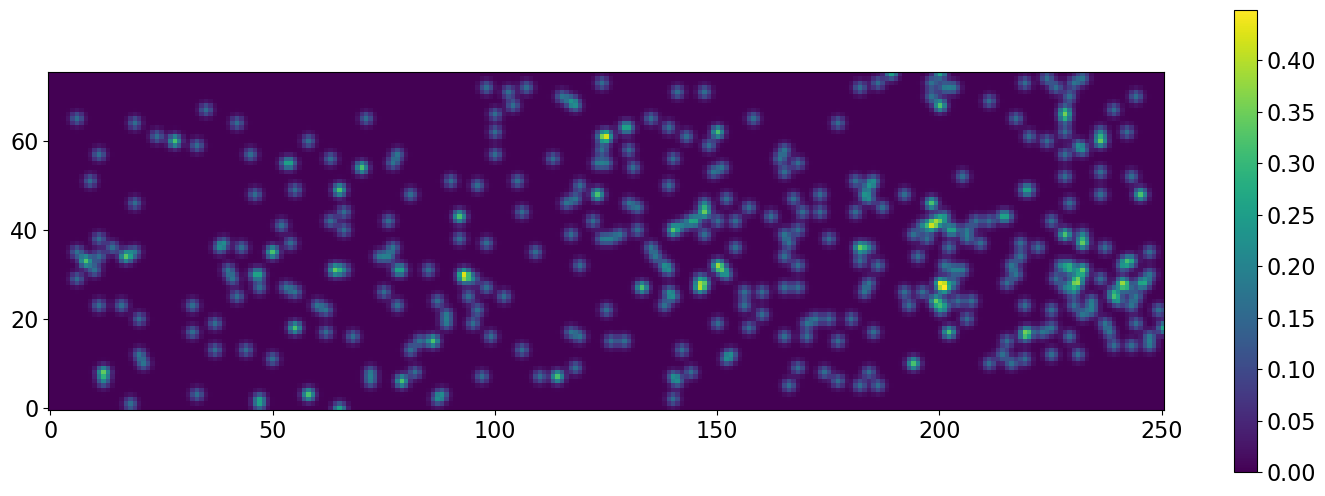

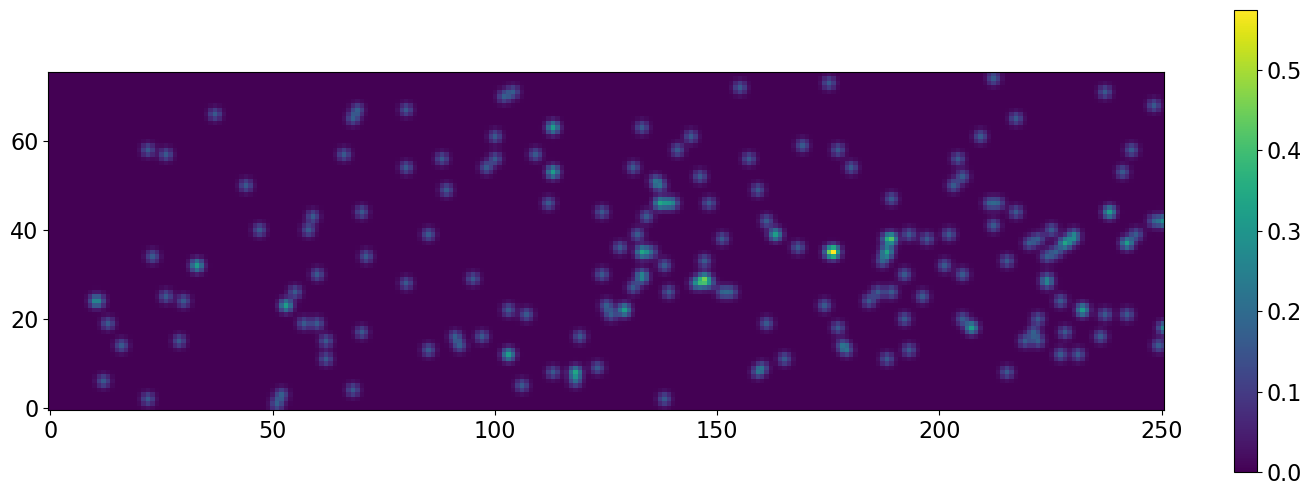

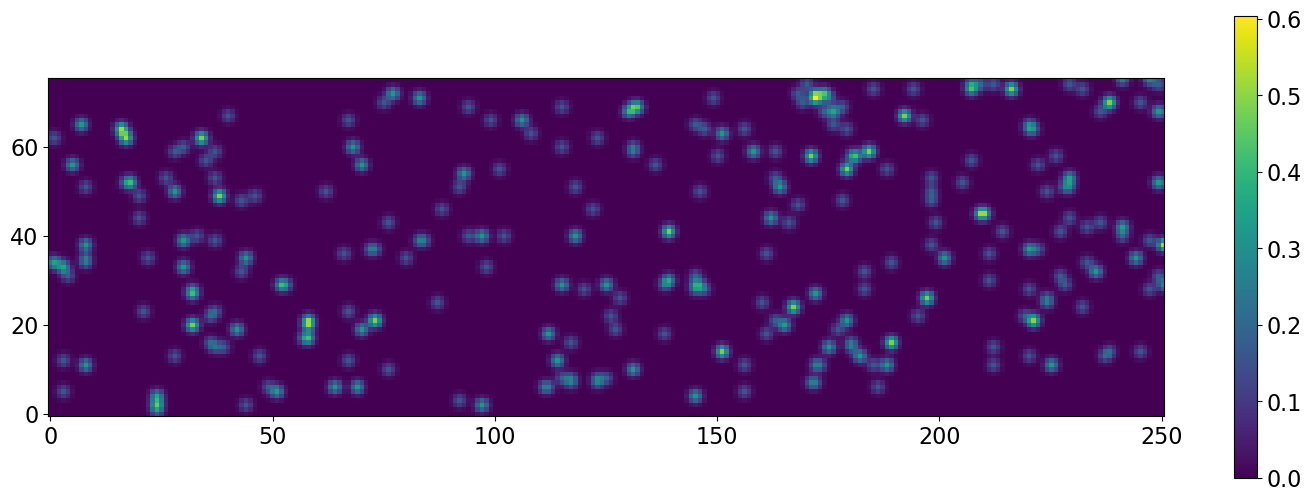

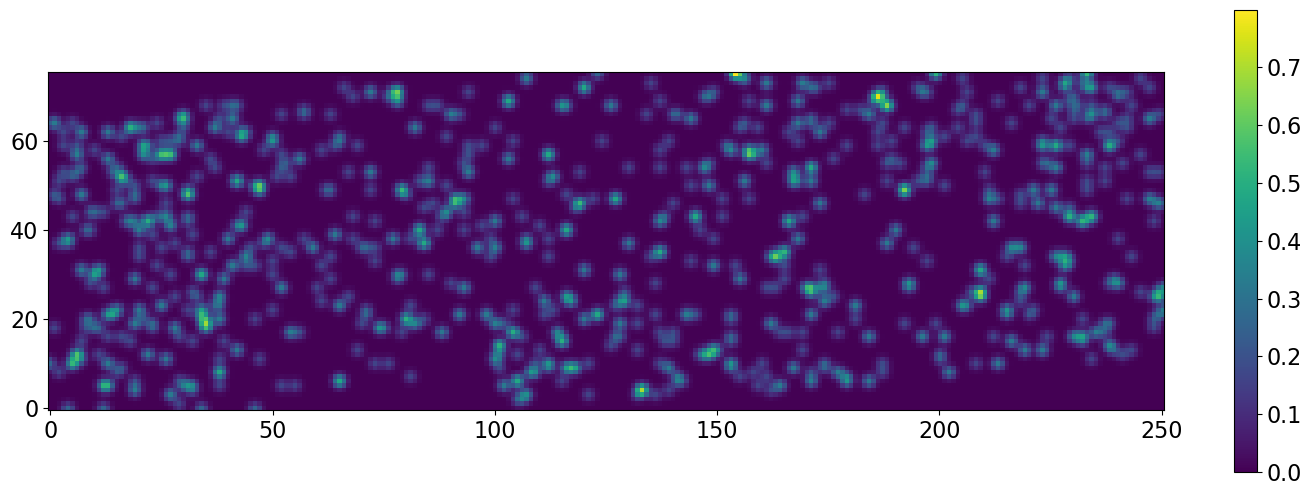

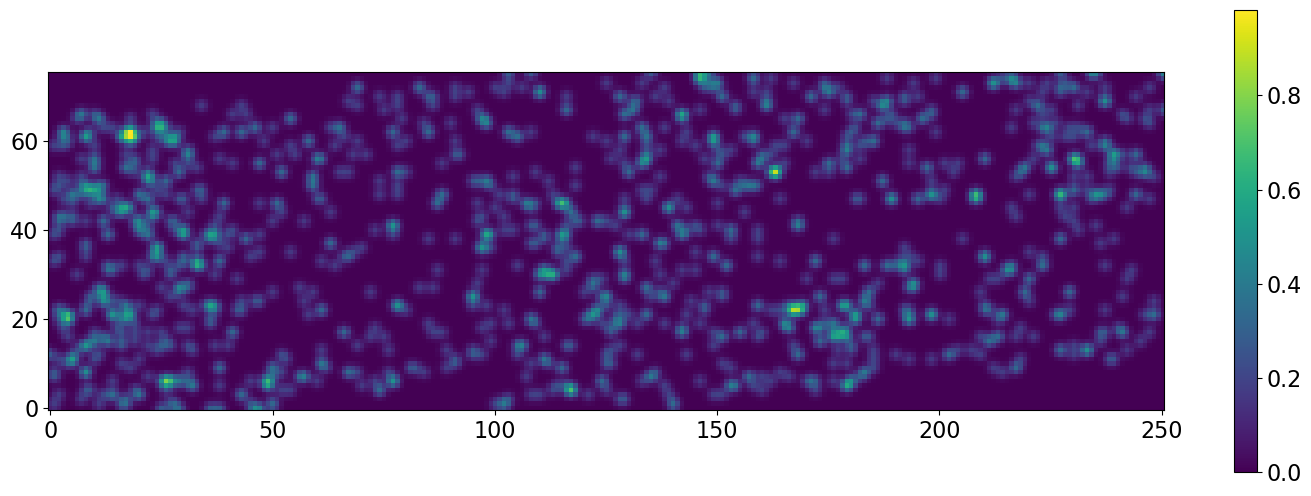

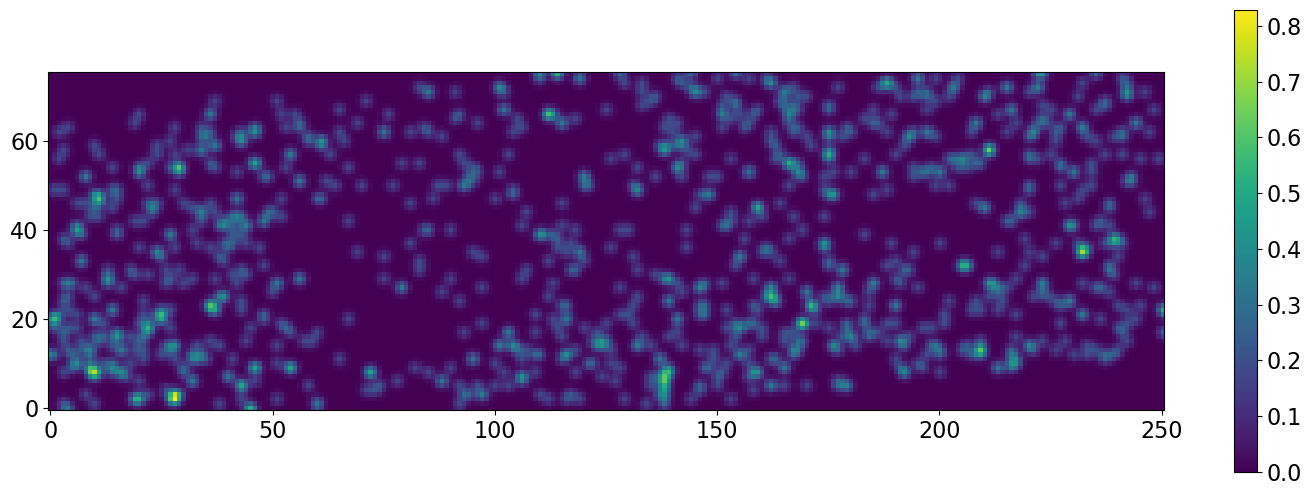

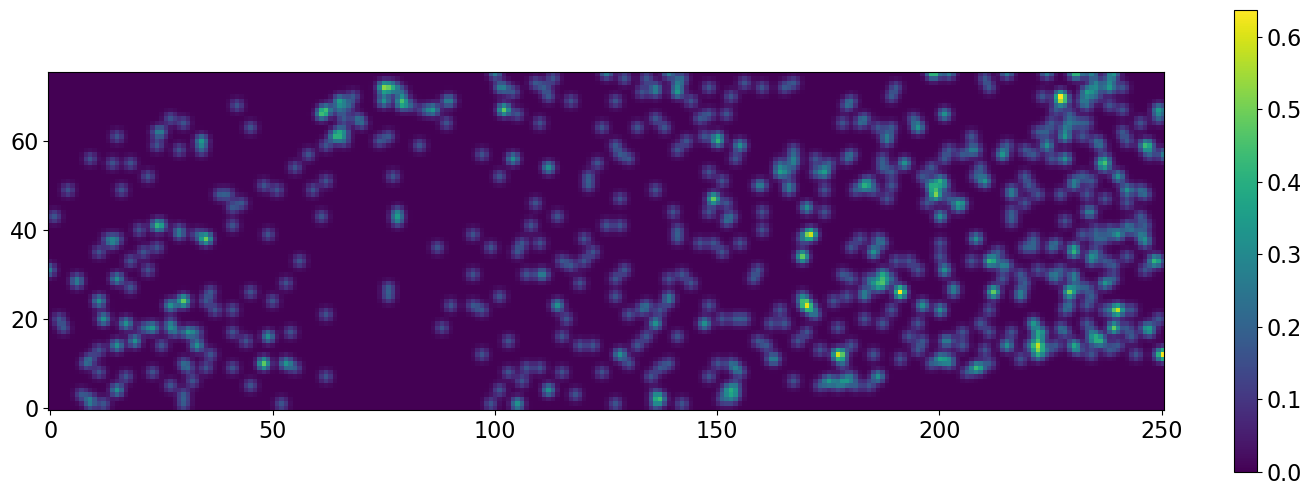

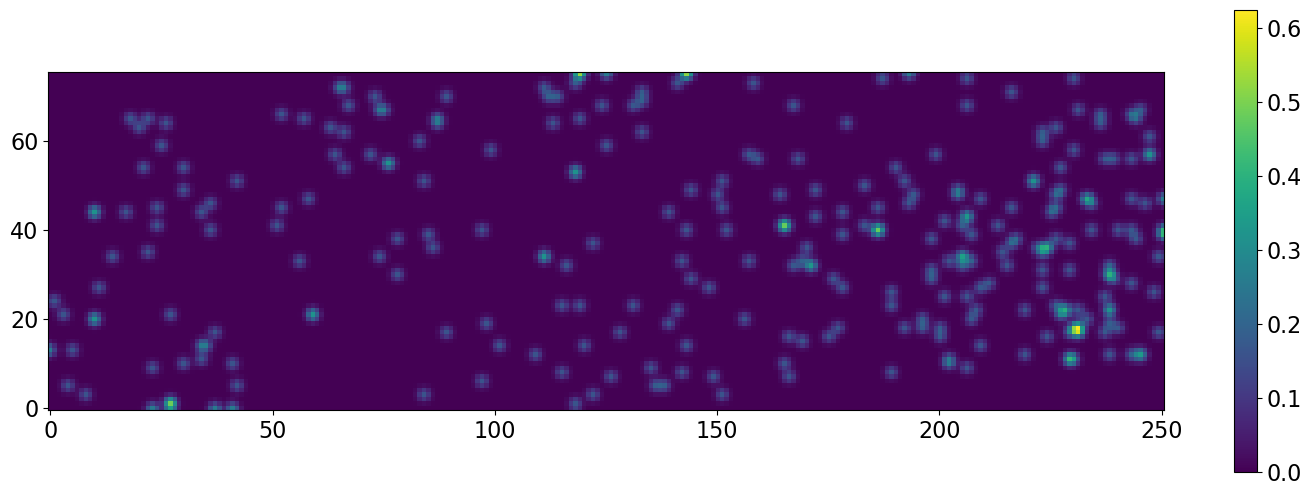

In [82]:
ac2_cube_smoothed = make_cube(basetable, ww, hdu, dx=2, blur=True)

ac2_cube_smoothed.writeto('/orange/adamginsburg/jwst/cloudc/images/star_density_color_cube_4ac2_smoothed.fits', overwrite=True)

# Stars in F410M and not F182M

In [50]:
tbl_noshort = basetable[(basetable['qf_f405n']>0.6) & ~(basetable['mag_ab_f410m'].mask) & (basetable['mag_ab_f182m'].mask) & (basetable['mag_ab_f187n'].mask) & (basetable['mag_ab_f212n'].mask)]
crds_noshort = tbl_noshort['skycoord_ref']

In [51]:
ls /orange/adamginsburg/jwst/cloudc/images/*merged_i2d.fits

/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f182m-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f187n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f212n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f410m-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f466n-merged_i2d.fits


In [52]:
fn_410 = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f410m-merged_i2d.fits'
fn_182 = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f182m-merged_i2d.fits'

In [93]:
#position = SkyCoord('17:46:20.55', '-28:35:28', unit=(u.hourangle, u.deg))
position = crds_noshort[np.random.randint(len(crds_noshort)-1)]

l = 0.1 * u.arcmin
w = 0.1 * u.arcmin
size = (l, w)

reg = regions.RectangleSkyRegion(center=position, width=w, height=l)

2024-03-27 15:50:59,088 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:37:07.964' from MJD-BEG.
Set DATE-AVG to '2023-04-20T10:36:25.656' from MJD-AVG.
Set DATE-END to '2023-04-25T05:35:42.044' from MJD-END'.
  warnings.warn(

2024-03-27 15:50:59,100 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.346130 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.196458 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298959855.736 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-03-27 15:50:59,113 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:37:07.900' from MJD-BEG.
Set DATE-AVG to '2023-04-20T10:36:25.654' from MJD-AVG.
Set DATE-END to '2023-04-25T05:35:42.044' from MJD-END'.
  

<SkyCoord (ICRS): (ra, dec) in deg
    (266.567217, -28.57668075)>


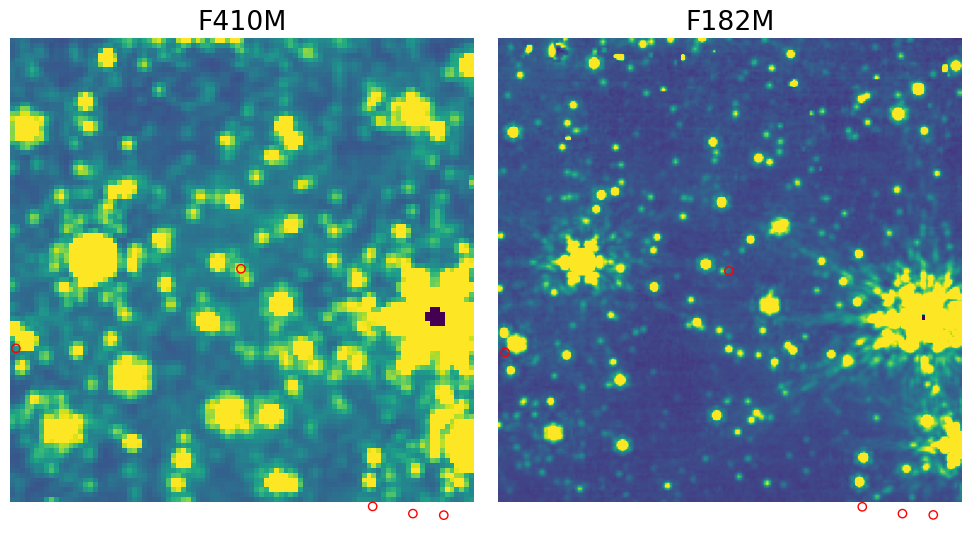

In [94]:
fna = fn_410
fnb = fn_182

ima = ImageModel(fna)
imb = ImageModel(fnb)

hdu_1 = fits.open(fna)
hdu_2 = fits.open(fnb)

ww_1 = WCS(hdu_1['SCI'].header)
ww_2 = WCS(hdu_2['SCI'].header)

cutout_1 = Cutout2D(hdu_1['SCI'].data, position=position, size=size, wcs=ww_1)
cutout_2 = Cutout2D(hdu_2['SCI'].data, position=position, size=size, wcs=ww_2)

ax_1 = plt.subplot(121, projection=cutout_1.wcs)
ax_2 = plt.subplot(122, projection=cutout_2.wcs)

vmin = 0 
vmax = 20
ax_1.imshow(np.nan_to_num(cutout_1.data), vmin=vmin, vmax=vmax)

ax_2.imshow(np.nan_to_num(cutout_2.data), vmin=vmin, vmax=vmax)

crds_in = crds_noshort[reg.contains(crds_noshort, wcs=ww_1)]

ax_1.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax_1.get_transform('world'))
ax_2.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax_2.get_transform('world'))

ax_1.set_title('F410M')
ax_2.set_title('F182M')

ax_1.set_axis_off()
ax_2.set_axis_off()

plt.tight_layout()
print(position)
plt.show()